# Pet-project "Best car deals prediction in Finland" 

## Table of contents

- [0. Introduction](#overview)
- [1. Getting Data](#getting_data)
  - [1.1 REST API](#rest_api)
  - [1.2 Web scrapping](#web_scrapping)
- [2. Data wrangling](#wrangling)
  - [2.1 "Make" feature](#make)
  - [2.2 "Desc" feature](#desc)
  - [2.3 "Key char" feature](#key_char)
  - [2.4 "Place" feature](#place)
  - [2.5 "Price" feature](#price)
- [3. Data cleaning](#cleaning)
- [4. Statistical tests](#stats)
- [5. Outliers detection](#outliers)
- [6. Adding new data](#new_data)
- [7. EDA](#eda)
- [8. Model building](#model)
  - [8.1 Train/test splitting and data scaling](#test)
  - [8.2 Linear regression (Baseline)](#linear)
  - [8.3 Random Forest](#forest)
  - [8.4 XGBoost](#xgb)
- [9. Results](#results)
- [10. Next steps](#steps)

## 0. Introduction <a name="introduction"></a>

<div align="center">
  <a href="https://github.com/lurtz-dahaka/best_car_deals_app">
    <img src="https://i.imgflip.com/36imay.jpg">
  </a>
</div>
    
    
WHAT IS IT ALL ABOUT?   
   
For several years I've been living in Finland and owned old but favourite BMW 5-series. Next year (in 2024) the car will turn 20 years years old so I've started thinking about buying something more young. 
The main aggregator of car ads in Finland is Nettiauto.com. The website is convenient and easy to use, however, my purpose is to find the best offer that allows me to save money. I've decided to not to choose the easiest path but to apply my data science skills and build car price prediction model.


The project is divided into several parts:
- Web scraping
- Data wrangling
- Statistical testing
- Outliers detection
- Data cleaning
- Adding new data
- Feature engineering
- EDA
- Model building

## Metrics
**Key metrics for this task is R2 and MSE score.**

## 0.1 Importing libraries

In [2]:
# Linear algebra
import numpy as np

import datetime

# modules for web scraping 
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

# dataframe management
import pandas as pd

# regular expressions
import re

# Graphs and plots
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from statistics import mean
import statsmodels.api as sm
from scipy.stats import normaltest

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Pipelines
from joblib import dump

Fixing libraries versions.

In [2]:
!pip freeze > requirements.txt

## 1. Getting data <a name="getting_data"></a>

### 1.1 REST API  <a name="rest_api"></a>

First thing that I found was the fact that website has REST API. That was good news as collecting data via API is the most preferred way. Its key advantages are:
- Less resource-intensive, as unnecessary data is not loaded Easy integration into applications for further data processing 
- The data is already structured Bypasses an issue with dynamic page rendering
- Faster than web scraping

However, I could not generate a token using my website credentials (I have checked them and ensured that they are correct). I kept receiving error 401 "You have entered the wrong username or password. Remember that the username and password will write correctly, i.e. remember UPPERCASE and lowercase letters" (translated from finnish). 

In [2]:
data = {
    'grant_type': 'password',
    'username': credentials.username,
    'password': credentials.password,
}

response = requests.post('https://auth.nettix.fi/oauth2/token', data=data)

if response.status_code == 200:
    token_data = response.json()
    access_token = token_data.get("access_token")
    print("Access Token:", access_token)
else:
    print("Failed to obtain access token. Status code:", response.status_code)
    print("Response:", response.text)

Failed to obtain access token. Status code: 401
Response: {"error":"invalid_grant","error_description":"Olet antanut v\u00e4\u00e4r\u00e4n k\u00e4ytt\u00e4j\u00e4tunnuksen tai salasanan. Muista, ett\u00e4 k\u00e4ytt\u00e4j\u00e4tunnus ja salasana tulee kirjoittaa t\u00e4sm\u00e4lleen oikein, eli muista ISOT ja pienet kirjaimet."}


I have also tried to get access using google token (which is allowed in accordance with API documentation) but it did not work as well.

In [3]:
data = {
    'grant_type': 'google',
    'google_token': credentials.google_token
}

response = requests.post('https://auth.nettix.fi/oauth2/token', data=data)

if response.status_code == 200:
    token_data = response.json()
    access_token = token_data.get("access_token")
    print("Access Token:", access_token)
else:
    print("Failed to obtain access token. Status code:", response.status_code)
    print("Response:", response.text)

Failed to obtain access token. Status code: 500
Response: 


I thought that it won't stop me and decided to shift to web-scraping. 

### 1.2 Web scrapping <a name="web_scrapping"></a>

First thing I found using Requests library is that website blocks any automated requests. Response 403 means that server does not authorize such requests.

In [13]:
url = "https://www.nettiauto.com/en/vaihtoautot"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
response = requests.get(url, headers=headers)
print(response)

<Response [403]>


Seems that the website has protection against parsing, therefore, we can use Selenium library. Selenium allows to interact with web pages as if a real user were navigating the site. This includes clicking buttons, filling out forms, submitting data, and navigating through JavaScript-driven web applications. It can render JavaScript content in a way that requests alone cannot. If a website heavily relies on JavaScript to load content dynamically, interact with APIs, or perform client-side rendering, Selenium can access and scrape this content.

Firstly, we can try to scrap all car makes that exist on website.
![all-makes](https://imgur.com/Z3BFaJK.png)

In [77]:
browser = webdriver.Chrome()

url = f'https://www.nettiauto.com'
browser.get(url)
all_makes = browser.find_elements(By.CSS_SELECTOR, '#srch_id_make')[0].text
browser.close()

all_makes = all_makes.replace('\n', ', ').replace('  ', '').split(', ')
all_makes = all_makes[11:-1]

all_makes

['Acura',
 'Alfa Romeo',
 'AMC',
 'Aston Martin',
 'Audi',
 'Austin',
 'Bedford',
 'Bentley',
 'BMW',
 'BMW Alpina',
 'Buick',
 'BYD',
 'Cadillac',
 'Chandler',
 'Chevrolet',
 'Chrysler',
 'Citroen',
 'Cobra',
 'Commer',
 'Cupra',
 'Dacia',
 'Daewoo',
 'Daf',
 'Daihatsu',
 'Daimler',
 'Datsun',
 'Datsun-Nissan',
 'DeSoto',
 'DKW',
 'Dodge',
 'Donau',
 'DS',
 'Edsel',
 'EMW',
 'Essex',
 'Ferrari',
 'Fiat',
 'Fiat-Abarth',
 'Fisker',
 'Ford',
 'GAZ',
 'GMC',
 'Hillman',
 'Honda',
 'Hudson',
 'Humber',
 'Hummer',
 'Hyundai',
 'Ifa',
 'Imperial',
 'Ineos',
 'Infiniti',
 'International',
 'Inzile',
 'Isuzu',
 'Iveco',
 'Jaguar',
 'Jeep',
 'Kia',
 'Lada',
 'Lamborghini',
 'Lancia',
 'Land Rover',
 'Lexus',
 'Leyland',
 'Lincoln',
 'London taxi',
 'Lotus',
 'LuAZ',
 'Lynk & Co',
 'MAN',
 'Maserati',
 'Matra',
 'Maxus',
 'Mazda',
 'McLaren',
 'Mercedes-Benz',
 'Mercury',
 'MG',
 'Mini',
 'Mitsubishi',
 'Mitsubishi Fuso',
 'Morris',
 'Moskvitsh',
 'Muu merkki',
 'Nissan',
 'NSU',
 'Oldsmobile',

Let's see what information could be scraped from website. It could be car make, car model, engine volume, car description, production year, mileage, engine type, price, deal tag, city, seller. Now we'll scrap all this info into big dataset:

![Imgur](https://imgur.com/Nnxfp6B.png)

In [20]:
data_dict = {}
data = pd.DataFrame(data_dict)
browser = webdriver.Chrome()
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")

url = f'https://www.nettiauto.com/vaihtoautot'
browser.get(url)
number_of_pages = browser.find_elements(By.CSS_SELECTOR, '#pagingData > div > span.navigation_link > a.pageNavigation.dot_block')
number_of_pages = int(number_of_pages[0].text)
print(f'Initiating web-scraping of {number_of_pages}...')
browser.close()

for page in range(1, number_of_pages+1):

    browser = webdriver.Chrome()
    options.add_argument("--start-maximized")

    url = f'https://www.nettiauto.com/vaihtoautot?page={page}'
    browser.get(url)
    make_list = browser.find_elements(By.CSS_SELECTOR, '[class="make_model_link"]')
    desc_list = browser.find_elements(By.CSS_SELECTOR, '[class="checkLnesFlat for_rent_one_line"]')
    key_char_list = browser.find_elements(By.CSS_SELECTOR, '[class="vehicle_other_info clearfix_nett"]')
    places_list = browser.find_elements(By.CSS_SELECTOR, '[class="gray_text"]')
    sellers_list = browser.find_elements(By.CSS_SELECTOR, '[class="no_wrap gray_text"]')
    price_list = browser.find_elements(By.CSS_SELECTOR, '[class="price_block"]')
    ids_list = browser.find_elements(By.CSS_SELECTOR, '[class="childVifUrl tricky_link"]')

    print(len(make_list), len(desc_list), len(key_char_list), len(places_list), len(sellers_list), len(price_list), len(ids_list))

    if len(make_list) == len(desc_list) == len(key_char_list) == len(places_list) == len(sellers_list) == len(price_list) == len(ids_list):
        makes = []
        descs = []
        key_chars = []
        places = []
        sellers = []
        prices = []
        ids = []
        
        for val in range(len(make_list)):
            makes.append(make_list[val].text)
            descs.append(desc_list[val].text)
            key_chars.append(key_char_list[val].text.replace('\n', ' | '))
            places.append(places_list[val].text)
            sellers.append(sellers_list[val].text)
            prices.append(price_list[val].text)
            ids.append(ids_list[val].get_attribute('href'))

    else:
        print('Error! Number of values in columns is different!')
        continue

    data_dict['make'] = makes
    data_dict['desc'] = descs
    data_dict['key_char'] = key_chars
    data_dict['place'] = places
    data_dict['seller'] = sellers
    data_dict['price'] = prices
    data_dict['id'] = ids
    
    data_new = pd.DataFrame(data_dict)
    data = pd.concat([data, data_new])
    data.to_csv('data/data_231104.csv')
    print(f'Page {page} out of {number_of_pages} completed')
    browser.close()

Initiating web-scraping of 2861...
32 32 32 32 32 32 32
Page 1 out of 2861 completed
30 30 30 30 30 30 30
Page 2 out of 2861 completed
30 30 30 30 30 30 30
Page 3 out of 2861 completed


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=119.0.6045.105)


It took 335 minutes or 6,5 hours to scrap all 83822 ads.

# 2. Data wrangling <a name="wrangling"></a>

In [78]:
data = pd.read_csv('/Users/egor/Documents/best_car_deals_app/data/data_full.csv')
data

Unnamed: 0                          make  \
0               0       Mercedes-Benz GLC (2.0)   
1               1           Opel Frontera (2.2)   
2               2             Opel Vectra (1.8)   
3               3                 BMW 525 (2.5)   
4               4            Daewoo Kalos (1.4)   
...           ...                           ...   
83817          25                  BMW X7 (3.0)   
83818          26                  BMW X5 (3.0)   
83819          27      Mercedes-Benz Vito (2.1)   
83820          28  Mercedes-Benz Sprinter (2.1)   
83821          29                 Audi R8 (5.2)   

                                                    desc  \
0                 300 e 4MATIC A Business Coupé EQ Power   
1      2.2-16DTI 5d GL **Juuri katsastettu huippu jah...   
2                Ei tieliikennekelpoinen - 1.8 16v 125hv   
3      Ei tieliikennekelpoinen - i Touring A Kori ilm...   
4                 Ei tieliikennekelpoinen - 1.4 SE Sedan   
...                                                  ...   
83817                                           G07 M50d   
83818                                    G05 xDrive30d A   
83819              116 BlueTEC-3,05/32KB keskipitkä A2 A   
83820               314CDI RWD-3,5/37 KB keskipitkä A2 A   
83821  Coupé V10 Plus 5,2 FSI quattro S tronic 5.2 V1...   

                                          key_char  \
0      2020 | 15 000 km | Hybridi (bensiini/sähkö)   
1            1999 | 398 000 km | Diesel | Manuaali   
2          2001 | 209 000 km | Bensiini | Manuaali   
3        2003 | 350 000 km | Bensiini | Automaatti   
4          2003 | 233 000 km | Bensiini | Manuaali   
...                                            ...   
83817      2019 | 140 000 km | Diesel | Automaatti   
83818       2020 | 51 600 km | Diesel | Automaatti   
83819                   2023 | Diesel | Automaatti   
83820                   2023 | Diesel | Automaatti   
83821     2014 | 35 000 km | Bensiini | Automaatti   

                                 place  \
0                   Espoo › Veho Olari   
1       Kuusamo › Automyynti Haapasalo   
2      Jyväskylä › Jani Mikael Kassala   
3           Helsinki › Lasse Matintalo   
4        Orimattila › Johanna Rytkönen   
...                                ...   
83817           Viro › Baltic Truck OÜ   
83818            Vantaa › Aivo Liivand   
83819           Helsinki › Auto MHR Oy   
83820           Helsinki › Auto MHR Oy   
83821             Viro › Karel Kaldoja   

                                                  price  
0               57 800 €\nRahoitus alkaen:\n818.47 €/kk  
1                                               3 795 €  
2                                                 100 €  
3                                                 100 €  
4                                                 100 €  
...                                                 ...  
83817                    75 000 €\n(Tax free, sis. ALV)  
83818  79 500 €\n(Tax free)\nRahoitus alkaen:\n868 €/kk  
83819                              85 000 €\n(Tax free)  
83820                              85 850 €\n(Tax free)  
83821  89 000 €\n(Tax free)\nRahoitus alkaen:\n868 €/kk  

[83822 rows x 6 columns]

Let's look at the data that we have to work with.
    
    
<table >
   <tr>
    <th>Column</th>
    <th>Description</th>
  </tr>
  
   <tr>
    <td>make</td>
    <td>includes car make, car model and engine volume </td>
  </tr>
    
   <tr>
    <td>desc</td>
    <td>car description filled by seller</td>
  </tr> 
    
  <tr>
    <td>key_char</td>
    <td>key car characteristics including production year, mileage, engine type and gearbox type</td>
  </tr>
    
  <tr>
    <td>place</td>
    <td>city where the car is sold and seller</td>
  </tr>
    
   <tr>
    <td>price</td>
    <td>car price and deal type tag</td>
  </tr>
    
   
    
</table>
    
</div>


## 2.1 "Make" feature <a name="make"></a>
Let's start with "Make" feature. It is presented as "Car_company" *space* "Model" ("engine volume"). So it could be 3 separate features.  

As engine volume is always between brackets, we can extract it using regular expression:

In [79]:
def get_engine_volume(sample_string):
    pattern = r'\((.*?)\)'
    values_in_brackets = re.findall(pattern, sample_string)
    # for some cars engine volume is not indicated (for example electric cars)
    # i'll tag them with -1
    if len(values_in_brackets) == 0:
        return -1
    elif len(values_in_brackets) == 1:
        return values_in_brackets[0] 
    # in case if string has several values in brackets
    else:
        return 'Error'

# applying function to "make" feature and creating "engine_vol" column
data['engine_vol'] = data['make'].apply(lambda x: get_engine_volume(x))

Ensuring that there are no errors:

In [80]:
data[data['engine_vol'] == 'Error']

Empty DataFrame
Columns: [Unnamed: 0, make, desc, key_char, place, price, engine_vol]
Index: []

Now we need to extract car company from "make". Previously I've scraped all companies in all_makes list.

In [81]:
def extract_make_name(sample_string, make_list):
    for make in make_list:
        if make in sample_string:
            return make
    return None  # Return None if no matching make is found


data['car_make'] = data['make'].apply(lambda x: extract_make_name(x, all_makes))

Ensuring that there are no 'None' values:

In [82]:
data[data['car_make'] == None]

Empty DataFrame
Columns: [Unnamed: 0, make, desc, key_char, place, price, engine_vol, car_make]
Index: []

Extracting model:

In [83]:
def extract_model_name(sample_string, make_list):
    pattern = r'\s*\(\d+\.\d+\)'
    values_in_brackets = re.findall(pattern, sample_string)
    if len(values_in_brackets) == 1:
        sample_string = sample_string.replace(values_in_brackets[0], '')
    for make in make_list:
        if make in sample_string:
            sample_string = sample_string.replace(make, '').strip()
    return sample_string  # Return None if no matching make is found

data['model'] = data['make'].apply(lambda x: extract_model_name(x, all_makes))

In [84]:
data['model'].value_counts()

model
Octavia      2018
C            1877
Golf         1846
E            1830
Corolla      1713
             ... 
Yukon XL        1
B2200           1
Executive       1
Cressida        1
RX-7            1
Name: count, Length: 1547, dtype: int64

In [85]:
data['make_model'] = data['car_make'] + ' ' + data['model']

## 2.2 "Desc" feature <a name="desc"></a>

Moving further. I'll review 'desc' column which contains description about the car. We can extract several new features: 
- whether the car is roadworthy or not. Some cars have "Ei tieliikennekelpoinen" in description which means that it is not roadworthy and repair is required.
- whether the car has all-wheel drive option. There are several ways to define that car has AWD system, for example, xDrive for BMW or 4matic for Mercedes-Benz 
- car category: sedan, universal, hatchback etc.
- number of doors: could be 4/5 or 2/3 
- horse power by 'hv' tag
- power by 'kW' tag
- capacity (for hybrid and electric cars) by 'kWh' tag

In [86]:
data['desc'] = data['desc'].astype(str)

data['roadworthy'] = data['desc'].apply(lambda x: 0 if 'Ei tieliikennekelpoinen' in x else 1)

In [87]:
awd_types = ['awd', '4wd', '4x4', 'xdrive', '4matic', 'quattro', 'all-wheel drive', 'all wheel', 'super select']

def is_awd(sample_string, awd_types):
    sample_string = sample_string.lower()
    for type in awd_types:
        if type in sample_string:
            return 1
    return 0  # Return 0 if no matching type is found


data['awd'] = data['desc'].apply(lambda x: is_awd(x, awd_types))

In [88]:
categories = {
    'sedan': 'Sedan',
    'avant': 'Universal',
    'van': 'Minivan',
    'combi': 'Universal',
    'tourer': 'Universal',
    'wagon': 'Universal',
    'touring': 'Universal',
    'farmari': 'Universal',
    'sportback': 'Hatchback',
    'coupe': 'Coupe',
    'coupé': 'Coupe',
    'hatchback': 'Hatchback',
    'cabriolet': 'Cabriolet',
    'convertible': 'Cabriolet',
    'cabrio': 'Cabriolet',
    'pickup': 'Pickup',
    'spaceback': 'Hatchback',
    'crossover': 'Jeep',
    'estate': 'Universal',
    'sportswagon': 'Universal',
    'shooting': 'Universal',
    'targa': 'Coupe',
    'hardtop': 'Coupe',
    'saloon': 'Sedan',
    'roadster': 'Coupe',
    'spider': 'Coupe',
    'turismo': 'Hatchback',
    'mpv': 'Minivan',
    'fastback': 'Coupe',
    'suv': 'Jeep'
}

def get_category(sample_string, categories):
    sample_string = sample_string.lower().split(' ')
    for word in sample_string:
        if word in categories:
            return categories.get(word)

data['category'] = data['desc'].apply(lambda x: get_category(x, categories))

In [89]:
doors_count = {
    '5-ovinen,': '4/5',
    '5-door': '4/5',
    '5-ovinen': '4/5',
    '#5-ovinen': '4/5',
    '2ov': '2/3',
    '2-door': '2/3',
    '3-door': '2/3',
    '3ov': '2/3',
    '2-ov': '2/3',
    '4ov': '4/5',
    '4-ov': '4/5',
    '4door': '4/5',
    '5-ov,': '4/5',
    'kaksiovinen': '2/3',
    '2d': '2/3',
    '3d': '2/3',
    '4d': '4/5',
    '5d': '4/5'
    }

def get_doors(sample_string, doors_count):
    sample_string = sample_string.lower().split(' ')
    for word in sample_string:
        if word in doors_count:
            return doors_count.get(word)

data['doors'] = data['desc'].apply(lambda x: get_doors(x, doors_count))

In [90]:
def extract_horsepower(string):
    string = string.lower()
    pattern = r'(\d+)\s*hv'
    match = re.search(pattern, string)
    if match:
        return int(match.group(1))

data['hp'] = data['desc'].apply(lambda x: extract_horsepower(x))

In [91]:
def extract_power(string):
    string = string.lower()
    pattern = r'(\d+)\s*kw(?!h)'
    match = re.search(pattern, string)
    if match:
        return int(match.group(1))

data['power'] = data['desc'].apply(lambda x: extract_power(x))

In [92]:
def extract_capacity(string):
    string = string.lower()
    pattern = r'(\d+)\s*kwh'
    match = re.search(pattern, string)
    if match:
        return int(match.group(1))

data['capacity'] = data['desc'].apply(lambda x: extract_capacity(x))

## 2.3 "Key char" feature <a name="key_char"></a>
'key_char' feature contains 3 or 4 sub-features. If the car is electric or hybrid gearbox type is not indicated, so we can extract only 'year', 'mileage' and 'fuel_type'. For other fuel types we can extract whether gearbox is manual or automatic. 

Splitting key_char feature for sub-features:

In [93]:
def organize_key_char(sample_string):
    sample_list = sample_string.split('|')
    for i in range(len(sample_list)):
        sample_list[i] = sample_list[i].strip()
    return sample_list
        
data['key_char'] = data['key_char'].apply(lambda x: organize_key_char(x))

Extracting year:

In [94]:
data['year'] = data['key_char'].apply(lambda x: x[0].strip())

Extracting mileage:

In [95]:
def extract_mileage(sample_list):
    if 'km' in sample_list[1]:
        return sample_list[1].strip()[:-2].replace(' ', '')
    else:
        '-1'
    
data['mileage'] = data['key_char'].apply(lambda x: extract_mileage(x))

Extracting fuel_type and gearbox_type:

In [96]:
fuel_type = ['Bensiini', 'Diesel', 'Hybridi (bensiini/sähkö)', 'Hybridi (diesel/sähkö)', 'Sähkö', 'Kaasu', 'E85/bensiini', 'Ei saatavilla']
gearbox_type = ['Automaatti', 'Manuaali']

def get_type(sample_list, types):
    for type in types:
        if type in sample_list:
            return type

data['fuel_type'] = data['key_char'].apply(lambda x: get_type(x, fuel_type))
data['gearbox_type'] = data['key_char'].apply(lambda x: get_type(x, gearbox_type))

In [97]:
data['fuel_type'].value_counts()

fuel_type
Bensiini                    35997
Diesel                      27531
Hybridi (bensiini/sähkö)    11826
Sähkö                        5779
Hybridi (diesel/sähkö)        691
Kaasu                         573
E85/bensiini                  229
Ei saatavilla                  11
Name: count, dtype: int64

In [98]:
data['gearbox_type'].value_counts()

gearbox_type
Automaatti    41094
Manuaali      30031
Name: count, dtype: int64

## 2.4 "Place" feature <a name="place"></a>
This feature has city where the car is sold and seller's name. Seller could be a company or private individual.

In [99]:
def organize_place(sample_string):
    sample_list = sample_string.split('›')
    for i in range(len(sample_list)):
        sample_list[i] = sample_list[i].strip()
    return sample_list

data['place'] = data['place'].apply(lambda x: organize_place(x))

In [100]:
data['town'] = data['place'].apply(lambda x: x[0])

In [101]:
data['seller'] = data['place'].apply(lambda x: x[1:])

Some sellers are companies from one group of companies. For example J. Rinta-Jouppi Oulu and J. Rinta-Jouppi Espoo are different sellers but both are part of J. Rinta-Jouppi. It might be insightful to group such companies together to see who is the market leader. 

In [102]:
car_dealers = ['J. Rinta-Jouppi', 'Autokeskus Oy', 'Autolle.com', 'Suursavonauto.fi', 'Wetteri', 'AC Auto-Center', 'Rinta-Joupin Autoliike', 'Hedin Automotive', 'LänsiAuto', 'Kamux', 'K-auto', 'Saka Finland Oy', 'Secto Vaihtoautot', 'Autotalo', 'Auto-Suni', 'Nelipyörä', 'Ford Store', 'Hedin Automotive', 'Automaa', 'Bavaria', 'Toyota', 'Omax', 'ALD Carmarket', 'Delta Auto', 'Pörhö', 'Veho', 'Bilar99e', 'Autosalpa', 'Vaihtokaara', 'Auto-Kilta', 'Autodeal', 'Keskusautohalli Oy', 'Helkama-Auto', 'MB-mobile', 'XBIL', 'Autoverkkokauppa.fi', 'Kupen auto', 'KymppiPlus', 'Menoauto', 'Vaihtoautomaa', 'ALD Carmarket', 'MS-auto', 'Euro Auto', 'Tojo-Auto', 'Porsche Center', 'Levorannan Autoliike', 'SCC - Sports Car Center', 'Ajanvaunu Oy', 'Auto-Kehä Oy', 'Auto-Eekoo']

def group_seller(sample_list, car_dealers):
    for string in list(map(str.lower, sample_list)):
        for dealer in list(map(str.lower, car_dealers)):
            x = string.replace(dealer, '')
            if(len(x) != len(string)):
                return dealer.lower()
    try: 
        return sample_list[0]
    except IndexError:
        return sample_list

        
data['car_seller'] = data['seller'].apply(lambda x: group_seller(x, car_dealers))
data['car_seller'] = data['car_seller'].astype(str)
data['car_seller'] = data['car_seller'].apply(lambda x: x.lower())

## 2.5 "Price" feature <a name="price"></a>
This column consists of price and deal type tag. 

In [103]:
data['price'] = data['price'].apply(lambda x: x.split('\n'))

In [104]:
data['car_price'] = data['price'].apply(lambda x: x[0].replace('€', '').replace(' ', ''))
data['car_price']

0        57800
1         3795
2          100
3          100
4          100
         ...  
83817    75000
83818    79500
83819    85000
83820    85850
83821    89000
Name: car_price, Length: 83822, dtype: object

In [105]:
def extract_deal(sample_list):
    try:
        if '(' in sample_list[1]:
            return sample_list[1].replace('(', '').replace(')', '').strip()
        else:
            return None
    except IndexError:
        return None

data['deal'] = data['price'].apply(lambda x: extract_deal(x))

In [106]:
data['deal'].value_counts()

deal
sis. ALV                   10882
ALV väh.kelp.               5022
Tax free                     565
Tax free, sis. ALV            42
Tax free, ALV väh.kelp.       10
Name: count, dtype: int64

### Saving data

In [108]:
data.to_csv('/Users/egor/Documents/best_car_deals_app/data/data_new.csv')

In [109]:
data = pd.read_csv('/Users/egor/Documents/best_car_deals_app/data/data_new.csv')

/var/folders/fg/7cyb3m_113j_1hkfwhtbsy8h0000gn/T/ipykernel_49279/570389149.py:1: DtypeWarning: Columns (18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/egor/Documents/best_car_deals_app/data/data_new.csv')


# 3. Data cleaning <a name="cleaning"></a>

Let's have a look on our data.

In [110]:
data

Unnamed: 0.1  Unnamed: 0                          make  \
0                 0           0       Mercedes-Benz GLC (2.0)   
1                 1           1           Opel Frontera (2.2)   
2                 2           2             Opel Vectra (1.8)   
3                 3           3                 BMW 525 (2.5)   
4                 4           4            Daewoo Kalos (1.4)   
...             ...         ...                           ...   
83817         83817          25                  BMW X7 (3.0)   
83818         83818          26                  BMW X5 (3.0)   
83819         83819          27      Mercedes-Benz Vito (2.1)   
83820         83820          28  Mercedes-Benz Sprinter (2.1)   
83821         83821          29                 Audi R8 (5.2)   

                                                    desc  \
0                 300 e 4MATIC A Business Coupé EQ Power   
1      2.2-16DTI 5d GL **Juuri katsastettu huippu jah...   
2                Ei tieliikennekelpoinen - 1.8 16v 125hv   
3      Ei tieliikennekelpoinen - i Touring A Kori ilm...   
4                 Ei tieliikennekelpoinen - 1.4 SE Sedan   
...                                                  ...   
83817                                           G07 M50d   
83818                                    G05 xDrive30d A   
83819              116 BlueTEC-3,05/32KB keskipitkä A2 A   
83820               314CDI RWD-3,5/37 KB keskipitkä A2 A   
83821  Coupé V10 Plus 5,2 FSI quattro S tronic 5.2 V1...   

                                                key_char  \
0      ['2020', '15 000 km', 'Hybridi (bensiini/sähkö)']   
1           ['1999', '398 000 km', 'Diesel', 'Manuaali']   
2         ['2001', '209 000 km', 'Bensiini', 'Manuaali']   
3       ['2003', '350 000 km', 'Bensiini', 'Automaatti']   
4         ['2003', '233 000 km', 'Bensiini', 'Manuaali']   
...                                                  ...   
83817     ['2019', '140 000 km', 'Diesel', 'Automaatti']   
83818      ['2020', '51 600 km', 'Diesel', 'Automaatti']   
83819                   ['2023', 'Diesel', 'Automaatti']   
83820                   ['2023', 'Diesel', 'Automaatti']   
83821    ['2014', '35 000 km', 'Bensiini', 'Automaatti']   

                                      place  \
0                   ['Espoo', 'Veho Olari']   
1       ['Kuusamo', 'Automyynti Haapasalo']   
2      ['Jyväskylä', 'Jani Mikael Kassala']   
3           ['Helsinki', 'Lasse Matintalo']   
4        ['Orimattila', 'Johanna Rytkönen']   
...                                     ...   
83817           ['Viro', 'Baltic Truck OÜ']   
83818            ['Vantaa', 'Aivo Liivand']   
83819           ['Helsinki', 'Auto MHR Oy']   
83820           ['Helsinki', 'Auto MHR Oy']   
83821             ['Viro', 'Karel Kaldoja']   

                                                   price  engine_vol  \
0        ['57 800 €', 'Rahoitus alkaen:', '818.47 €/kk']         2.0   
1                                            ['3 795 €']         2.2   
2                                              ['100 €']         1.8   
3                                              ['100 €']         2.5   
4                                              ['100 €']         1.4   
...                                                  ...         ...   
83817               ['75 000 €', '(Tax free, sis. ALV)']         3.0   
83818  ['79 500 €', '(Tax free)', 'Rahoitus alkaen:',...         3.0   
83819                         ['85 000 €', '(Tax free)']         2.1   
83820                         ['85 850 €', '(Tax free)']         2.1   
83821  ['89 000 €', '(Tax free)', 'Rahoitus alkaen:',...         5.2   

            car_make     model  ... capacity  year   mileage  \
0      Mercedes-Benz       GLC  ...      NaN  2020   15000.0   
1               Opel  Frontera  ...      NaN  1999  398000.0   
2               Opel    Vectra  ...      NaN  2001  209000.0   
3                BMW       525  ...      NaN  2003  350000.0   
4             Daewoo     Kalos  ..

Checking NaN values:

In [111]:
data.isna().sum()

Unnamed: 0.1        0
Unnamed: 0          0
make                0
desc             5303
key_char            0
place               0
price               0
engine_vol          0
car_make           14
model              18
make_model         14
roadworthy          0
awd                 0
category        66795
doors           74604
hp              72777
power           73646
capacity        81541
year                0
mileage          6381
fuel_type        1185
gearbox_type    12697
town                0
seller              0
car_seller          0
car_price           0
deal            67301
dtype: int64

Deleting unnecessary columns

In [112]:
data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'make', 'desc', 'key_char', 'place', 'price', 'seller'])
data.head()

engine_vol       car_make     model         make_model  roadworthy  awd  \
0         2.0  Mercedes-Benz       GLC  Mercedes-Benz GLC           1    1   
1         2.2           Opel  Frontera      Opel Frontera           1    0   
2         1.8           Opel    Vectra        Opel Vectra           0    0   
3         2.5            BMW       525            BMW 525           0    0   
4         1.4         Daewoo     Kalos       Daewoo Kalos           0    0   

    category doors     hp  power  capacity  year   mileage  \
0      Coupe   NaN    NaN    NaN       NaN  2020   15000.0   
1        NaN   4/5    NaN    NaN       NaN  1999  398000.0   
2        NaN   NaN  125.0    NaN       NaN  2001  209000.0   
3  Universal   NaN    NaN    NaN       NaN  2003  350000.0   
4      Sedan   NaN    NaN    NaN       NaN  2003  233000.0   

                  fuel_type gearbox_type        town            car_seller  \
0  Hybridi (bensiini/sähkö)          NaN       Espoo                  veho   
1                    Diesel     Manuaali     Kuusamo  automyynti haapasalo   
2                  Bensiini     Manuaali   Jyväskylä   jani mikael kassala   
3                  Bensiini   Automaatti    Helsinki       lasse matintalo   
4                  Bensiini     Manuaali  Orimattila      johanna rytkönen   

  car_price deal  
0     57800  NaN  
1      3795  NaN  
2       100  NaN  
3       100  NaN  
4       100  NaN

Rows with NaN values that are critical for prediction shall be deleted.

In [113]:
data = data.dropna(subset=['mileage', 'make_model'])

Let's create a set of indexes that we delete further.

In [114]:
to_be_deleted = set()

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77432 entries, 0 to 83821
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_vol    77432 non-null  float64
 1   car_make      77432 non-null  object 
 2   model         77419 non-null  object 
 3   make_model    77432 non-null  object 
 4   roadworthy    77432 non-null  int64  
 5   awd           77432 non-null  int64  
 6   category      16153 non-null  object 
 7   doors         8587 non-null   object 
 8   hp            9471 non-null   float64
 9   power         9670 non-null   float64
 10  capacity      1714 non-null   float64
 11  year          77432 non-null  object 
 12  mileage       77432 non-null  float64
 13  fuel_type     76339 non-null  object 
 14  gearbox_type  66357 non-null  object 
 15  town          77432 non-null  object 
 16  car_seller    77432 non-null  object 
 17  car_price     77432 non-null  object 
 18  deal          13323 non-null  o

Some cars don't have make and model indicated. They are indicated as 'Muu merkki' and 'Muu malli' which means 'Other make' and 'Other model'. 

In [116]:
no_make_model = data[(data['model'] == 'Muu malli') | (data['car_make'] == 'Muu merkki')].index
to_be_deleted.update(no_make_model)

Previously we've identified cars that are broken and require repair. We can't evaluate volume of investment to repair each particular car so I'd prefer to delete all cars that are not roadworthy from the dataset.

In [117]:
to_be_deleted.update(data[data.roadworthy == 0].index)

In [118]:
data.year = data.year.astype(int)

In 'Gearbox' column we have more than 11000 NaN values. We can't delete all of them as we'll lose too much useful data. However, using common sense and knowledge about car mechanics we can transform this column. Firstly, manual transmission is only available in mild hybrid vehicles because full hybrid cars can only work optimally with an automatic transmission. Therefore all hybrid cars in the dataset could be marked as having 'Automatti' gearbox. Electric motors deliver their power in such a way that they feel similar to automatic petrol or diesel cars to drive, but while automatic petrol and diesel cars have multiple gears to choose from, electric cars tend to have only a single gear. In this regard I assume that electric (or Sähkö) cars could be marked 'Automatti' as well.

In [119]:
nan_gearbox = data[data['gearbox_type'].isna()]
nan_gearbox['fuel_type'].value_counts()

fuel_type
Hybridi (bensiini/sähkö)    10253
Hybridi (diesel/sähkö)        659
Bensiini                       82
Diesel                         36
Sähkö                          34
Ei saatavilla                  11
Name: count, dtype: int64

In [120]:
automaatti_index = nan_gearbox[(nan_gearbox['fuel_type'] == 'Hybridi (bensiini/sähkö)') | (nan_gearbox['fuel_type'] == 'Hybridi (diesel/sähkö)') | (nan_gearbox['fuel_type'] == 'Sähkö')].index
data.loc[automaatti_index, 'gearbox_type'] = 'Automaatti'

In [121]:
data_automaatti_index = data[(data['fuel_type'] == 'Hybridi (bensiini/sähkö)') | (data['fuel_type'] == 'Hybridi (diesel/sähkö)') | (data['fuel_type'] == 'Sähkö')].index
data.loc[data_automaatti_index, 'gearbox_type'] = 'Automaatti'


Checking whether the code worked properly

In [122]:
data[data['gearbox_type'].isna()]['fuel_type'].value_counts()

fuel_type
Bensiini         82
Diesel           36
Ei saatavilla    11
Name: count, dtype: int64

Required values were assigned, rest could be marked for deletion

In [123]:
to_be_deleted.update(data[data['gearbox_type'].isna()].index)

Previously we've extracted several deal types. They are: 'Tax free', 'ALV väh.kelp.' and 'sis. ALV'. I'll explain this in detail.
 - Tax free' means that VAT is not included into car price. Usually such cars are sold outside Finland and purchase of such car requires additional car tax payment which is calculated based on vehicle's category, selling price, date of first registration and CO2 values. Car with this status usually cost significantly cheaper than same car that has already been registered in Finland. It means all ads with 'Tax free' shall be deleted from dataset.
  - 'ALV väh.kelp.' and 'sis. ALV' statuses mean that VAT was included in the car price and it could be deducted. Finnish tax legislation allows such deduction if car is purchased for company and is used only for work related purposes. Such practice is quite popular in Finland, however, it requires strict reporting to tax administration related to car usage. For this project goal such status does not have affect on price as all taxes are already included in the price.


In [124]:
tax_free_cars = data[(data['deal'] == 'Tax free') | (data['deal'] == 'Tax free, sis. ALV') | (data['deal'] == 'Tax free, ALV väh.kelp.')].index
to_be_deleted.update(tax_free_cars)

In the key column with car price there are 274 cars with status 'Eihinnoiteltu' which means 'No price'. Basically we can add these cars to test dataset so the model could predict price for them as well. However, we won't be able to count error metric for them so I prefer to delete them as well.

In [125]:
to_be_deleted.update(data[data['car_price'] == 'Eihinnoiteltu'].index)

Finally we can delete those indexes that we've marked.

In [126]:
data = data.drop(index=to_be_deleted)

As we extracted all necessary information from 'roadworthy' and 'deal' columns we can delete them as well.

In [127]:
data = data.drop(columns=['roadworthy', 'deal'])

In [128]:
data['car_price'] = data['car_price'].astype(int)

In [153]:
data.to_csv('/Users/egor/Documents/best_car_deals_app/data/data_clean.csv')

# 4. Statistical tests <a name="stats"></a>

In [154]:
data = pd.read_csv('/Users/egor/Documents/best_car_deals_app/data/data_clean.csv', index_col=0)

Let's review target variable: 

In [155]:
data.car_price.describe()

count     75023.000000
mean      22349.554497
std       24046.962162
min         170.000000
25%        6990.000000
50%       16700.000000
75%       29900.000000
max      869800.000000
Name: car_price, dtype: float64

50% of cars cost between 6950 and 29900 euro. Median and mean value of car price difference could be explained by outliers. Let's visualize them.

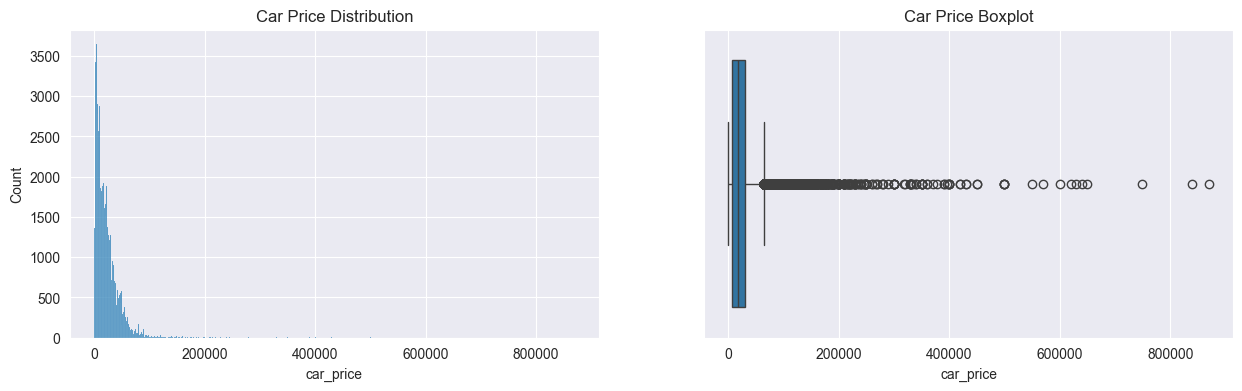

In [156]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='car_price', ax=axes[0]);
histplot.set_title('Car Price Distribution');
boxplot = sns.boxplot(data=data, x='car_price', ax=axes[1]);
boxplot.set_title('Car Price Boxplot');

We can notice a number of values detected after 200000 balance boarder. I'll have a closer look to cars that are above this limit.

In [157]:
data[data['car_price'] >= 200000]

engine_vol       car_make          model             make_model  awd  \
82626         2.9  Mercedes-Benz            GLS      Mercedes-Benz GLS    1   
82627         2.9  Mercedes-Benz            GLS      Mercedes-Benz GLS    0   
82630         2.0  Mercedes-Benz             SL       Mercedes-Benz SL    0   
82631         3.0        Porsche            911            Porsche 911    0   
82632        -1.0            BMW             i7                 BMW i7    1   
...           ...            ...            ...                    ...  ...   
82742         4.0        Ferrari  SF90 Stradale  Ferrari SF90 Stradale    0   
82743         6.7    Rolls-Royce       Cullinan   Rolls-Royce Cullinan    0   
82744         4.0        Ferrari  SF90 Stradale  Ferrari SF90 Stradale    0   
82745         4.0        Ferrari  SF90 Stradale  Ferrari SF90 Stradale    0   
82746         4.0        Ferrari    SF90 spider    Ferrari SF90 spider    0   

      category doors  hp  power  capacity  year  mileage  \
82626      NaN   NaN NaN    NaN       NaN  2022   2000.0   
82627      NaN   NaN NaN    NaN       NaN  2023   5000.0   
82630    Coupe   NaN NaN    NaN       NaN  2023  10000.0   
82631      NaN   NaN NaN    NaN       NaN  2020  12500.0   
82632      NaN   NaN NaN    NaN       NaN  2023     50.0   
...        ...   ...  ..    ...       ...   ...      ...   
82742      NaN   NaN NaN    NaN       NaN  2022   6000.0   
82743      NaN   NaN NaN  420.0       NaN  2022  15000.0   
82744      NaN   NaN NaN    NaN       NaN  2021   7000.0   
82745      NaN   NaN NaN    NaN       NaN  2022   1500.0   
82746    Coupe   NaN NaN    NaN       NaN  2023    100.0   

                      fuel_type gearbox_type         town  \
82626                    Diesel   Automaatti    Seinäjoki   
82627                  Bensiini   Automaatti        Lohja   
82630                  Bensiini   Automaatti       Vantaa   
82631                  Bensiini   Automaatti     Lempäälä   
82632                     Sähkö   Automaatti     Helsinki   
...                         ...          ...          ...   
82742  Hybridi (bensiini/sähkö)   Automaatti     Lempäälä   
82743                  Bensiini   Automaatti  Valkeakoski   
82744  Hybridi (bensiini/sähkö)   Automaatti        Vaasa   
82745  Hybridi (bensiini/sähkö)   Automaatti     Lempäälä   
82746  Hybridi (bensiini/sähkö)   Automaatti       Vantaa   

                          car_seller  car_price  
82626                     ferrain oy     208000  
82627                       carvista     208900  
82630                           veho     209600  
82631                         kesman     209800  
82632        scc - sports car center     209800  
...                              ...        ...  
82742  luxury collection automobiles     639900  
82743                   koskiauto oy     649000  
82744         prestige car center oy     749000  
82745  luxury collection automobiles     839900  
82746            bilbutiken helsinki     869800  

[106 rows x 17 columns]

There is 101 car which I can't mark as outlier as these cars are real and the price looks correct. Almost all of them are sport cars or luxury SUVs. 

Before applying methods for outliers detection we need to understand whether our data is normally distributed. There are several ways how to check it. Firstly, by simply looking at this histogram, we can tell the dataset does not exhibit a “bell-shape” and is not normally distributed. There is one more visual approach - a Q-Q plot.

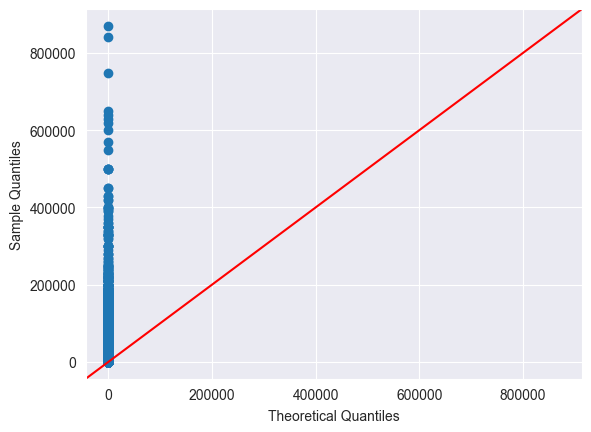

In [158]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(data['car_price'], line='45')
plt.show()

If the points on the plot fall roughly along a straight diagonal line, then we typically assume a dataset is normally distributed.
However, the points on this plot clearly don’t fall along the red line, so we would not assume that this dataset is normally distributed again.


In order to be sure I'll refer to non-visual tests. For example normaltest from Scipy library. This function tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.

In [159]:
stat, p = normaltest(data['car_price'])
print('stat=%.3f, p=%3f\n' % (stat, p))
if p > 0.05: #significance level is 0.05
    print('Probably Gaussian')
else: 
    print('Probably not Gaussian')

stat=95187.589, p=0.000000

Probably not Gaussian


Again, as expected, car price in the dataset is not distributed normally. However, we can make it distributed more 'normally'. For example, we can apply logarithm, square root or cube root to car price values.

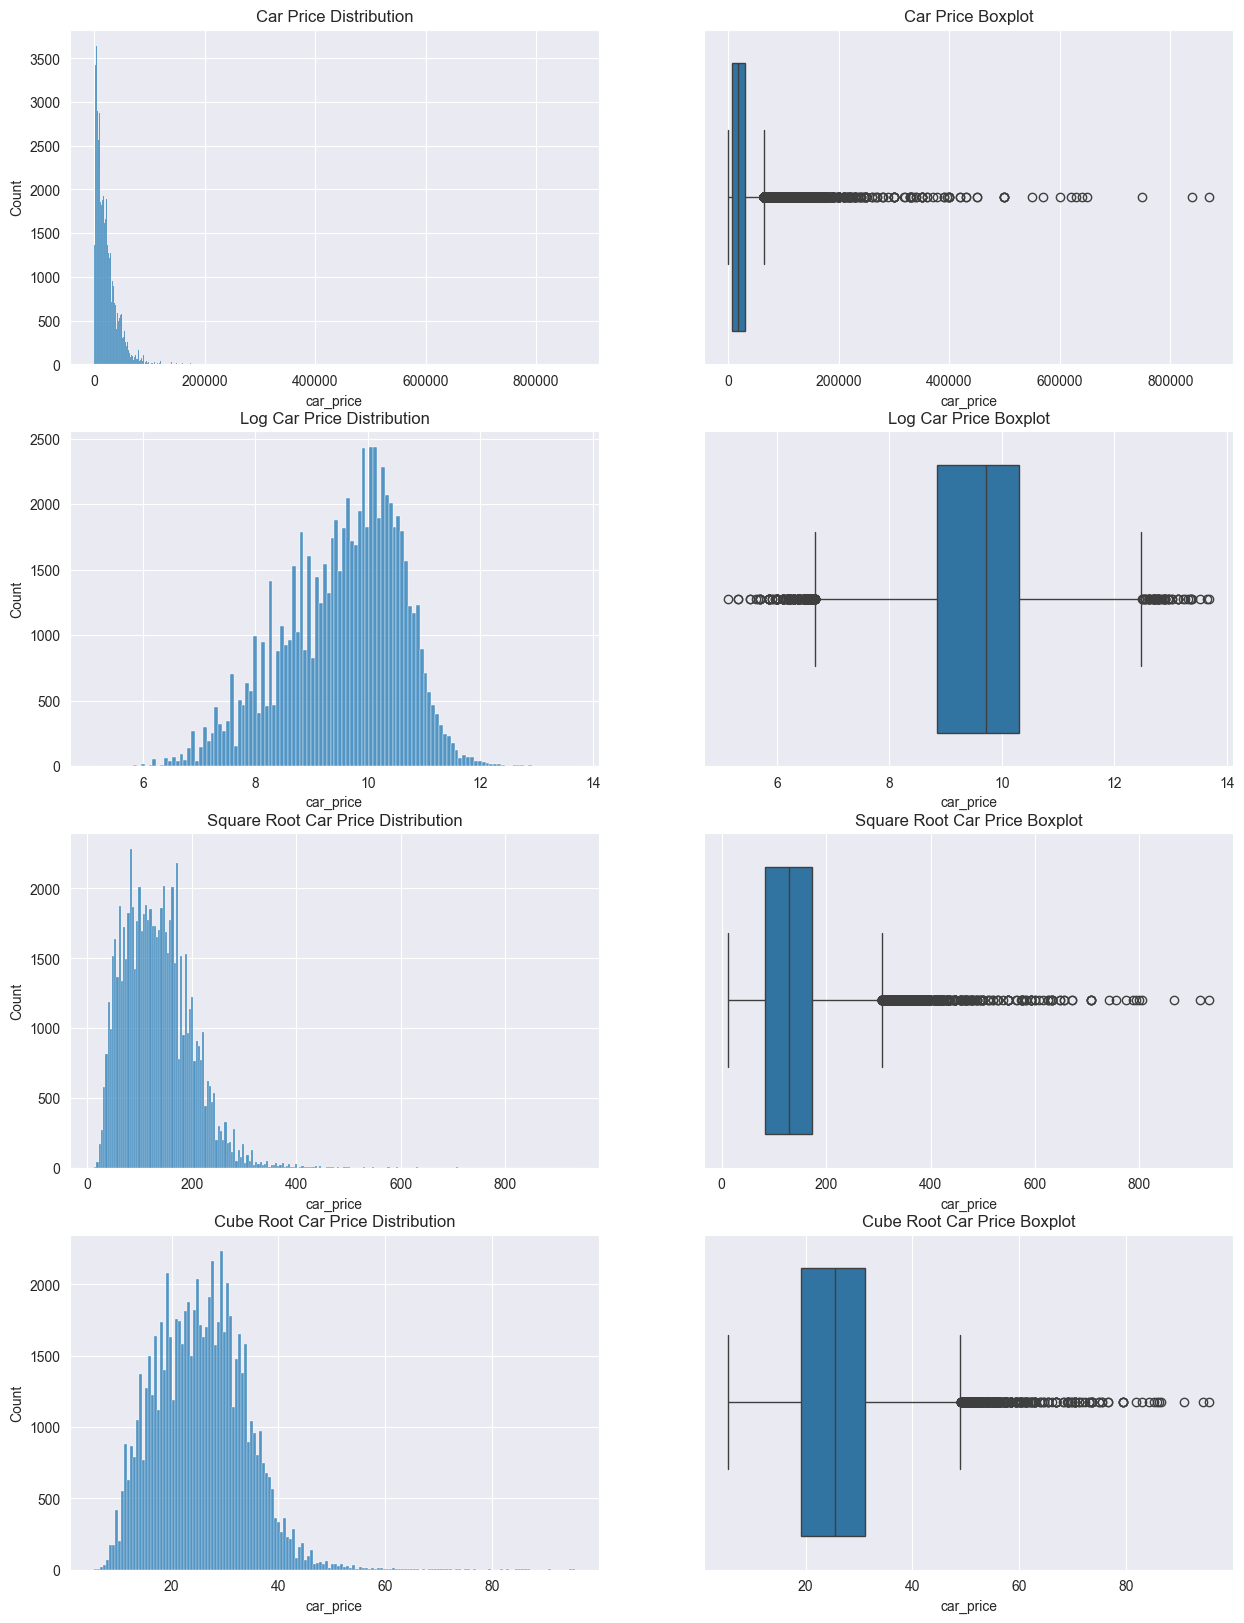

In [160]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
histplot = sns.histplot(data=data, x='car_price', ax=axes[0][0]);
histplot.set_title('Car Price Distribution');
boxplot = sns.boxplot(data=data, x='car_price', ax=axes[0][1]);
boxplot.set_title('Car Price Boxplot');
histplot_log = sns.histplot(data=data, x=np.log(data['car_price']), ax=axes[1][0]);
histplot_log.set_title('Log Car Price Distribution');
boxplot_log = sns.boxplot(data=data, x=np.log(data['car_price']), ax=axes[1][1]);
boxplot_log.set_title('Log Car Price Boxplot');
histplot_sq = sns.histplot(data=data, x=np.sqrt(data['car_price']), ax=axes[2][0]);
histplot_sq.set_title('Square Root Car Price Distribution');
boxplot_sq = sns.boxplot(data=data, x=np.sqrt(data['car_price']), ax=axes[2][1]);
boxplot_sq.set_title('Square Root Car Price Boxplot');
histplot_cb = sns.histplot(data=data, x=np.cbrt(data['car_price']), ax=axes[3][0]);
histplot_cb.set_title('Cube Root Car Price Distribution');
boxplot_cb = sns.boxplot(data=data, x=np.cbrt(data['car_price']), ax=axes[3][1]);
boxplot_cb.set_title('Cube Root Car Price Boxplot');

The 'bell curve' is more clear for log distribution, however, major part of outliers should be on the right side, so I'll choose cube root distribution to proceed with.

# 5. Outliers detection <a name="outliers"></a>

Now we can process outliers in 'car_price' feature. I'll use Inter quartile range method and Three-sigma method. 

### Interquartile range method

#### Method algorythm:

1. Calculate the 25th and 75th quantiles (1st and 3rd quartiles) - $Q_{25}$ and $Q_{75}$ for the reviewed feature.
2. Calculate interquartile distance: 
    * $IQR=Q_{75}-Q_{25}$
3. Determine the upper and lower Tukey bounds:

    * $bound_{upper} = Q_{75} + 1.5*IQR$
    
    * $bound_{lower} = Q_{25} - 1.5*IQR$
4. Find observations that are out of bounds

### Three-sigma method (Z-score)

Three-sigma method rule states that if the data distribution is normal, then 99.73% lie in the interval: $(\mu-3 \sigma$ , $\mu+3 \sigma)$, 
where  
* $\mu$ - mathematical expectation (in our case it is  mean value).
* $\sigma$ - standard deviation. 

Observations that lie outside this interval will be considered outliers.

#### **Method algorythm:**

1. Calculate mean and standard deviation of $\mu$ и $\sigma$ for the examined feature.
2. Define upper and lower bounds:
    * $bound_{upper} = \mu - 3 * \sigma$
    
    * $bound_{lower} = \mu + 3 * \sigma$
3. Find observations that are out of bounds.

I'll start with Interquartile range method.

In [161]:
def find_outliers_iqr(data, feature, left=1.5, right=1.5, sq_scale=False, cube_scale=False):
    """
    Finds outliers in data using the interquartile range method.
    The classic method is modified by adding:
    * Possibility of square and cube root distribution
    * manual control of the number of interquartile ranges in both directions of the distribution
    Args:
        data(pandas.DataFrame): dataset
        feature (str): name of the feature based on which outliers are searched
        left (float, optional): number of interquartile ranges to the left of the distribution. The default is 1.5.
        right (float, optional): number of interquartile ranges to the right side of the distribution. The default is 1.5.
        sq_scale (bool, optional): square root mode. Default is False - no square root is applied.
        cube_scale (bool, optional): cube root mode. Default is False - no cube root is applied.

    returns:
        pandas.DataFrame: outlier observations
        pandas.DataFrame: cleaned up data with outliers removed
    """
    if sq_scale:
        x = np.sqrt(data[feature])
    elif cube_scale:
        x = np.cbrt(data[feature])
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = find_outliers_iqr(data, 'car_price', cube_scale=True)

print(f'Number of outliers: {outliers.shape[0]}')
print(f'Remaining data (cleaned): {cleaned.shape[0]}')

Number of outliers: 487
Remaining data (cleaned): 74536


Now we can check how our cleaned data looks like.

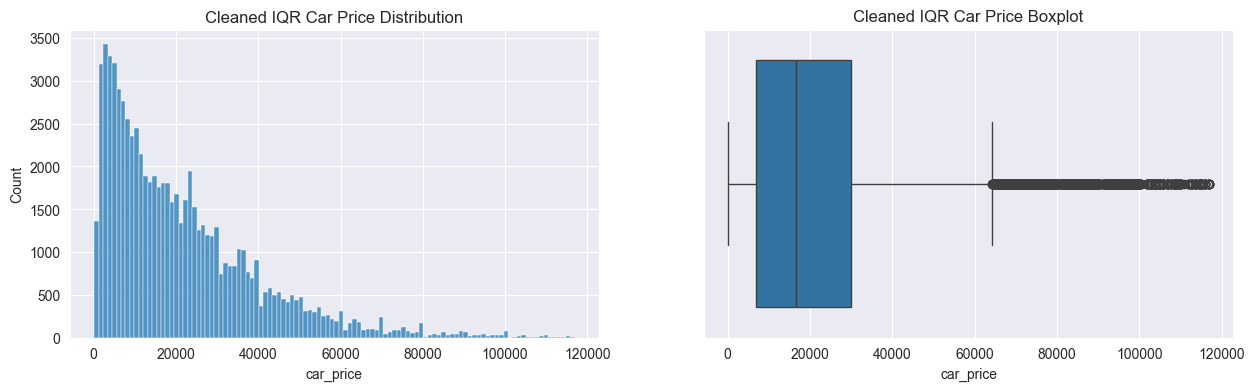

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='car_price', ax=axes[0]);
histplot.set_title('Cleaned IQR Car Price Distribution');
boxplot = sns.boxplot(data=cleaned, x='car_price', ax=axes[1]);
boxplot.set_title('Cleaned IQR Car Price Boxplot');

Now I'll apply Three sigma method:

In [163]:
def find_outliers_z_score(data, feature, left=3, right=3, sq_scale=False, cube_scale=False):
    """
    Finds outliers in data using the z-score method.
    The classic method is modified by adding:
    * Possibility of square and cube root distribution
    * manual control of the number of standard deviations in both sides of the distribution
    Args:
        data(pandas.DataFrame): dataset
        feature (str): name of the feature based on which outliers are searched
        left (float, optional): number of standard deviations to the left of the distribution. The default is 1.5.
        right (float, optional): number of standard to the right side of the distribution. The default is 1.5.
        sq_scale (bool, optional): square root mode. Default is False - no square root is applied.
        cube_scale (bool, optional): cube scale mode. Default is False - no logarithm is applied.

    returns:
        pandas.DataFrame: outlier observations
        pandas.DataFrame: cleaned up data with outliers removed
    """
    if sq_scale:
        x = np.sqrt(data[feature])
    elif cube_scale:
        x = np.cbrt(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers_z, cleaned_z = find_outliers_z_score(data, 'car_price', cube_scale=True)

print(f'Number of outliers: {outliers_z.shape[0]}')
print(f'Remaining data (cleaned): {cleaned_z.shape[0]}')

Number of outliers: 375
Remaining data (cleaned): 74648


Visualizing result as well.

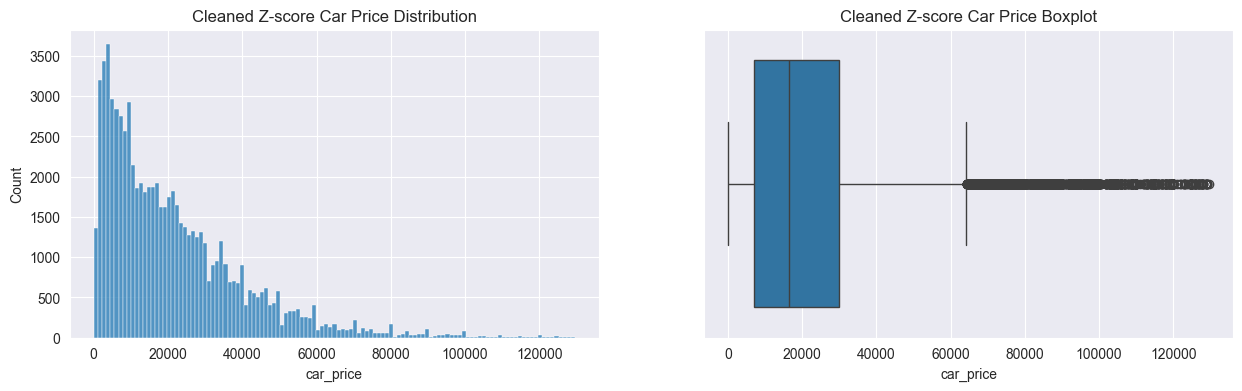

In [164]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_z, x='car_price', ax=axes[0]);
histplot.set_title('Cleaned Z-score Car Price Distribution');
boxplot = sns.boxplot(data=cleaned_z, x='car_price', ax=axes[1]);
boxplot.set_title('Cleaned Z-score Car Price Boxplot');

Additionally we can visualise how both methods worked. We can write a comprehensive function for that:

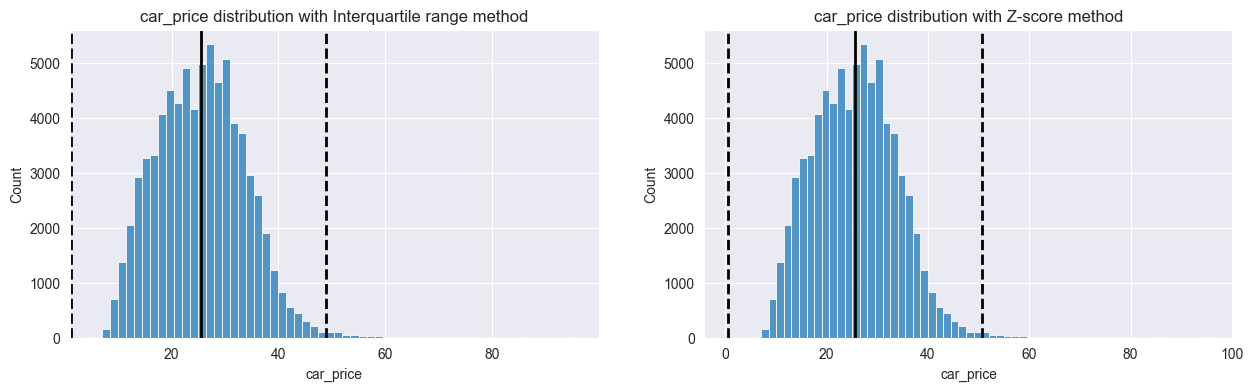

In [165]:
def outliers_iqr_z_visualize(df, feature, iqr_left=1.5, iqr_right=1.5, z_left=3, z_right=3, sq_scale=False, cube_scale=False):
    """
    Returns 2 histplots with indication of outliers using the interquartile range and z-score method.
    The classic method is modified by adding:
    * Possibility of square and cube root distribution
    * manual control of distribution borders
    Args:
        data(pandas.DataFrame): dataset
        feature (str): name of the feature based on which outliers are searched
        iqr_left (float, optional): number of interquartile ranges to the left of the distribution. The default is 1.5.
        iqr_right (float, optional): number of interquartile ranges to the right of the distribution. The default is 1.5.
        z_left (float, optional): number of standard deviations to the left of the distribution. The default is 3.
        z_right (float, optional): number of standard deviations to the right of the distribution. The default is 3.
        sq_scale (bool, optional): square root mode. Default is False - no square root is applied.       
        cube_scale (bool, optional): cube root mode. Default is False - no cube root is applied.

    returns:
        seaborn.histplot: outlier visualization for IQR method
        seaborn.histplot: outlier visualization for Z-score method
    """
    if sq_scale:
        key_feature = np.sqrt(df[feature])
    elif cube_scale:
        key_feature = np.cbrt(df[feature])
    else:
        key_feature = df[feature]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    histplot_iqr = sns.histplot(key_feature, bins=60, ax=ax[0]);
    histplot_iqr.axvline(key_feature.quantile(0.50), color='k', lw=2)
    histplot_iqr.axvline(
        (key_feature.quantile(0.25) - ((key_feature.quantile(0.75)-key_feature.quantile(0.25)) * iqr_left)), 
        color='k', 
        ls='--', 
        lw=2)
    histplot_iqr.axvline(
        (key_feature.quantile(0.75) + ((key_feature.quantile(0.75)-key_feature.quantile(0.25)) * iqr_right)), 
        color='k', 
        ls='--', 
        lw=2)
    histplot_iqr.set_title(f'{feature} distribution with Interquartile range method');

    histplot_z = sns.histplot(key_feature, bins=60, ax=ax[1])
    histplot_z.axvline(key_feature.mean(), color='k', lw=2)
    histplot_z.axvline(key_feature.mean() + z_right *key_feature.std(), color='k', ls='--', lw=2)
    histplot_z.axvline(key_feature.mean() - z_left *key_feature.std(), color='k', ls='--', lw=2)
    histplot_z.set_title(f'{feature} distribution with Z-score method');
    return histplot_iqr, histplot_z;
    

outliers_iqr_z_visualize(data, 'car_price', cube_scale=True);

Both methods worked fine. I'll proceed with Z-score method as it is less strict.

In [166]:
data_cleaned = cleaned_z

Column 'mileage' also requires check for outliers.

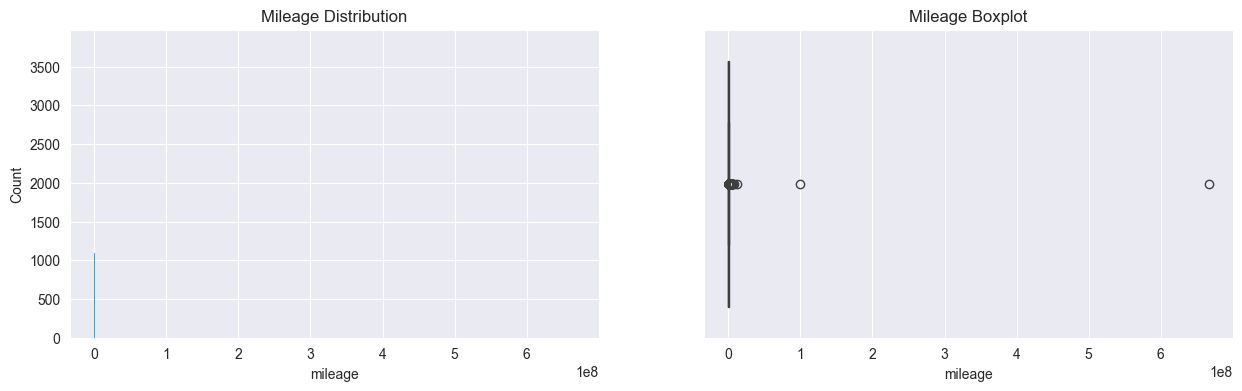

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data_cleaned, x='mileage', ax=axes[0]);
histplot.set_title('Mileage Distribution');
boxplot = sns.boxplot(data=data_cleaned, x='mileage', ax=axes[1]);
boxplot.set_title('Mileage Boxplot');


There are some obvious outliers. Let's look at the cars that have more than 1 million kilometers on odometer.

In [168]:
data_cleaned[data_cleaned['mileage'] >= 1000000]

engine_vol       car_make           model             make_model  awd  \
595           2.0         Toyota         Avensis         Toyota Avensis    0   
1004          1.0            Kia         Picanto            Kia Picanto    0   
1408          1.7           Opel           Astra             Opel Astra    0   
1552          1.9          Skoda        Roomster         Skoda Roomster    0   
1763          2.0          Mazda               6                Mazda 6    0   
1775          2.0           Audi              A6                Audi A6    0   
2492          1.9          Volvo             V40              Volvo V40    0   
2530          1.4        Citroen              C3             Citroen C3    0   
2948          2.0           Audi              A4                Audi A4    0   
3820          2.4          Volvo             S60              Volvo S60    0   
4845          1.6        Citroen              C5             Citroen C5    0   
5852          2.2  Mercedes-Benz               E        Mercedes-Benz E    0   
6613          2.5          Volvo             S70              Volvo S70    0   
6801          3.2           Audi              A6                Audi A6    1   
8279          2.3          Volvo             240              Volvo 240    0   
8620          2.0         Toyota         Corolla         Toyota Corolla    0   
10388         2.2        Citroen          Jumper         Citroen Jumper    0   
11340         1.8           Audi              A4                Audi A4    0   
11655         1.3     Volkswagen           Kupla       Volkswagen Kupla    0   
12004         2.8  Mercedes-Benz               E        Mercedes-Benz E    1   
13261         3.0            BMW              X5                 BMW X5    0   
13263         3.0            BMW              X5                 BMW X5    0   
13717         2.4          Volvo             S80              Volvo S80    0   
13773         1.8          Honda           Civic            Honda Civic    0   
14899         1.4           Opel           Corsa             Opel Corsa    0   
16035         3.7          Dodge            Dart             Dodge Dart    0   
16111         2.0           Ford          Galaxy            Ford Galaxy    0   
16360         3.2  Mercedes-Benz             CLK      Mercedes-Benz CLK    0   
19042         4.0         Toyota    Land Cruiser    Toyota Land Cruiser    0   
20884         4.0          Lexus              LS               Lexus LS    0   
23529         2.0     Volkswagen      Caddy Maxi  Volkswagen Caddy Maxi    0   
24256         3.0            BMW             330                BMW 330    0   
24273         0.8         Austin             NaN                Austin     0   
32332         2.2           Ford  Transit Custom    Ford Transit Custom    0   
33659         5.7      Chevrolet          Camaro       Chevrolet Camaro    0   
35389         2.5     Mitsubishi            L200        Mitsubishi L200    0   
40719         3.0  Mercedes-Benz           Viano    Mercedes-Benz Viano    0   
41260         2.0          Skoda         Octavia          Skoda Octavia    1   
42158         6.3       Plymouth            Fury          Plymouth Fury    0   
46106         2.8       Plymouth         Valiant       Plymouth Valiant    0   
54040         5.7      Chevrolet       Chevy Van    Chevrolet Chevy Van    0   
54946         7.4      Chevrolet        Corvette     Chevrolet Corvette    0   
58417         5.7           Ford           Coupe             Ford Coupe    0   

        category doors     hp  power  capacity  year      mileage fuel_type  \
595    Universal   NaN    NaN    NaN       NaN  2005    4500000.0    Diesel   
1004         NaN   4/5    NaN    NaN       NaN  2006    2690854.0  Bensiini   
1408         NaN   4/5    NaN    NaN       NaN  1999    3021490.0    Diesel   
1552         NaN   NaN    NaN    NaN       NaN  2007    4000000.0    Diesel   
1763         NaN   NaN    NaN    NaN       NaN  2009    2692900.0    Diesel   
1775        

Some values like 6666666666 or 12345678 are usually indicated in case if owner don't know or don't want to report car mileage. Other values above 1 million kilometers probably have extra digit entered by mistake. Anyway we are not interested in cars above 1 million km so we just delete them.

In [169]:
data_cleaned = data_cleaned[data_cleaned['mileage'] < 1000000]

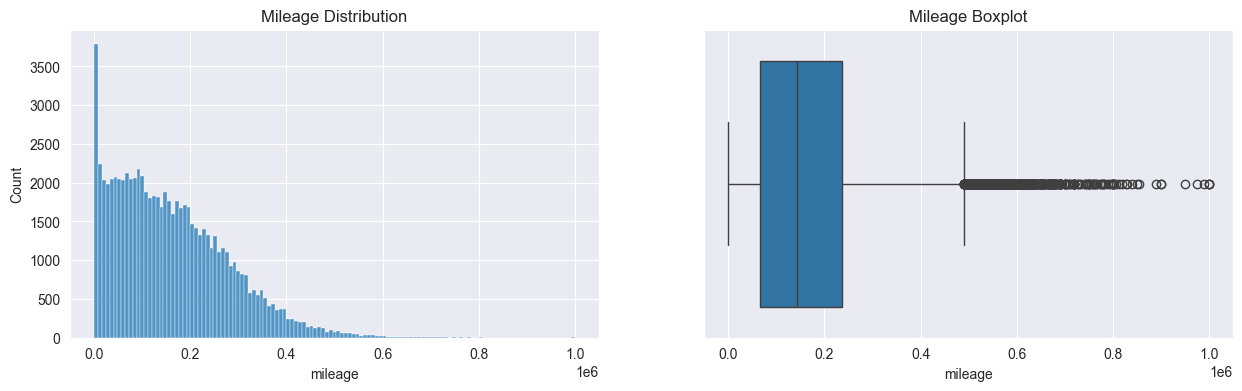

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data_cleaned, x='mileage', ax=axes[0]);
histplot.set_title('Mileage Distribution');
boxplot = sns.boxplot(data=data_cleaned, x='mileage', ax=axes[1]);
boxplot.set_title('Mileage Boxplot');

Again, distribution of mileage does not look as Gaussian. Let's do double check using scipy.normaltest again:

In [171]:
stat, p = normaltest(data_cleaned['mileage'])
print('stat=%.3f, p=%3f\n' % (stat, p))
if p > 0.05: #significance level is 0.05
    print('Probably Gaussian')
else: 
    print('Probably not Gaussian')

stat=9282.820, p=0.000000

Probably not Gaussian


Let's see if any method helps to distribute data normally.

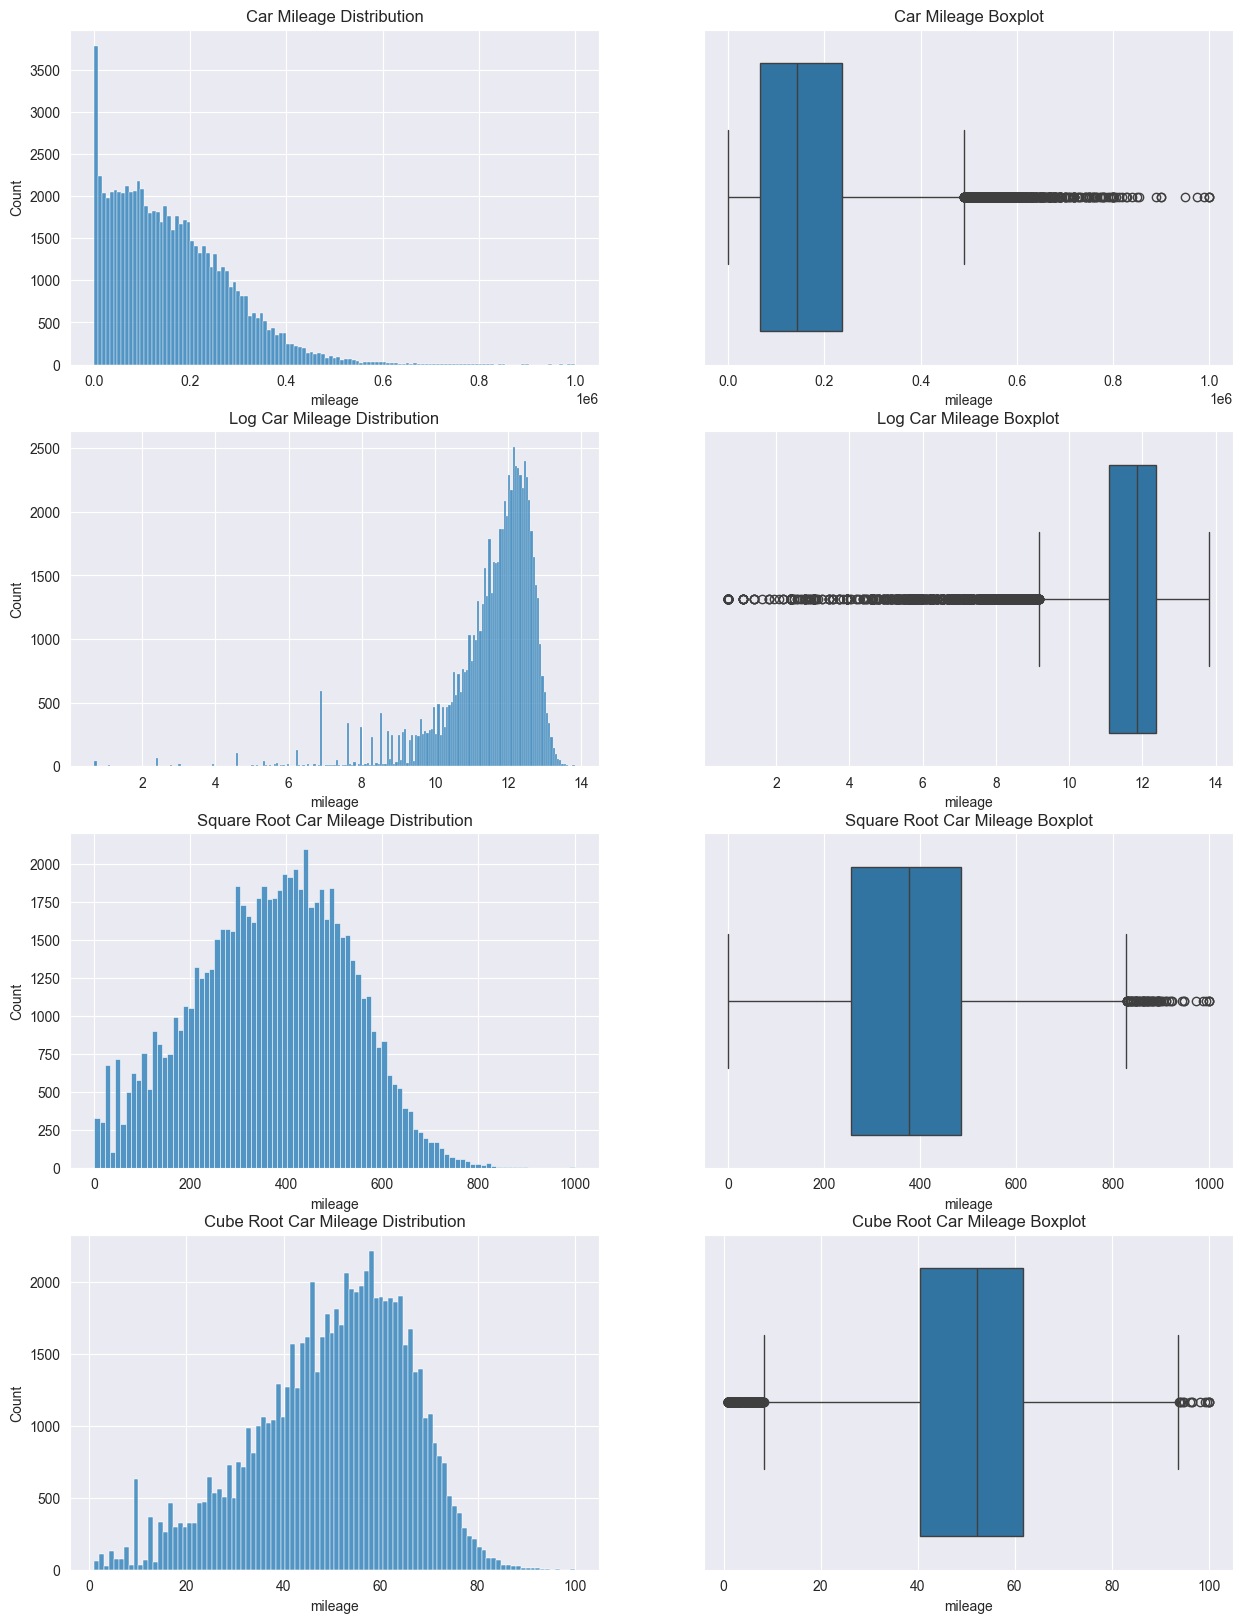

In [172]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
histplot = sns.histplot(data=data_cleaned, x='mileage', ax=axes[0][0]);
histplot.set_title('Car Mileage Distribution');
boxplot = sns.boxplot(data=data_cleaned, x='mileage', ax=axes[0][1]);
boxplot.set_title('Car Mileage Boxplot');
histplot_log = sns.histplot(data=data_cleaned, x=np.log(data_cleaned['mileage']+1), ax=axes[1][0]);
histplot_log.set_title('Log Car Mileage Distribution');
boxplot_log = sns.boxplot(data=data_cleaned, x=np.log(data_cleaned['mileage']+1), ax=axes[1][1]);
boxplot_log.set_title('Log Car Mileage Boxplot');
histplot_sq = sns.histplot(data=data_cleaned, x=np.sqrt(data_cleaned['mileage']), ax=axes[2][0]);
histplot_sq.set_title('Square Root Car Mileage Distribution');
boxplot_sq = sns.boxplot(data=data_cleaned, x=np.sqrt(data_cleaned['mileage']), ax=axes[2][1]);
boxplot_sq.set_title('Square Root Car Mileage Boxplot');
histplot_cb = sns.histplot(data=data_cleaned, x=np.cbrt(data_cleaned['mileage']), ax=axes[3][0]);
histplot_cb.set_title('Cube Root Car Mileage Distribution');
boxplot_cb = sns.boxplot(data=data_cleaned, x=np.cbrt(data_cleaned['mileage']), ax=axes[3][1]);
boxplot_cb.set_title('Cube Root Car Mileage Boxplot');

I think square root data is closest to Gaussian. Now we can visualize outliers.

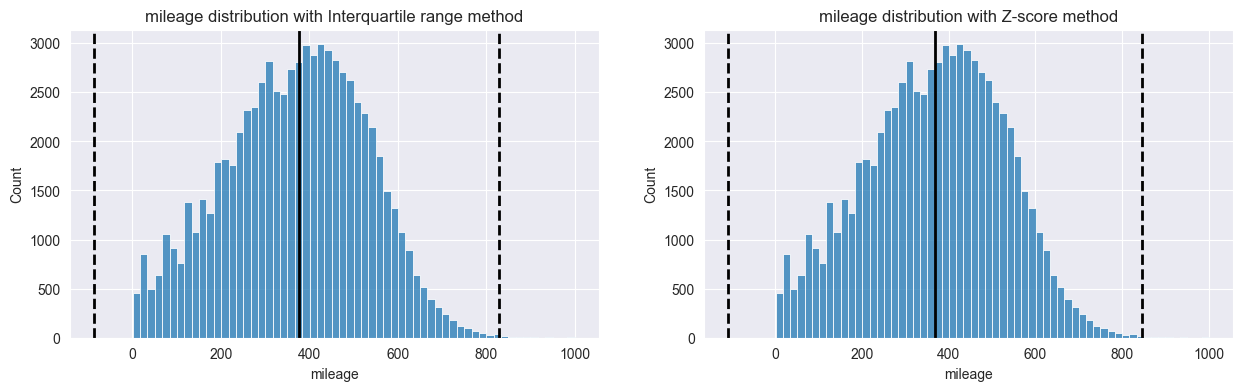

In [173]:
outliers_iqr_z_visualize(data_cleaned, 'mileage', sq_scale=True);

I'll select interquartile range method for outliers in 'mileage' feature.

In [174]:
outliers, cleaned = find_outliers_iqr(data_cleaned, 'mileage', sq_scale=True)

print(f'Number of outliers: {outliers.shape[0]}')
print(f'Remaining data (cleaned): {cleaned.shape[0]}')

Number of outliers: 75
Remaining data (cleaned): 74530


In [175]:
data_cleaned = cleaned

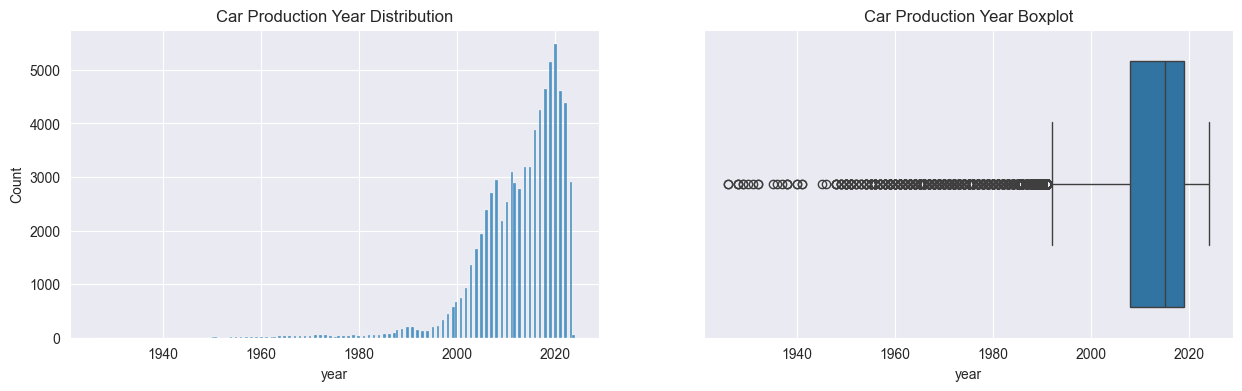

In [176]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data_cleaned, x='year', ax=axes[0]);
histplot.set_title('Car Production Year Distribution');
boxplot = sns.boxplot(data=data_cleaned, x='year', ax=axes[1]);
boxplot.set_title('Car Production Year Boxplot');

In [177]:
data_cleaned[data_cleaned['year'] < 1985]

engine_vol   car_make          model           make_model  awd  \
1286          1.3       Lada           2105            Lada 2105    0   
1575          1.5     Datsun        - Sunny       Datsun - Sunny    0   
1791          0.8     Suzuki           Alto          Suzuki Alto    0   
1937          1.6     Nissan         Cherry        Nissan Cherry    0   
2967          1.5       Saab             96              Saab 96    0   
...           ...        ...            ...                  ...  ...   
81023         8.1  Chevrolet       Chevelle   Chevrolet Chevelle    0   
81440         5.9      Dodge  Lil Red Truck  Dodge Lil Red Truck    0   
81744         2.2    Porsche            911          Porsche 911    0   
81782         6.4   Cadillac       Eldorado    Cadillac Eldorado    0   
81887         4.6  Chevrolet       Corvette   Chevrolet Corvette    0   

        category doors  hp  power  capacity  year   mileage fuel_type  \
1286       Sedan   4/5 NaN    NaN       NaN  1983   64000.0  Bensiini   
1575         NaN   NaN NaN    NaN       NaN  1984  150000.0  Bensiini   
1791         NaN   NaN NaN    NaN       NaN  1983  100000.0  Bensiini   
1937         NaN   NaN NaN    NaN       NaN  1982  161000.0  Bensiini   
2967       Sedan   2/3 NaN    NaN       NaN  1978   33052.0  Bensiini   
...          ...   ...  ..    ...       ...   ...       ...       ...   
81023        NaN   NaN NaN    NaN       NaN  1970   17600.0  Bensiini   
81440        NaN   NaN NaN    NaN       NaN  1979    8900.0  Bensiini   
81744      Coupe   NaN NaN    NaN       NaN  1970     123.0  Bensiini   
81782        NaN   NaN NaN    NaN       NaN  1959   89432.0  Bensiini   
81887  Cabriolet   NaN NaN    NaN       NaN  1959   85000.0  Bensiini   

      gearbox_type         town                    car_seller  car_price  
1286      Manuaali        Inari  marko teuvo johannes tiainen        950  
1575      Manuaali        Turku                     saku lemi       1000  
1791      Manuaali      Kajaani                 eetu moilanen       1100  
1937      Manuaali   Pudasjärvi                 janne partala       1200  
2967      Manuaali         Oulu               jorma tirkkonen       1500  
...            ...          ...                           ...        ...  
81023   Automaatti  Siilinjärvi                  tero hemming      83500  
81440   Automaatti     Helsinki                    tero ilola      90000  
81744     Manuaali        Turku                  ove´s garage      99800  
81782   Automaatti    Riihimäki                   sami kuutti      99900  
81887     Manuaali        Lohja                      carvista     104900  

[958 rows x 17 columns]

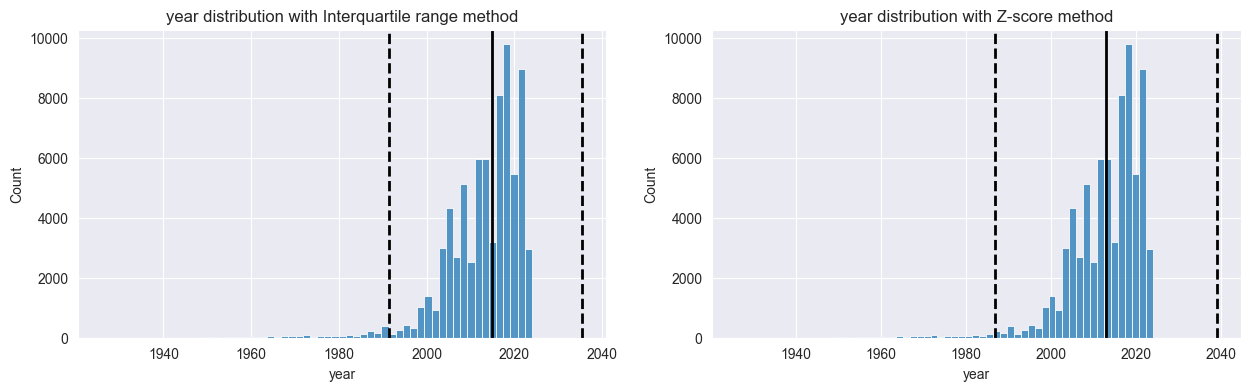

In [178]:
outliers_iqr_z_visualize(data_cleaned, 'year');

In [179]:
outliers_z, cleaned_z = find_outliers_z_score(data_cleaned, 'year')

print(f'Number of outliers: {outliers_z.shape[0]}')
print(f'Remaining data (cleaned): {cleaned_z.shape[0]}')

Number of outliers: 1097
Remaining data (cleaned): 73433


In [180]:
data_cleaned = cleaned_z

Finally, dropping duplicates

In [181]:
data_cleaned = data_cleaned.drop_duplicates()
data_cleaned.shape

(72953, 17)

In [182]:
data_cleaned = data_cleaned.reset_index(drop=True)

In [184]:
data_cleaned.to_csv('/Users/egor/Documents/best_car_deals_app/data/data_clean_outliers.csv')

# 6. Adding new data <a name="new_data"></a>

In [185]:
data = pd.read_csv('/Users/egor/Documents/best_car_deals_app/data/data_clean_outliers.csv', index_col=0)
data['make_model'] = data['make_model'].apply(lambda x: x.lower())

In features 'category', 'doors', 'hp', 'power' and 'capacity' we have more than 60% of NaN values. Usually such features are deleted but I'd like to fill this data from other sources.

In [186]:
data.isna().sum()

engine_vol          0
car_make            0
model               4
make_model          0
awd                 0
category        57466
doors           65139
hp              63673
power           63471
capacity        71262
year                0
mileage             0
fuel_type        1071
gearbox_type        0
town                0
car_seller          0
car_price           0
dtype: int64

For example, I've downloaded dataset from Kaggle with car characteristics. We can fill missing 'category' and 'doors' values in our dataset using it. Have a look.

In [190]:
cars = pd.read_csv('/Users/egor/Documents/best_car_deals_app/data/characteristics.csv', index_col=0)
cars

manufacturer            model   category    mileage  year gear_box_type  \
ID                                                                              
0           NISSAN             Juke       Jeep  111111111  2010     Tiptronic   
1          HYUNDAI         Santa FE       Jeep      88000  2013     Tiptronic   
2        CHEVROLET            Cruze      Sedan     140000  2013     Tiptronic   
3           TOYOTA            Prius      Sedan      71000  2013     Automatic   
4           SUZUKI     Grand Vitara       Jeep     155000  2008     Automatic   
...            ...              ...        ...        ...   ...           ...   
80120   ALFA ROMEO    Giulia Veloce      Sedan          0  2019     Automatic   
80121         FIAT              500  Hatchback          0  2019     Automatic   
80122         FIAT             Tipo      Sedan          0  2019        Manual   
80123         FIAT  Doblo Panorama   Universal          0  2019        Manual   
80124         FIAT       500X Cross       Jeep          0  2020     Tiptronic   

      doors           wheel            color interior_color  \
ID                                                            
0       4/5    Left wheel     Carnelian red          Black    
1       4/5    Left wheel              Grey          Black    
2       4/5    Left wheel            Silver          Black    
3       4/5    Left wheel              Grey          Black    
4       4/5    Left wheel              Grey          Black    
...     ...             ...              ...            ...   
80120   4/5    Left wheel               Red          Black    
80121   2/3    Left wheel             White           Grey    
80122   4/5    Left wheel             White           Grey    
80123   4/5    Left wheel             White          Black    
80124   4/5    Left wheel              Grey          Black    

                       vin  leather_interior deal_type             price  \
ID                                                                         
0       JN8AF5MV2BT011450                  1  For Sale              7300   
1                      NaN                 1  For Sale             13600   
2                      NaN                 1  For Sale  Price negotiable   
3                      NaN                 1  For Sale              6100   
4       JS3TD54V284130629                  0  For Sale              6377   
...                    ...               ...       ...               ...   
80120                  NaN                 1  For Sale  Price negotiable   
80121                  NaN                 0  For Sale  Price negotiable   
80122                  NaN                 0  For Sale  Price negotiable   
80123                  NaN                 0  For Sale  Price negotiable   
80124                  NaN                 0  For Sale  Price negotiable   

       customs  
ID              
0            0  
1            0  
2          640  
3            0  
4            0  
...        ...  
80120        0  
80121        0  
80122        0  
80123        0  
80124        0  

[80125 rows x 15 columns]

Firstly, we need to delete unnecessary columns, unify gear_box_type column and delete nan values.

In [191]:
cars = cars[['manufacturer', 'model', 'category', 'year', 'gear_box_type', 'doors']]
cars['make_model'] = cars['manufacturer'] + ' ' + cars['model']
cars['make_model'] = cars['make_model'].astype(str).apply(lambda x: x.lower())
cars['gear_box_type'] = cars['gear_box_type'].apply(
    lambda x: {'Automatic': 'Automaatti', 'Tiptronic': 'Automaatti', 'Manual': 'Manuaali', 'Variator': 'Automaatti'}.get(x)
)
cars = cars.drop(columns=['manufacturer', 'model'])
cars = cars.dropna()
cars

/var/folders/fg/7cyb3m_113j_1hkfwhtbsy8h0000gn/T/ipykernel_49279/3988033763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars['make_model'] = cars['manufacturer'] + ' ' + cars['model']
/var/folders/fg/7cyb3m_113j_1hkfwhtbsy8h0000gn/T/ipykernel_49279/3988033763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars['make_model'] = cars['make_model'].astype(str).apply(lambda x: x.lower())
/var/folders/fg/7cyb3m_113j_1hkfwhtbsy8h0000gn/T/ipykernel_49279/3988033763.py:4: SettingWithCopyWarning: 
A valu

category  year gear_box_type doors                make_model
ID                                                                  
0           Jeep  2010    Automaatti   4/5               nissan juke
1           Jeep  2013    Automaatti   4/5          hyundai santa fe
2          Sedan  2013    Automaatti   4/5           chevrolet cruze
3          Sedan  2013    Automaatti   4/5              toyota prius
4           Jeep  2008    Automaatti   4/5       suzuki grand vitara
...          ...   ...           ...   ...                       ...
80120      Sedan  2019    Automaatti   4/5  alfa romeo giulia veloce
80121  Hatchback  2019    Automaatti   2/3                  fiat 500
80122      Sedan  2019      Manuaali   4/5                 fiat tipo
80123  Universal  2019      Manuaali   4/5      fiat doblo panorama 
80124       Jeep  2020    Automaatti   4/5           fiat 500x cross

[77998 rows x 5 columns]

Another dataset that I've found is German used cars dataset. This dataset has information about horse powers which i need to fill in my dataset.

In [193]:
cars_hp = pd.read_csv('/Users/egor/Documents/best_car_deals_app/data/autoscout24-germany-dataset.csv')
cars_hp['make_model'] = cars_hp['make'] + ' ' + cars_hp['model']
cars_hp['make_model'] = cars_hp['make_model'].astype(str).apply(lambda x: x.lower())
cars_hp = cars_hp.drop(columns=['make', 'model', 'mileage', 'offerType', 'price'])

fuel_dict = {
    'Gasoline': 'Bensiini',
    'Electric/Gasoline': 'Hybridi (bensiini/sähkö)',
    'Electric': 'Sähkö',
    'LPG': 'Kaasu',
    'CNG': 'Kaasu',
    'Electric/Diesel': 'Hybridi (diesel/sähkö)',
    'Others': np.nan,
    '-/- (Fuel)': np.nan,
    'Ethanol': 'E85/bensiini',
    'Hydrogen': np.nan
}

cars_hp['fuel'] = cars_hp['fuel'].apply(lambda x: fuel_dict.get(x, x))

gear_dict = {
    'Manual': 'Manuaali',
    'Automatic': 'Automaatti',
    'Semi-automatic': np.nan
}

cars_hp['gear'] = cars_hp['gear'].apply(lambda x: gear_dict.get(x, x))
cars_hp = cars_hp.dropna()
cars_hp

fuel      gear     hp  year       make_model
0                        Diesel  Manuaali  116.0  2011          bmw 316
1                      Bensiini  Manuaali  122.0  2011  volkswagen golf
2                      Bensiini  Manuaali  160.0  2011        seat exeo
3                      Bensiini  Manuaali  110.0  2011   renault megane
4                      Bensiini  Manuaali  156.0  2011      peugeot 308
...                         ...       ...    ...   ...              ...
46400  Hybridi (bensiini/sähkö)  Manuaali   71.0  2021         fiat 500
46401  Hybridi (bensiini/sähkö)  Manuaali   71.0  2021         fiat 500
46402  Hybridi (bensiini/sähkö)  Manuaali   71.0  2021         fiat 500
46403  Hybridi (bensiini/sähkö)  Manuaali   71.0  2021         fiat 500
46404  Hybridi (bensiini/sähkö)  Manuaali   71.0  2021         fiat 500

[46071 rows x 5 columns]

We have reviewed both datasets that I plan to use. Now it's time to start filling the missing data. As we plan to merge dataframes, we need to choose unique set of features on which this merge will be done. Firstly, I'll use more precise grouping including 'make_model', 'year', 'gear' and 'fuel'. Further, I'll exclude 'year' from grouping. The target variables ('hp', 'category', etc.) will be aggregated as "mode" value.

In [194]:
cars_hp_grouped_year = cars_hp.groupby(by=['make_model', 'year', 'gear', 'fuel'], as_index=False)['hp'].agg(pd.Series.mode)
cars_hp_grouped = cars_hp.groupby(by=['make_model', 'gear', 'fuel'], as_index=False)['hp'].agg(pd.Series.mode)

In [195]:
data_grouped_year = data.groupby(by=['make_model', 'car_make', 'year', 'gearbox_type', 'fuel_type'], as_index=False)['engine_vol'].count()
data_grouped = data.groupby(by=['make_model', 'gearbox_type', 'fuel_type'], as_index=False)['engine_vol'].count()

In [196]:
data_joined_year = pd.merge(
    data_grouped_year,
    cars_hp_grouped_year, 
    how='left', 
    left_on=['make_model', 'year', 'fuel_type', 'gearbox_type'],
    right_on=['make_model', 'year', 'fuel', 'gear']
)

In [197]:
data_joined = pd.merge(
    data_joined_year,
    cars_hp_grouped, 
    how='left', 
    left_on=['make_model', 'fuel_type', 'gearbox_type'],
    right_on=['make_model', 'fuel', 'gear']
)

After merging dataframes we may get 2 columns with target: parsed value and joined value. In this case I apply a rule: if parsed value exists we keep it, if not we take joined value. 

In [198]:
data_joined['hp'] = np.where(data_joined['hp_x'].notna(), data_joined['hp_x'], data_joined['hp_y'])
data_joined['hp'] = data_joined['hp'].apply(lambda x: x if isinstance(x, float) else mean(x))
data_joined = data_joined.drop(columns=['engine_vol', 'gear_x', 'gear_y', 'fuel_x', 'fuel_y', 'hp_x', 'hp_y'])

data_joined_make = data_joined.groupby(by='car_make')['hp'].mean()

data_joined = pd.merge(
    data_joined,
    data_joined_make, 
    how='left', 
    on='car_make'
)

data_joined['hp'] = np.where(data_joined['hp_x'].notna(), data_joined['hp_x'], data_joined['hp_y'])
data_joined = data_joined.drop(columns=['car_make', 'hp_x', 'hp_y'])

Kilowatts could be easily converted into horse powers, so we add a rule: if horse power value is nan but power value exists we convert power into horse powers.

In [200]:
data = pd.merge(
    data,
    data_joined, 
    how='left', 
    on=['make_model', 'year', 'gearbox_type', 'fuel_type']
)
data['hp_x'] = np.where(data['hp_x'].notna(), data['hp_x'], data['power']/0.73549875)
data['hp_x'] = np.where(data['hp_x'] > 59, data['hp_x'], data['hp_y'])
data = data.drop(columns=['hp_y', 'power'])
data = data.rename(columns={'hp_x': 'hp'})

After merging datasets we can see that number of NaN vailues in 'hp' column decreased from 63673 to 1902.

In [203]:
data['hp'].isna().sum()

1902

Now we can group data by 'engine_vol', 'year', 'fuel_type', 'gearbox_type' and aggregate mean value of 'hp' to fill remaining Nan values.

In [204]:
hp_grouped = data.groupby(by=['engine_vol', 'year', 'fuel_type', 'gearbox_type'], as_index=False)['hp'].mean()
hp_grouped['hp'] = hp_grouped['hp'].apply(lambda x: x if isinstance(x, float) else np.nan if len(x)==0 else mean(x))

data = pd.merge(
    data,
    hp_grouped, 
    how='left', 
    on=['engine_vol', 'year', 'fuel_type', 'gearbox_type']
)
data['hp_x'] = np.where(data['hp_x'].notna(), data['hp_x'], data['hp_y'])
data = data.drop(columns=['hp_y'])
data = data.rename(columns={'hp_x': 'hp'})

NaN vailues in 'hp' column decreased from 1902 to 1095.

In [205]:
data['hp'].isna().sum()

1095

Additionally we can make grouping less strict if we group data only by 'engine_vol', 'fuel_type' and aggregate mean value of 'hp' to fill remaining Nan values.

In [206]:
hp_grouped_no_year = data.groupby(by=['engine_vol', 'fuel_type'], as_index=False)['hp'].mean()

data = pd.merge(
    data,
    hp_grouped_no_year, 
    how='left', 
    on=['engine_vol', 'fuel_type']
)
data['hp_x'] = np.where(data['hp_x'].notna(), data['hp_x'], data['hp_y'])
data = data.drop(columns=['hp_y'])
data = data.rename(columns={'hp_x': 'hp'})

NaN values in 'hp' column decreased from 1095 to 987.

In [207]:
data['hp'].isna().sum()

987

Finally filling remaining NaN values with mean.

In [208]:
data['hp'] = data['hp'].fillna(data['hp'].mean())

Moving forward. Now we need to fill 'category' and 'doors' features. Using the same techniques as with 'hp' feature. In case if mode value is equal for several categories they are aggregated as list with this categories. I take the first value from this list.

In [209]:
cars_categories = cars.groupby(by=['make_model'], as_index=False)[['doors', 'category']].agg(pd.Series.mode)

cars_categories['doors'] = cars_categories['doors'].apply(
    lambda x: x.replace(' ', '') if isinstance(x, str) else x.tolist()[0].replace(' ', '')
)

cars_categories['category'] = cars_categories['category'].apply(lambda x: x if isinstance(x, str) else x.tolist()[0])

In [210]:
data = pd.merge(
    data,
    cars_categories, 
    how='left', 
    on='make_model'
)

data['category_x'] = np.where(data['category_x'].notna(), data['category_x'], data['category_y'])

data['doors_x'] = np.where(data['doors_x'].notna(), data['doors_x'], data['doors_y'])

data = data.drop(columns=['category_y', 'doors_y'])
data = data.rename(columns={'category_x': 'category', 'doors_x': 'doors'})

In [211]:
category_door = cars.groupby(by=['category'], as_index=False)['doors'].agg(pd.Series.mode)
category_door['doors'] = category_door['doors'].apply(
    lambda x: x.replace(' ', ''))

door_category = cars.groupby(by=['doors'], as_index=False)['category'].agg(pd.Series.mode)
door_category['doors'] = door_category['doors'].apply(
    lambda x: x.replace(' ', ''))

data = pd.merge(
    data,
    category_door, 
    how='left', 
    on='category'
)

data['doors_x'] = np.where(data['doors_x'].notna(), data['doors_x'], data['doors_y'])

data = data.drop(columns=['doors_y'])
data = data.rename(columns={'doors_x': 'doors'})

data = pd.merge(
    data,
    door_category, 
    how='left', 
    on='doors'
)

data['category_x'] = np.where(data['category_x'].notna(), data['category_x'], data['category_y'])

data = data.drop(columns=['category_y'])
data = data.rename(columns={'category_x': 'category'})

data = pd.merge(
    data,
    category_door, 
    how='left', 
    on='category'
)

data['doors_x'] = np.where(data['doors_x'].notna(), data['doors_x'], data['doors_y'])

data = data.drop(columns=['doors_y'])
data = data.rename(columns={'doors_x': 'doors'})

NaN values in 'category' column decreased from 57466 to 19103. In 'doors' NaN values dropped from 65139 to 19103.

In [213]:
data[['category', 'doors']].isna().sum()

category    19103
doors       19103
dtype: int64

Finally filling 'category' by grouping on 'awd' and 'doors' could be filled with mode value.

In [214]:
awd_category = data.groupby(by=['awd'], as_index=False)['category'].agg(pd.Series.mode)

data = pd.merge(
    data,
    awd_category, 
    how='left', 
    on='awd'
)

data['category_x'] = np.where(data['category_x'].notna(), data['category_x'], data['category_y'])

data = data.drop(columns=['category_y'])
data = data.rename(columns={'category_x': 'category'})
data['doors'] = data['doors'].fillna('4/5')

I decided to create 'hp_cat' feature with categories. Also, 'capacity' values are important only for electric and hybrid cars, so I'm filling capacity values for other categories with 0.

In [216]:
def get_hp_cat(hp_value):
    if hp_value < 100:
        return 'low (less 100)'
    elif hp_value < 170:
        return 'medium (less 170)'
    elif hp_value < 270:
        return 'high (less 270)'
    else:
        return 'max (more 270)'
    
data['hp_cat'] = data['hp'].apply(get_hp_cat)

non_electric = data[(data['fuel_type'] == 'Bensiini') | (data['fuel_type'] == 'Diesel') | (data['fuel_type'] == 'Kaasu') | (data['fuel_type'] == 'E85/bensiini')].index

electric = data[(data['fuel_type'] == 'Hybridi (bensiini/sähkö)') | (data['fuel_type'] == 'Sähkö') | (data['fuel_type'] == 'Hybridi (diesel/sähkö)')].index

data.loc[non_electric, 'capacity'] = 0

electric_capacity = data[
    (data['fuel_type'] == 'Hybridi (bensiini/sähkö)') 
    | (data['fuel_type'] == 'Sähkö') 
    | (data['fuel_type'] == 'Hybridi (diesel/sähkö)')
].groupby(by='hp_cat')['capacity'].median()

data = pd.merge(
    data,
    electric_capacity, 
    how='left', 
    on='hp_cat'
)

data['capacity_x'] = np.where(data['capacity_x'].notna(), data['capacity_x'], data['capacity_y'])

data = data.drop(columns=['capacity_y'])
data = data.rename(columns={'capacity_x': 'capacity'})

We can also create additional feature with avg price category for each car company.

In [217]:
data['car_price'] = data['car_price'].astype('int')
temp = data.copy()
table = data.groupby(['car_make'])['car_price'].mean()
temp = temp.merge(table.reset_index(), how='left',on='car_make')
bins = [0,10000,20000,40000,125000]
cars_bin=['Budget','Medium','Highend','Luxury']
data['price_category'] = pd.cut(temp['car_price_y'],bins,right=False,labels=cars_bin)
data.head()

engine_vol       car_make     model         make_model  awd   category  \
0         2.0  Mercedes-Benz       GLC  mercedes-benz glc    1      Coupe   
1         2.2           Opel  Frontera      opel frontera    0       Jeep   
2         1.2           Fiat     Punto         fiat punto    0  Hatchback   
3         1.2           Fiat     Punto         fiat punto    0  Hatchback   
4         1.2           Ford    Fiesta        ford fiesta    0  Hatchback   

  doors          hp  capacity  year   mileage                 fuel_type  \
0   2/3  167.890533      50.0  2020   15000.0  Hybridi (bensiini/sähkö)   
1   4/5  128.565644       0.0  1999  398000.0                    Diesel   
2   4/5   69.000000       0.0  2001  248000.0                  Bensiini   
3   4/5   69.000000       0.0  2001  248303.0                  Bensiini   
4   2/3   82.000000       0.0  2000  155416.0                  Bensiini   

  gearbox_type          town            car_seller  car_price  \
0   Automaatti         Espoo                  veho      57800   
1     Manuaali       Kuusamo  automyynti haapasalo       3795   
2     Manuaali     Rovaniemi        kalle sarkioja        170   
3     Manuaali       Kajaani     aleksi jokelainen        200   
4     Manuaali  Lappeenranta         petri anttila        200   

              hp_cat price_category  
0  medium (less 170)        Highend  
1  medium (less 170)         Medium  
2     low (less 100)         Budget  
3     low (less 100)         Budget  
4     low (less 100)         Medium

Some cars are sold by individuals, others are sold by car companies. I'll mark them as categorical.

In [218]:
seller_count = data.groupby(by='car_seller', as_index=False)['awd'].count()
company_tags = [' oy', 'tmi ', '.fi', 't:mi ', ' ky', '.com', ' ab', 'oy ', ' oü']

def is_company(sample_string, company_tags):
    for tag in company_tags:
        if tag in sample_string:
            return 1
    return 0

seller_count['is_company'] = seller_count['car_seller'].apply(lambda x: is_company(x, company_tags))
seller_count['is_company_cnt'] = seller_count['awd'].apply(lambda x: 1 if x>4 else 0)
seller_count['is_company'] = np.where(seller_count['is_company'] != 0, seller_count['is_company'], seller_count['is_company_cnt'])

data = pd.merge(
    data,
    seller_count[['car_seller', 'is_company']], 
    how='left', 
    on='car_seller'
)

As per cities where cars are sold we can add 'city_category' feature to check if price depends on population. But before we need to add data regarding population which could be obtained from Finland’s free-of-charge statistical databases like statfin.stat.fi.:

In [220]:
population = pd.read_excel('/Users/egor/Documents/best_car_deals_app/data/001_11lj_2023m08_20231024-194749.xlsx')
population = population.dropna(
    subset=['Unnamed: 1', 'Unnamed: 2']).reset_index(drop=True).drop(
    columns='Preliminary population structure by Month, Area and Information').rename(
    columns={'Unnamed: 1': 'town', 'Unnamed: 2': 'population'})

population['population'] = population['population'].astype(int)

data = pd.merge(
    data,
    population, 
    how='left', 
    on='town'
)

data['population'] = data['population'].fillna(data['population'].median()) 

Making population feature categorical may be useful for EDA.

In [221]:
def get_city_cat(population):
    if population <= 6000:
        return 'Very small (0-6k)'
    elif population <= 20000:
        return 'Small (6k-20k)'
    elif population <= 50000:
        return 'Medium (20-50k)'
    elif population <= 100000:
        return 'Big (50-100k)'
    else:
        return 'Biggest (more 100k)'
    
data['town_category'] = data['population'].apply(get_city_cat)
data['town_category'].value_counts()

town_category
Biggest (more 100k)    28575
Medium (20-50k)        17628
Big (50-100k)          16477
Small (6k-20k)          8220
Very small (0-6k)       2053
Name: count, dtype: int64

Applying correct data types:

In [222]:
data['mileage'] = data['mileage'].astype(int)
data['hp'] = data['hp'].astype(int)
data['capacity'] = data['capacity'].astype(int)

Creating car age feature:

In [223]:
curr_time = datetime.datetime.now()
data['age'] = data['year'].apply(lambda x: curr_time.year - x)
data['age'] = data['age'].apply(lambda x: 0 if x==-1 else x)

Finally dropping all rows with NaN values.

In [225]:
data = data.dropna()

In [226]:
data.to_csv('/Users/egor/Documents/best_car_deals_app/data/data_clean_outliers_new.csv')

# 7. EDA <a name="eda"></a>

In [227]:
data = pd.read_csv('/Users/egor/Documents/best_car_deals_app/data/data_clean_outliers_new.csv', index_col=0)

Let's see which car makes are most popular in Finland on market:

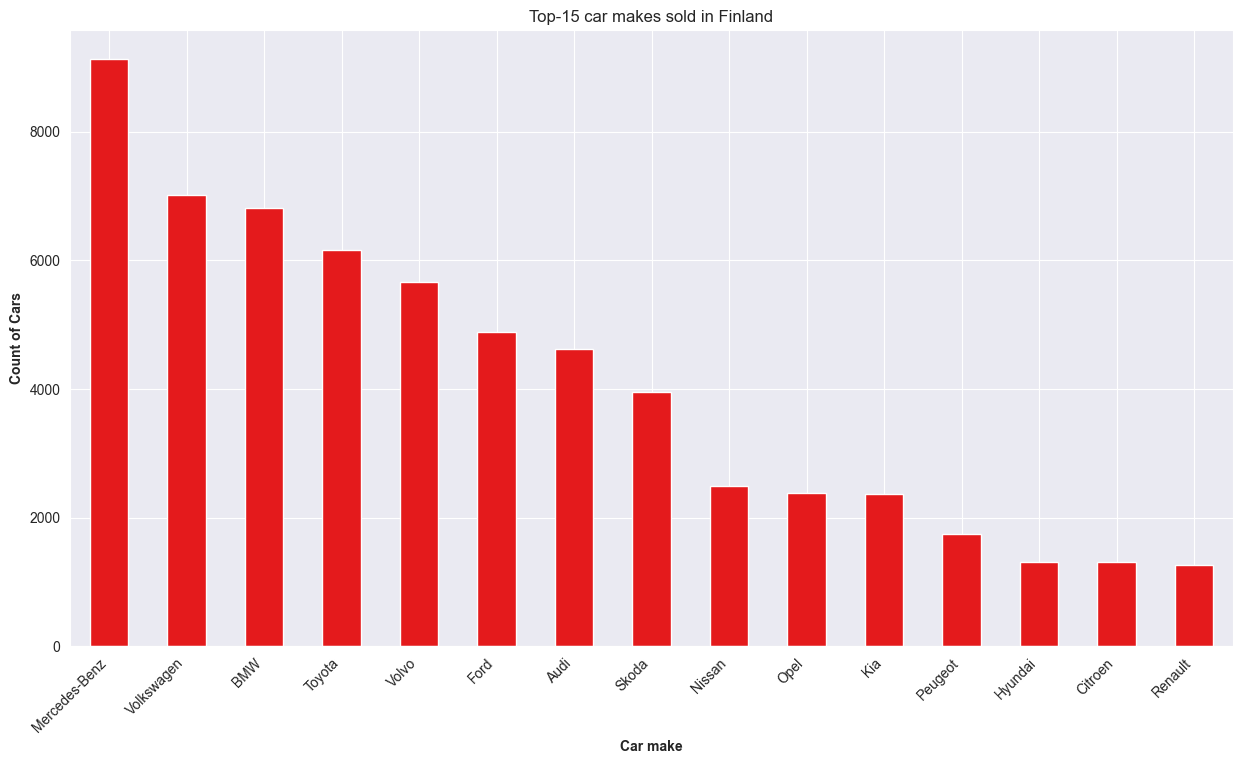

In [228]:
plt.rcParams['figure.figsize'] = [15, 8]
ax = data['car_make'].value_counts().head(15).plot(kind='bar',stacked=True, colormap = 'Set1')
ax.title.set_text('Top-15 car makes sold in Finland')
plt.xlabel("Car make",fontweight = 'bold')
plt.ylabel("Count of Cars",fontweight = 'bold')
plt.xticks(rotation=45, ha='right');

Most popular models are:

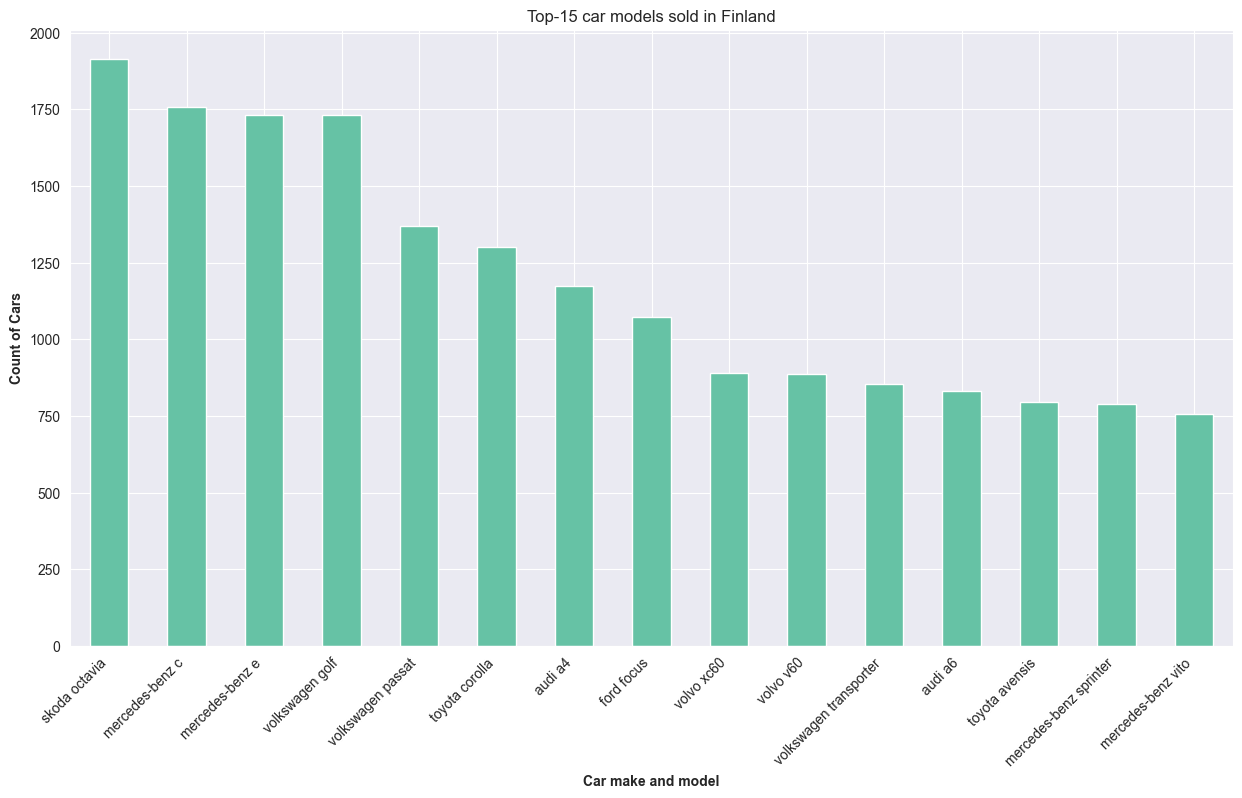

In [229]:
plt.rcParams['figure.figsize'] = [15, 8]
ax = data['make_model'].value_counts().head(15).plot(kind='bar',stacked=True, colormap = 'Set2')
ax.title.set_text('Top-15 car models sold in Finland')
plt.xlabel("Car make and model",fontweight = 'bold')
plt.ylabel("Count of Cars",fontweight = 'bold')
plt.xticks(rotation=45, ha='right');

Surprisingly Skoda Octavia is the leader on the used car market. Also there is no single BMW in the top 15 sold car models.

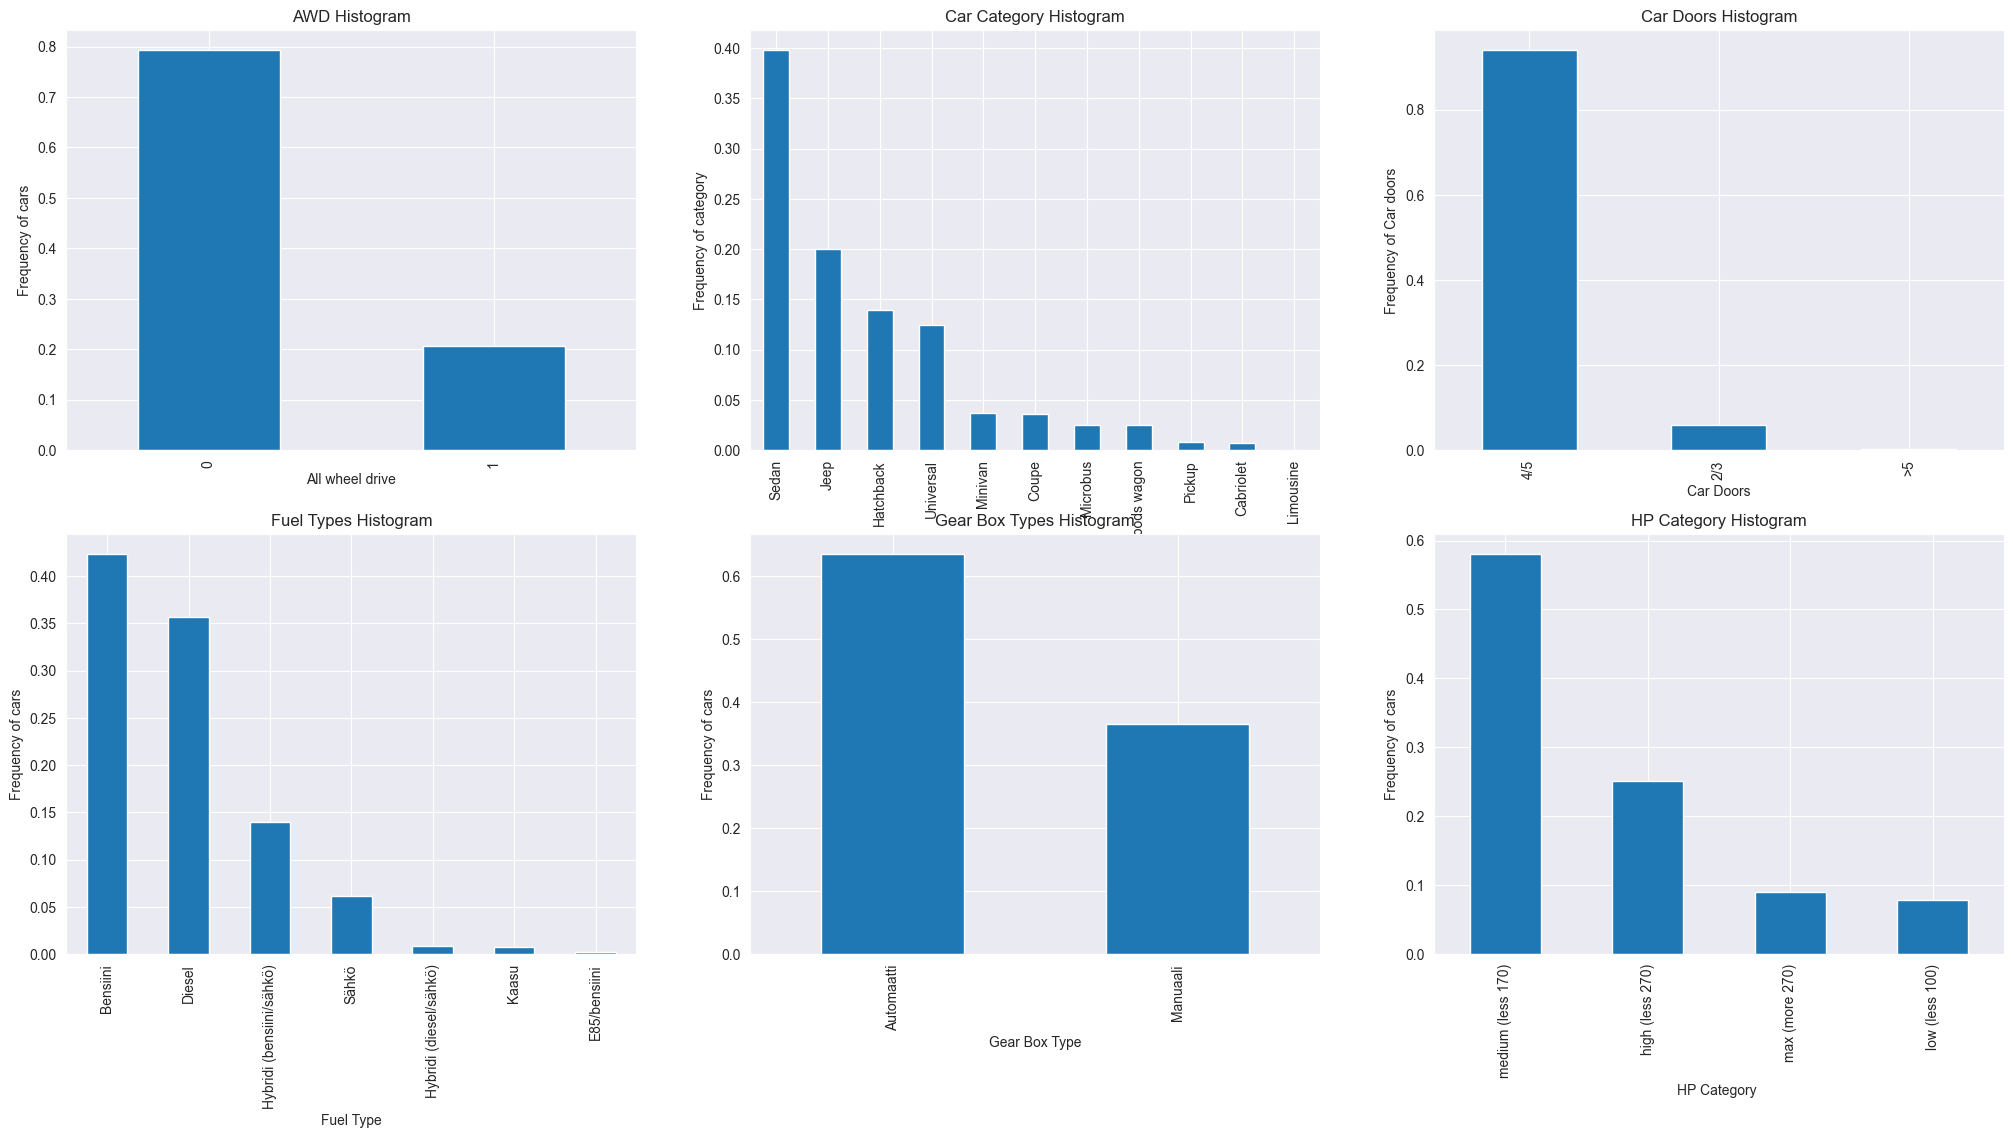

In [230]:
plt.figure(figsize=(25, 12))

plt.subplot(2,3,1)
plt1 = data.awd.value_counts(normalize=True).plot(kind='bar')
plt.title('AWD Histogram')
plt1.set(xlabel = 'All wheel drive', ylabel='Frequency of cars')

plt.subplot(2,3,2)
plt1 = data.category.value_counts(normalize=True).plot(kind='bar')
plt.title('Car Category Histogram')
plt1.set(xlabel = 'Category', ylabel='Frequency of category')

plt.subplot(2,3,3)
plt1 = data.doors.value_counts(normalize=True).plot(kind='bar')
plt.title('Car Doors Histogram')
plt1.set(xlabel = 'Car Doors', ylabel='Frequency of Car doors')

plt.subplot(2,3,4)
plt1 = data.fuel_type.value_counts(normalize=True).plot(kind='bar')
plt.title('Fuel Types Histogram')
plt1.set(xlabel = 'Fuel Type', ylabel='Frequency of cars')

plt.subplot(2,3,5)
plt1 = data.gearbox_type.value_counts(normalize=True).plot(kind='bar')
plt.title('Gear Box Types Histogram')
plt1.set(xlabel = 'Gear Box Type', ylabel='Frequency of cars')

plt.subplot(2,3,6)
plt1 = data.hp_cat.value_counts(normalize=True).plot(kind='bar')
plt.title('HP Category Histogram')
plt1.set(xlabel = 'HP Category ', ylabel='Frequency of cars')

plt.show()

Inference:
- only each 5th car is AWD
- 1 out of 3 cars have manual transmission
- 75% of cars are diesel and gasoline. Hybrid and electric cars have only 22% of the market. 
- more than 90% of cars have 4/5 doors
- 60% cars have from 100 to 170 horse power

Now let's review our target parameter in comparison with other features.

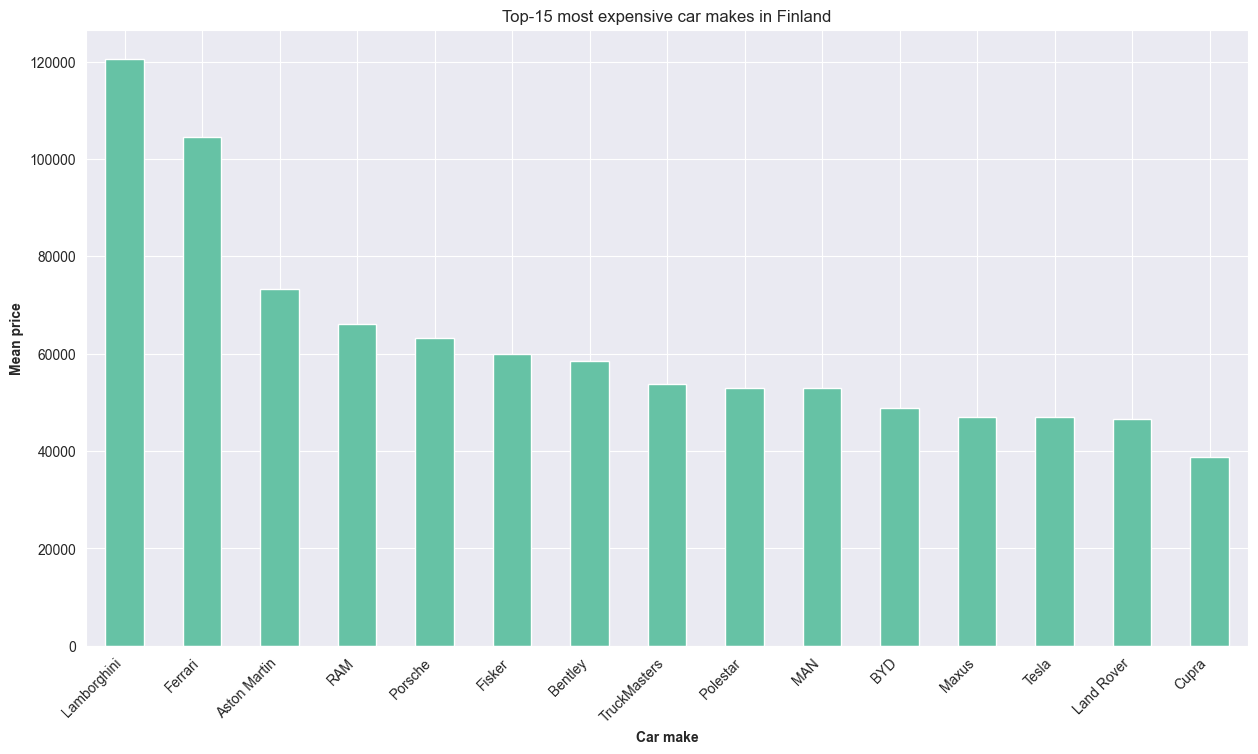

In [231]:
plt.rcParams['figure.figsize'] = [15, 8]
ax = data.groupby(
    'car_make'
)['car_price'].mean().sort_values(ascending=False).head(15).plot(
    kind='bar',stacked=True, colormap = 'Set2')
ax.title.set_text('Top-15 most expensive car makes in Finland')
plt.xlabel("Car make",fontweight = 'bold')
plt.ylabel("Mean price",fontweight = 'bold')
plt.xticks(rotation=45, ha='right');

Car makes that produce highend cars tend to cost more then budget or medium car makes. Which seems obvious.

/var/folders/fg/7cyb3m_113j_1hkfwhtbsy8h0000gn/T/ipykernel_49279/450311322.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data.price_category, y=data.car_price, palette=("cubehelix"))


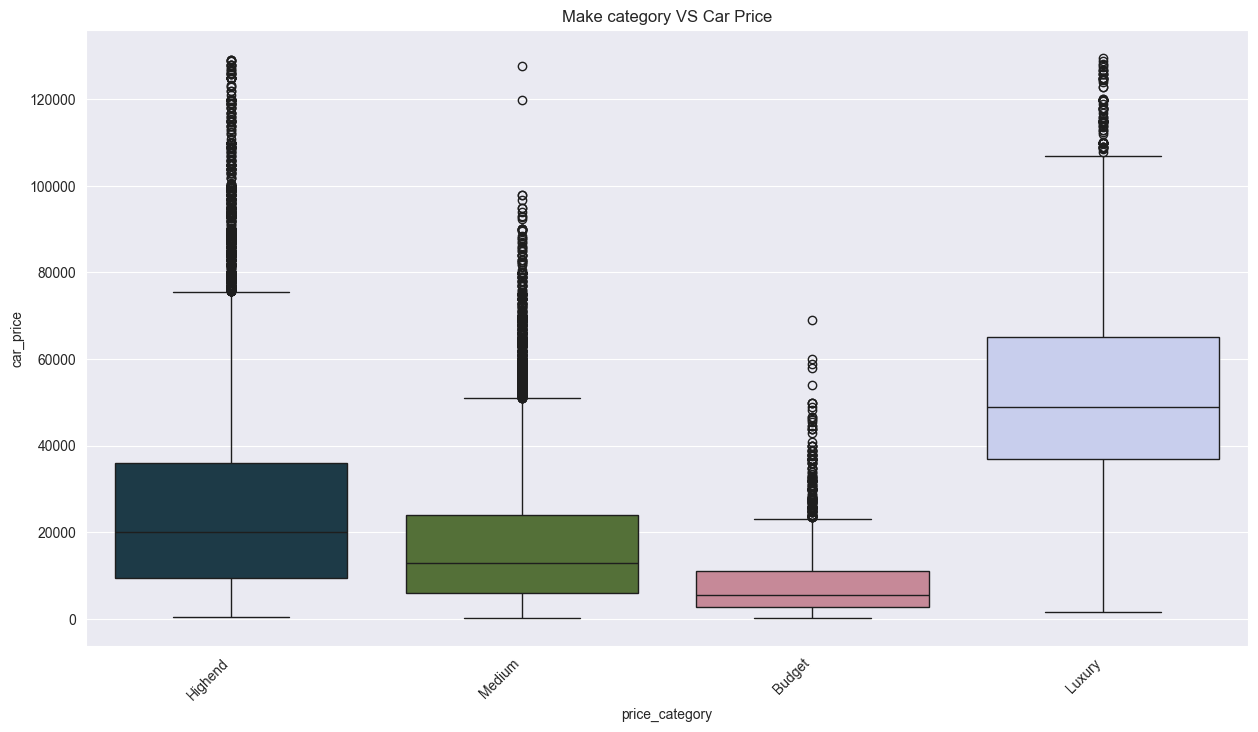

In [232]:
plt.figure(figsize=(15, 8))

plt.title('Make category VS Car Price')
sns.boxplot(x=data.price_category, y=data.car_price, palette=("cubehelix"))
plt1.set(xlabel = 'Price category', ylabel='Car price')
plt.xticks(rotation=45, ha='right');

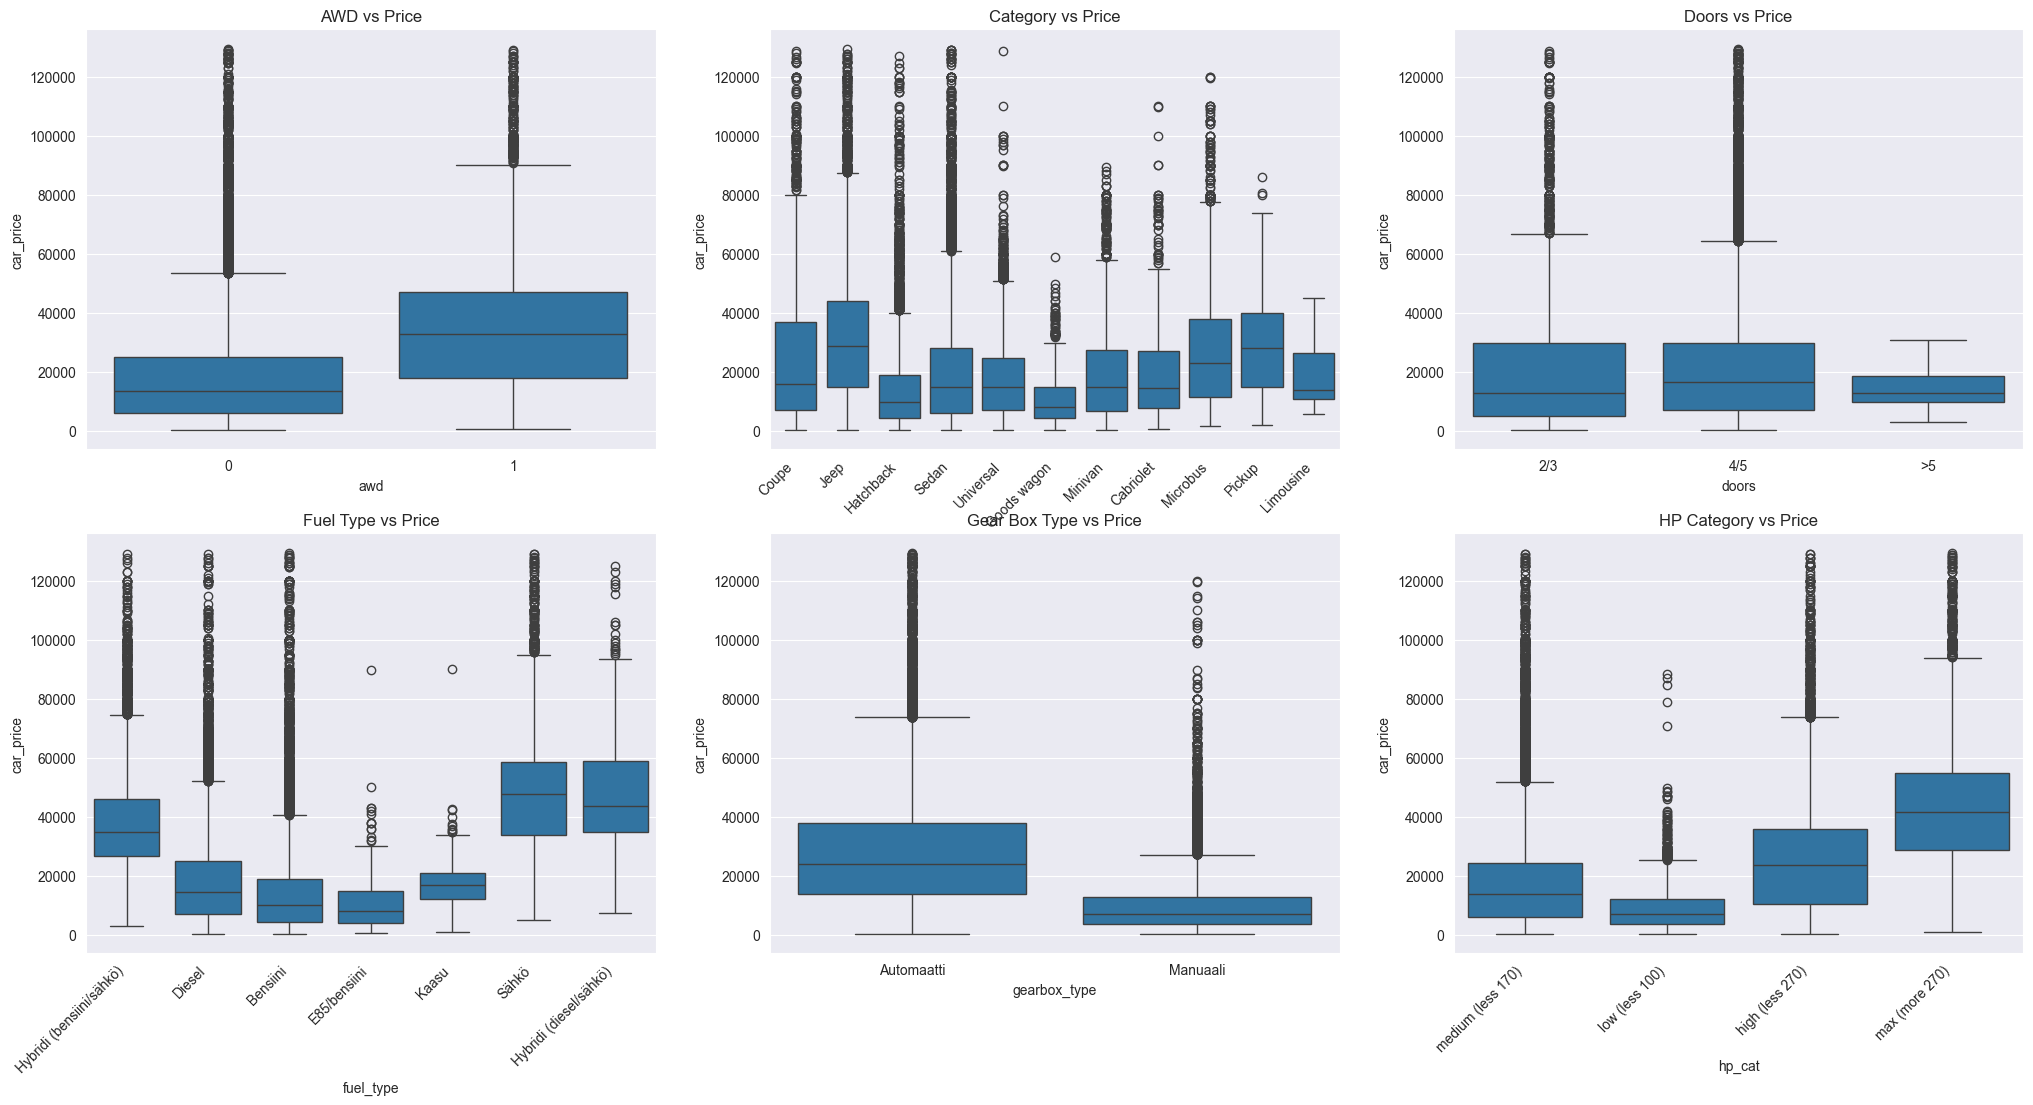

In [236]:
plt.figure(figsize=(25, 12))

plt.subplot(2,3,1)
plt.title('AWD vs Price')
sns.boxplot(x=data.awd, y=data.car_price)
plt1.set(xlabel = 'All wheel drive', ylabel='Price')

plt.subplot(2,3,2)
plt.title('Category vs Price')
sns.boxplot(x=data.category, y=data.car_price)
plt1.set(xlabel = 'Category', ylabel='Price')
plt.xticks(rotation=45, ha='right');

plt.subplot(2,3,3)
plt.title('Doors vs Price')
sns.boxplot(x=data.doors, y=data.car_price)
plt1.set(xlabel = 'Car Doors', ylabel='Price')

plt.subplot(2,3,4)
plt.title('Fuel Type vs Price')
sns.boxplot(x=data.fuel_type, y=data.car_price)
plt1.set(xlabel = 'Fuel Type', ylabel='Price')
plt.xticks(rotation=45, ha='right');

plt.subplot(2,3,5)
plt.title('Gear Box Type vs Price')
sns.boxplot(x=data.gearbox_type, y=data.car_price)
plt1.set(xlabel = 'Gear Box Type', ylabel='Price')

plt.subplot(2,3,6)
plt.title('HP Category vs Price')
sns.boxplot(x=data.hp_cat, y=data.car_price)
plt1.set(xlabel = 'HP Category', ylabel='Price')

plt.xticks(rotation=45, ha='right')
plt.show();

Inference:
- Cars with AWD cost more than FWR or RWD cars
- Price for jeeps, pickups and microbuses is higher than for other categories
- There is no significant difference between 2/3 and 4/5 doors cars pricing
- Horse powers are in direct ratio with car price. More horse power means more expensive car

Hybrid and electric cars price is higher probably due to the fact that technology is rather new and cars having electric engines are younger than cars with internal combustion engines (let's check it)

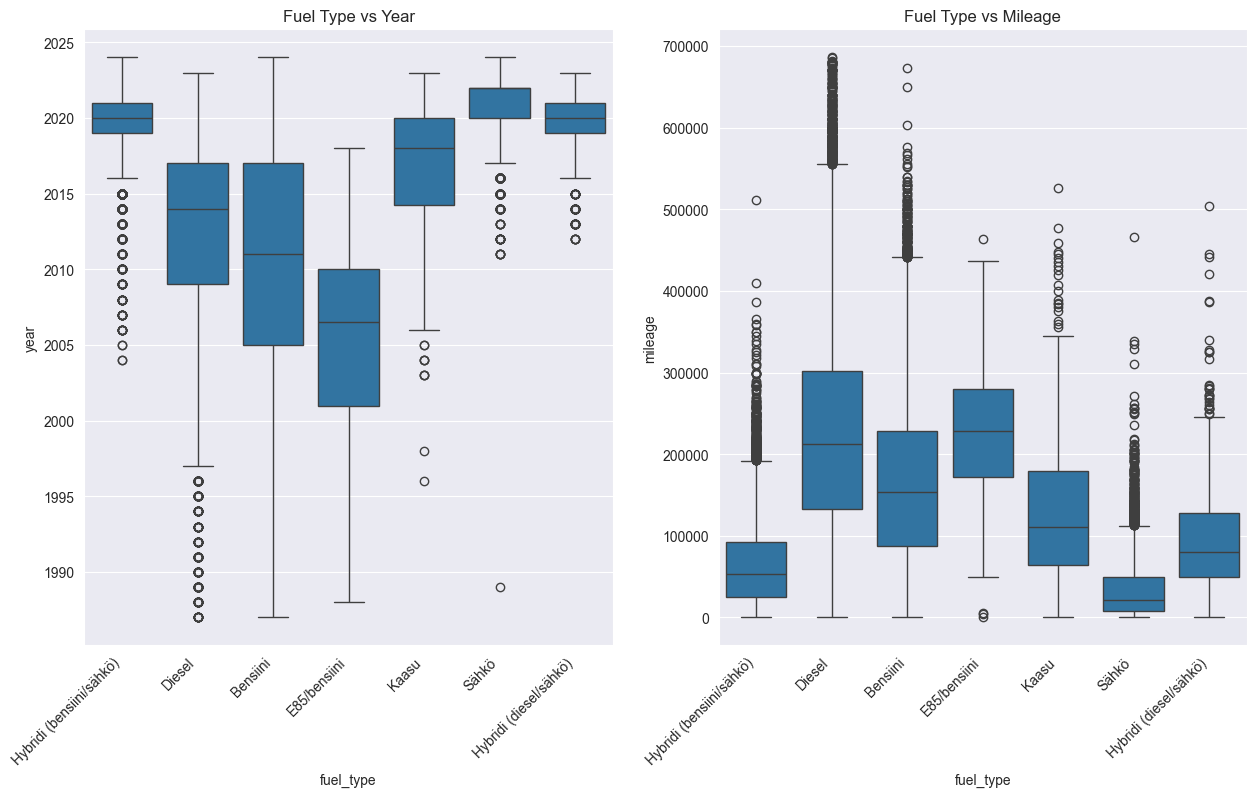

In [238]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
plt.title('Fuel Type vs Year')
sns.boxplot(x=data.fuel_type, y=data.year)
plt1.set(xlabel = 'Fuel Type', ylabel='Year')
plt.xticks(rotation=45, ha='right');

plt.subplot(1,2,2)
plt.title('Fuel Type vs Mileage')
sns.boxplot(x=data.fuel_type, y=data.mileage)
plt1.set(xlabel = 'Fuel Type', ylabel='Mileage')
plt.xticks(rotation=45, ha='right');

plt.show()

Yes, our assumption was correct: electric and hybrid cars have appeared in 21 century therefore such cars are younger and less driven so median price for them is higher. 

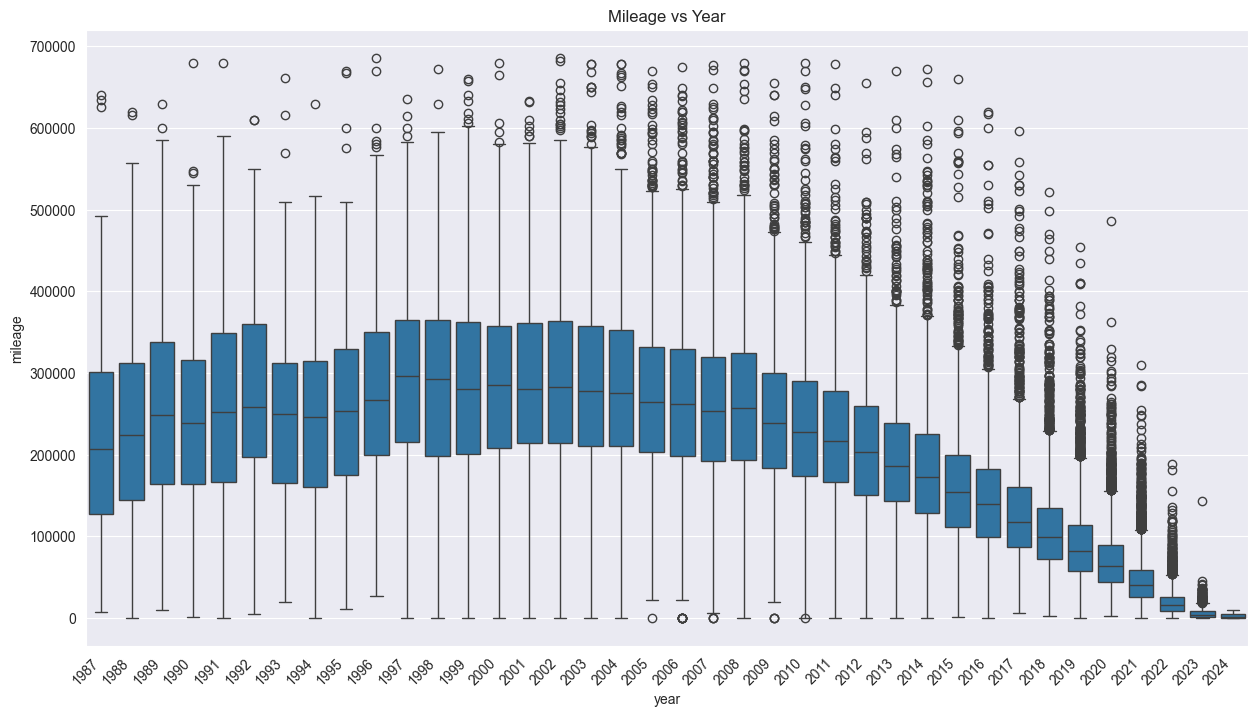

In [239]:
plt.figure(figsize=(15, 8))
plt.title('Mileage vs Year')
sns.boxplot(x=data.year, y=data.mileage)
plt1.set(xlabel = 'Year', ylabel='Mileage in km')
plt.xticks(rotation=45, ha='right');

It seems logically correct that older cars have more mileage. However, we can see such trend only after 1997-2001. Cars produced before 1997 sometimes have fewer km on odometer in comparison to year 2000. 

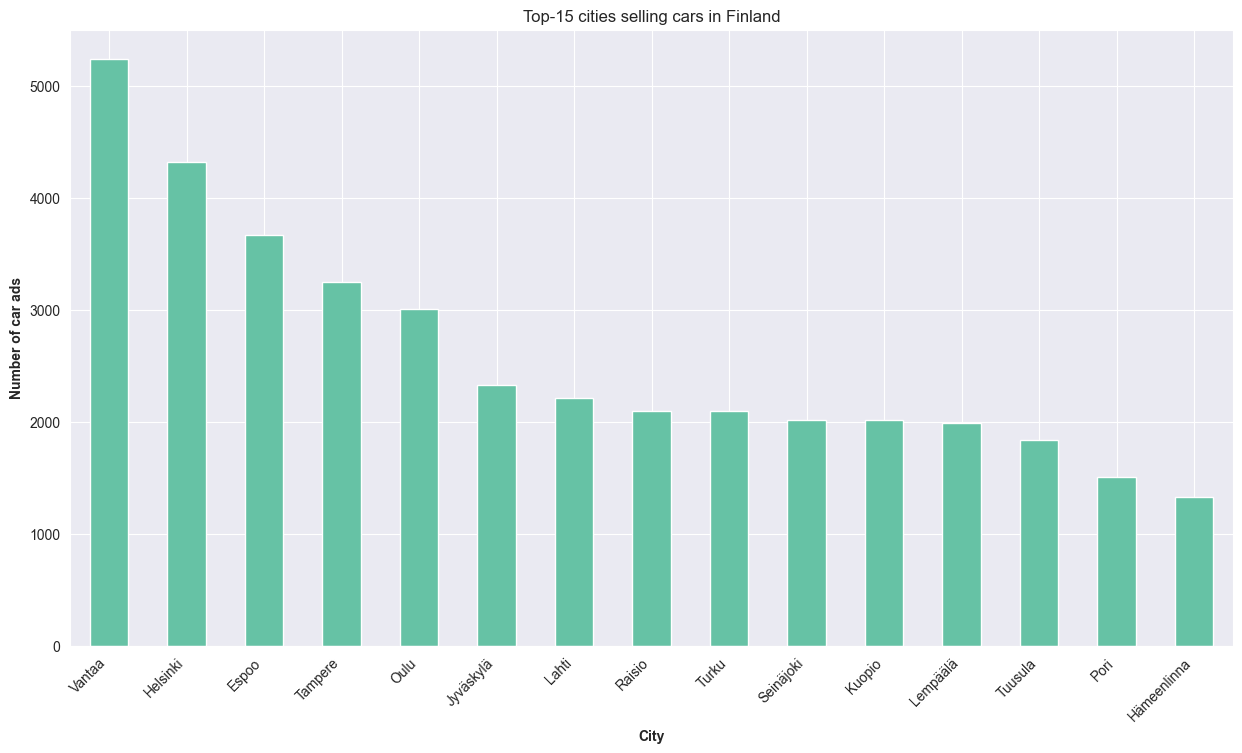

In [240]:
plt.rcParams['figure.figsize'] = [15, 8]
ax = data.groupby(
    by='town')['year'].count().sort_values(
    ascending=False).head(15).plot(
    kind='bar',stacked=True, colormap = 'Set2')
ax.title.set_text('Top-15 cities selling cars in Finland')
plt.xlabel("City",fontweight = 'bold')
plt.ylabel("Number of car ads",fontweight = 'bold')
plt.xticks(rotation=45, ha='right');

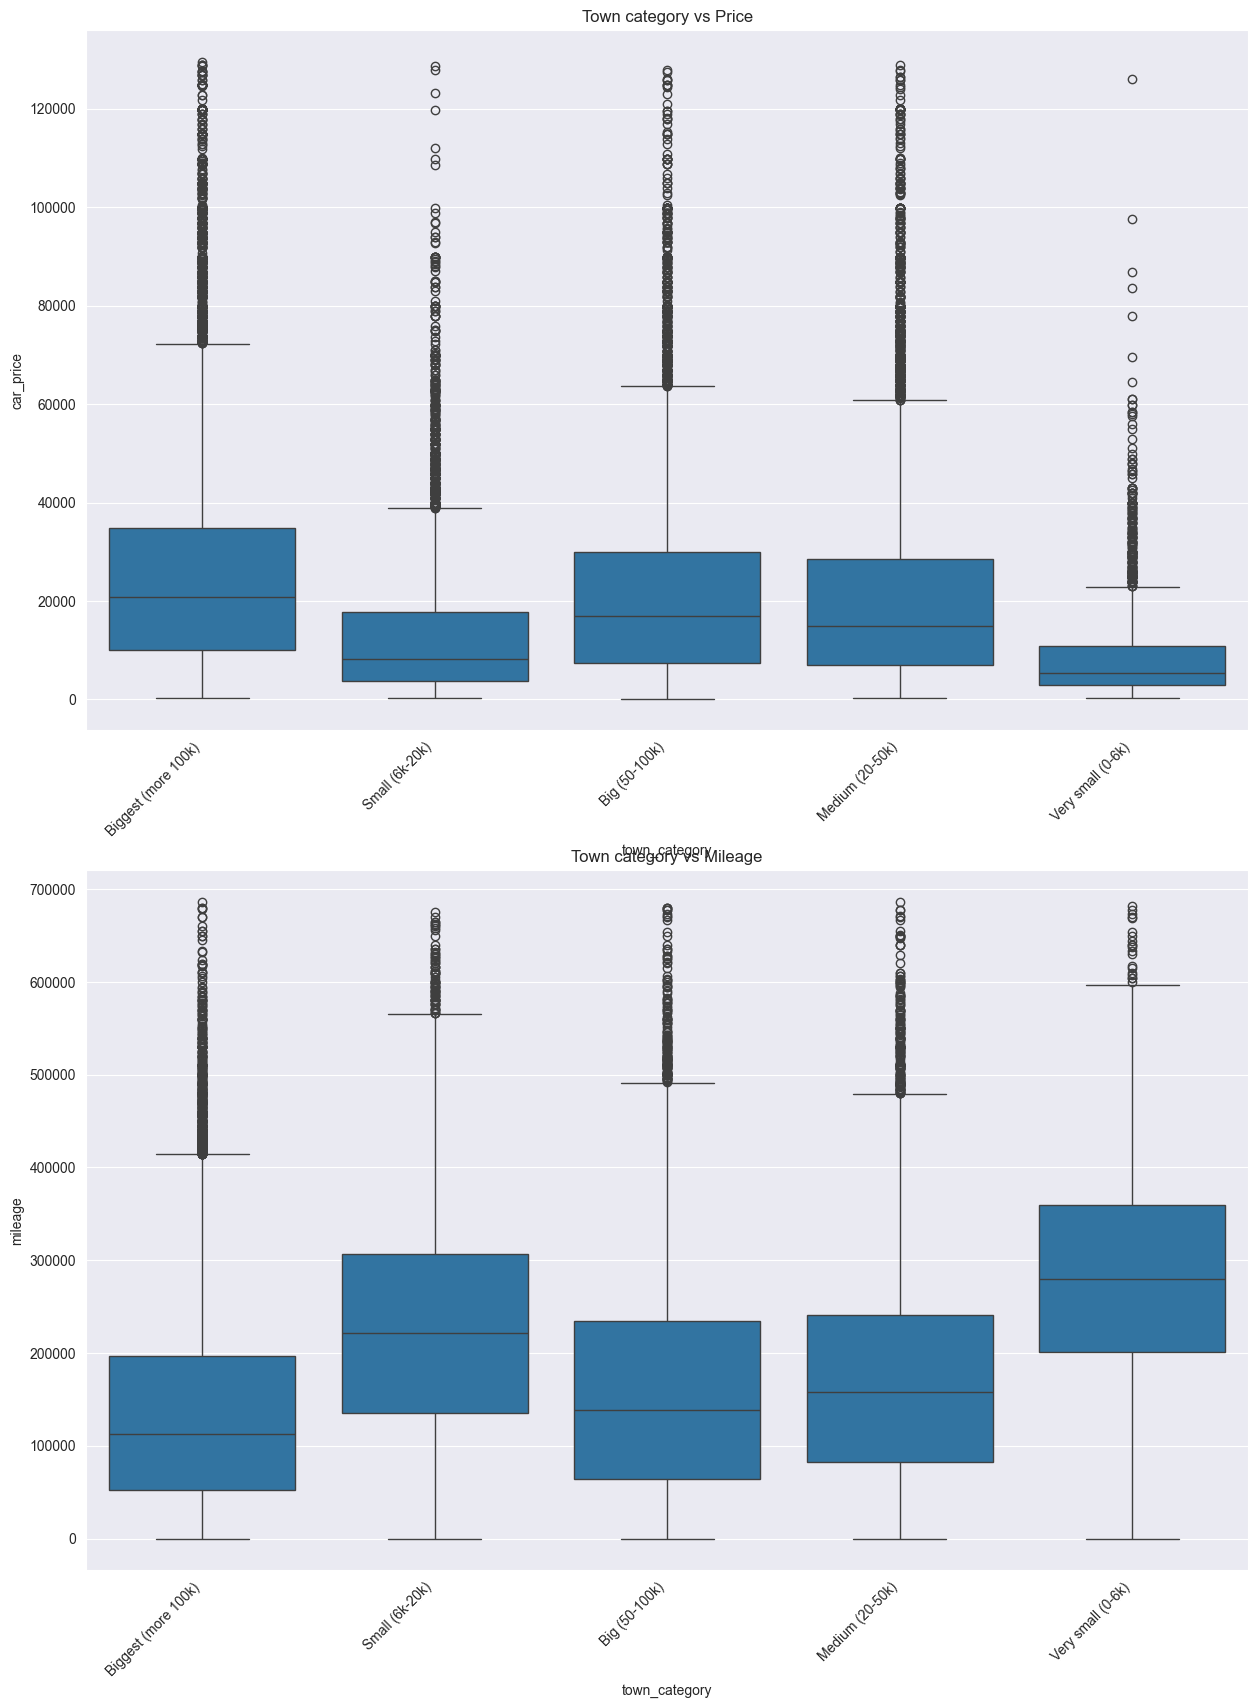

In [242]:
plt.figure(figsize=(15, 20))

plt.subplot(2,1,1)
plt.title('Town category vs Price')
sns.boxplot(x=data.town_category, y=data.car_price)
plt1.set(xlabel = 'Town Category', ylabel='Car price')
plt.xticks(rotation=45, ha='right');

plt.subplot(2,1,2)
plt.title('Town category vs Mileage')
sns.boxplot(x=data['town_category'], y=data['mileage'])
plt1.set(xlabel = 'Town category', ylabel='Mileage')
plt.xticks(rotation=45, ha='right');

We can see that bigger cities have more expensive cars. But cars in smaller cities usually have bigger mileage. Town category seems important in terms of price prediction.

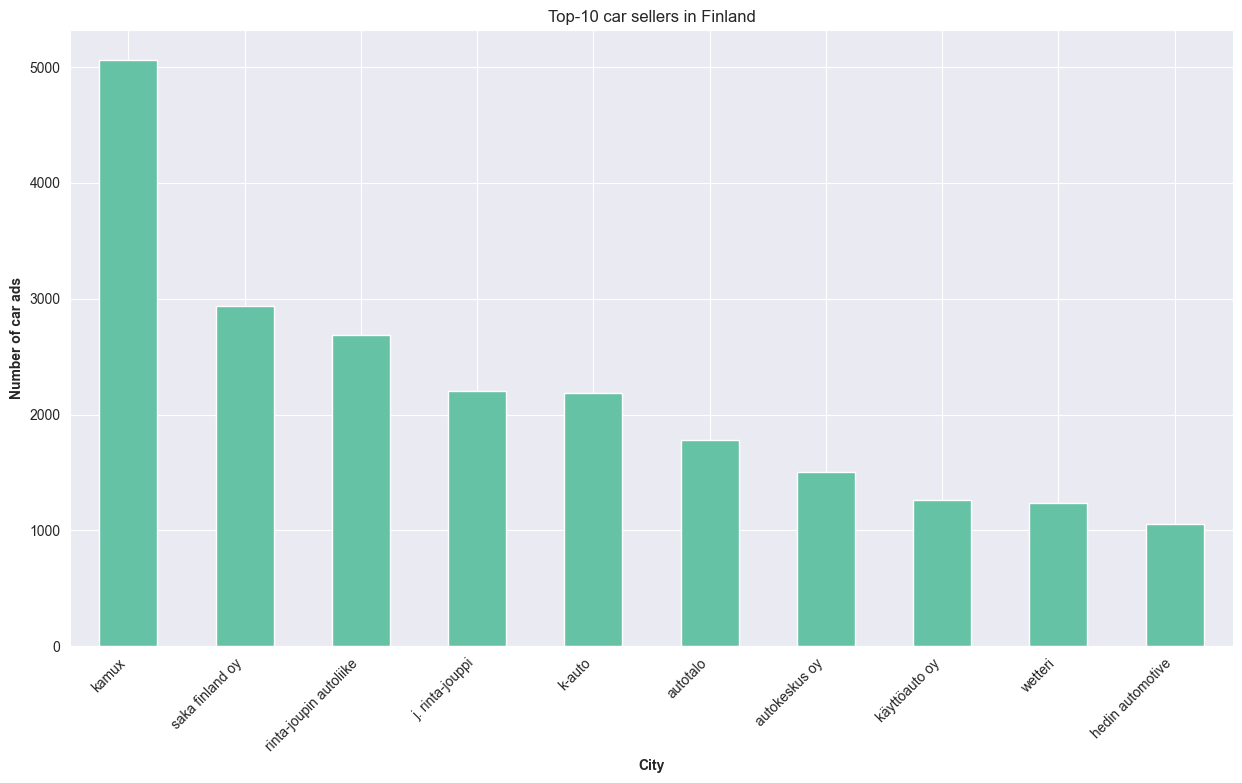

In [248]:
plt.figure(figsize=(15, 8))
ax = data.groupby(
    by='car_seller')['year'].count().sort_values(
    ascending=False).head(10).plot(
    kind='bar',stacked=True, colormap = 'Set2')
ax.title.set_text('Top-10 car sellers in Finland')
plt.xlabel("City",fontweight = 'bold')
plt.ylabel("Number of car ads",fontweight = 'bold')
plt.xticks(rotation=45, ha='right');

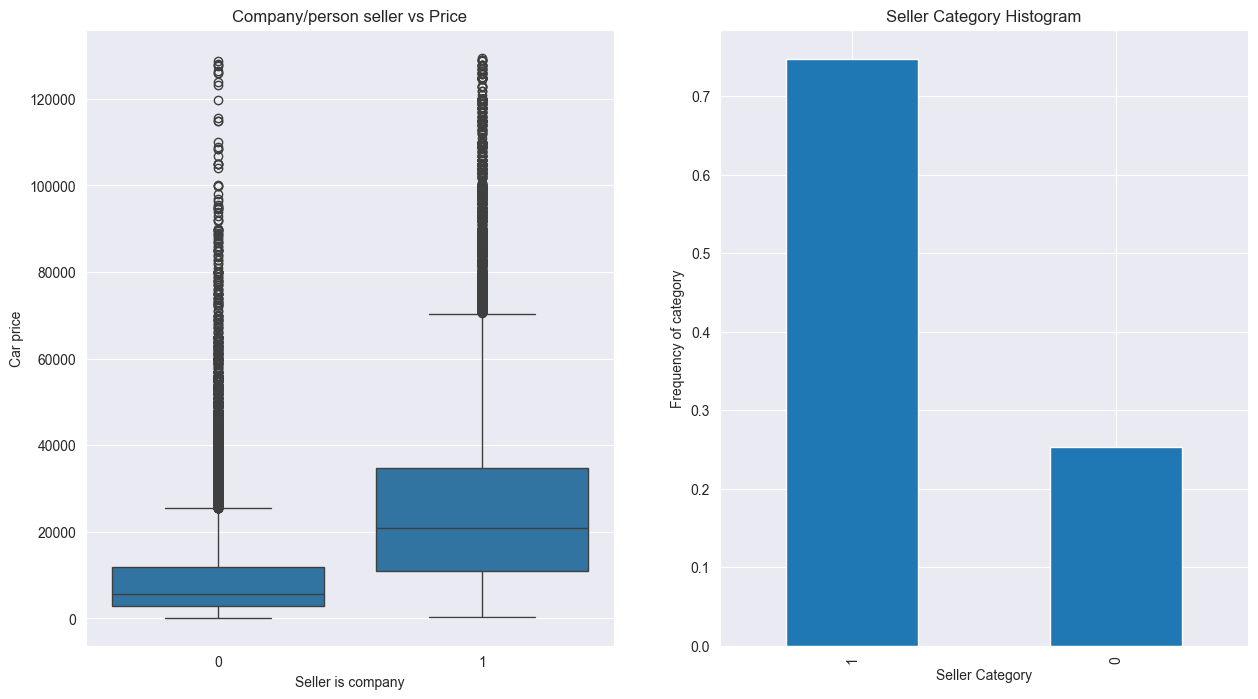

In [243]:
plt.figure(figsize=(15, 8))


plt.subplot(1,2,1)
plt1 = sns.boxplot(x=data.is_company, y=data.car_price)
plt.title('Company/person seller vs Price')
plt1.set(xlabel = 'Seller is company', ylabel='Car price')

plt.subplot(1,2,2)
plt1 = data.is_company.value_counts(normalize=True).plot(kind='bar')
plt.title('Seller Category Histogram')
plt1.set(xlabel = 'Seller Category', ylabel='Frequency of category')

plt.show();

Approximately 75% of cars are sold by car selling companies, rest are sold by private individuals. Market leader is Kamux. However, individuals usually sell cars cheaper as car selling companies add their commission to the final price that makes car more expensive. Also sellers rarely buy very old cars or cars with mileage more than 300000 km.

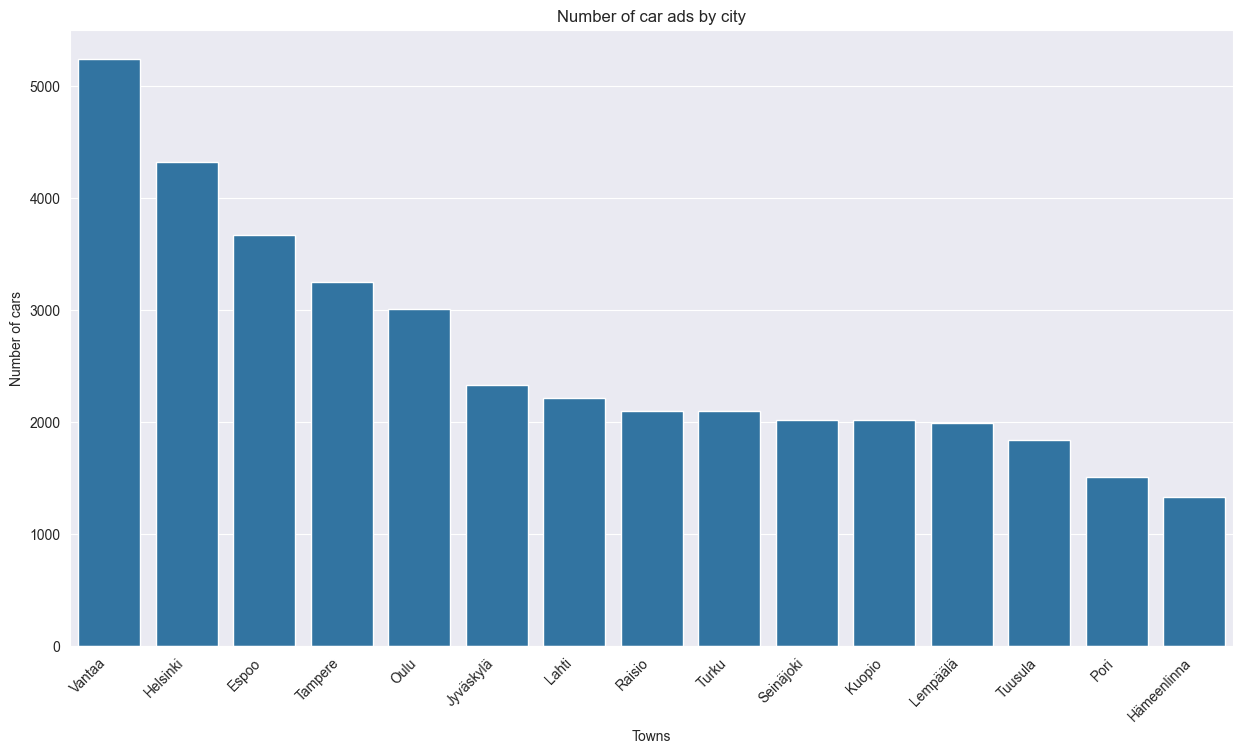

In [244]:
top_towns = data.groupby(
    by='town', as_index=False)['year'].count().sort_values(
    by='year', 
    ascending=False).head(15)

plt.figure(figsize=(15, 8))

plt.title('Number of car ads by city')
ax1=sns.barplot(top_towns, x='town', y='year')
ax1.set(xlabel = 'Towns', ylabel='Number of cars')
plt.xticks(rotation=45, ha='right');


plt.show()

<Figure size 1500x800 with 0 Axes>

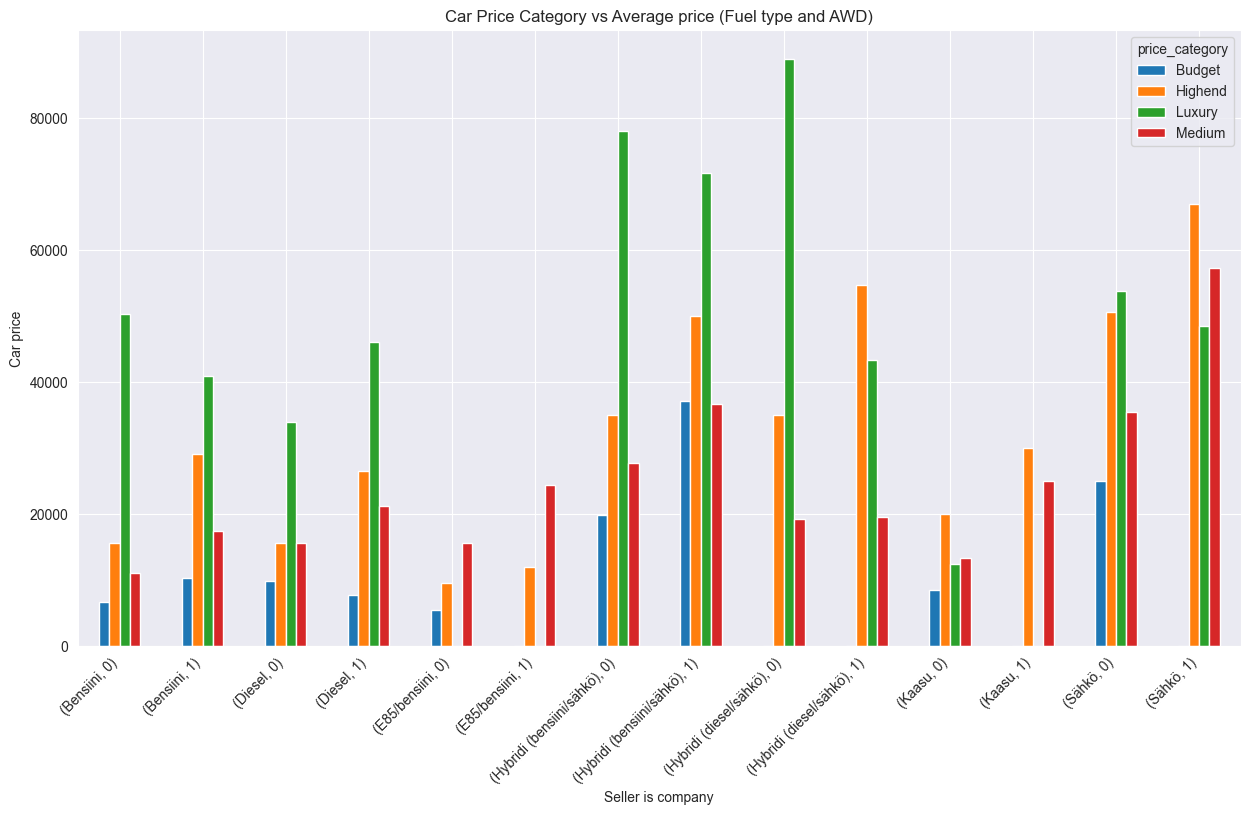

In [245]:
plt.figure(figsize=(15, 8))

plt1 = pd.DataFrame(data.groupby(['fuel_type','awd','price_category'])['car_price'].mean().unstack(fill_value=0)).plot.bar()
plt1.set(xlabel = 'Seller is company', ylabel='Car price')
plt.title('Car Price Category vs Average price (Fuel type and AWD)')
plt.xticks(rotation=45, ha='right');

plt.show();

<Figure size 1500x800 with 0 Axes>

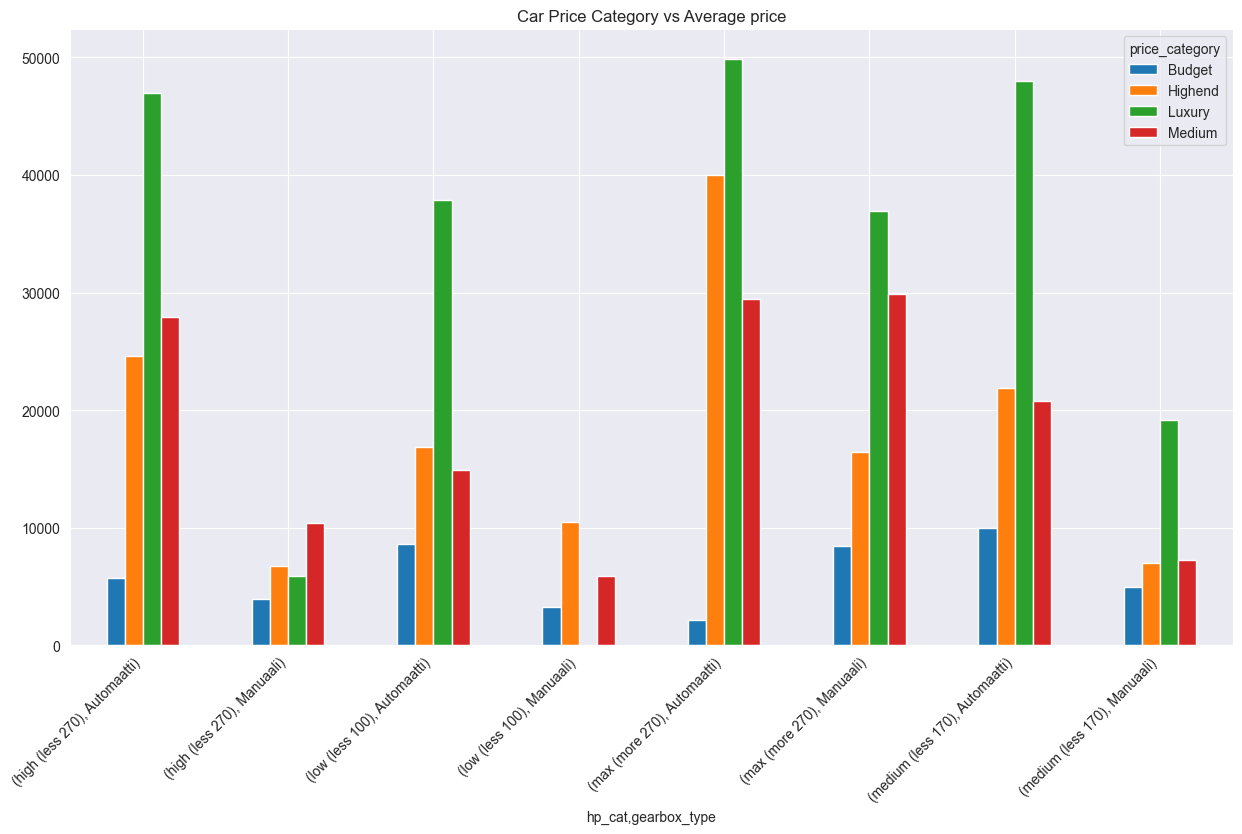

In [246]:
plt.figure(figsize=(15, 8))

df = pd.DataFrame(data.groupby(['hp_cat','gearbox_type', 'price_category'])['car_price'].median().unstack(fill_value=0))
df.plot.bar()
plt.title('Car Price Category vs Average price')
plt.xticks(rotation=45, ha='right');
plt.show();

Inference:
- luxury cars are not produced with low hp and manual gearbox
- luxury cars prefer hybrids

As result of categorical features analysis, in my opinion the following have strong influence on target variable:
- AWD
- Category
- HP
- Fuel type
- Gearbox type
- HP category
- Price category
- Town category
- Is company

Moving on. Now we can proceed to numerical features.

In [249]:
num_col = data.select_dtypes(exclude=['object']).columns
data_num = data[num_col].drop(columns='awd')

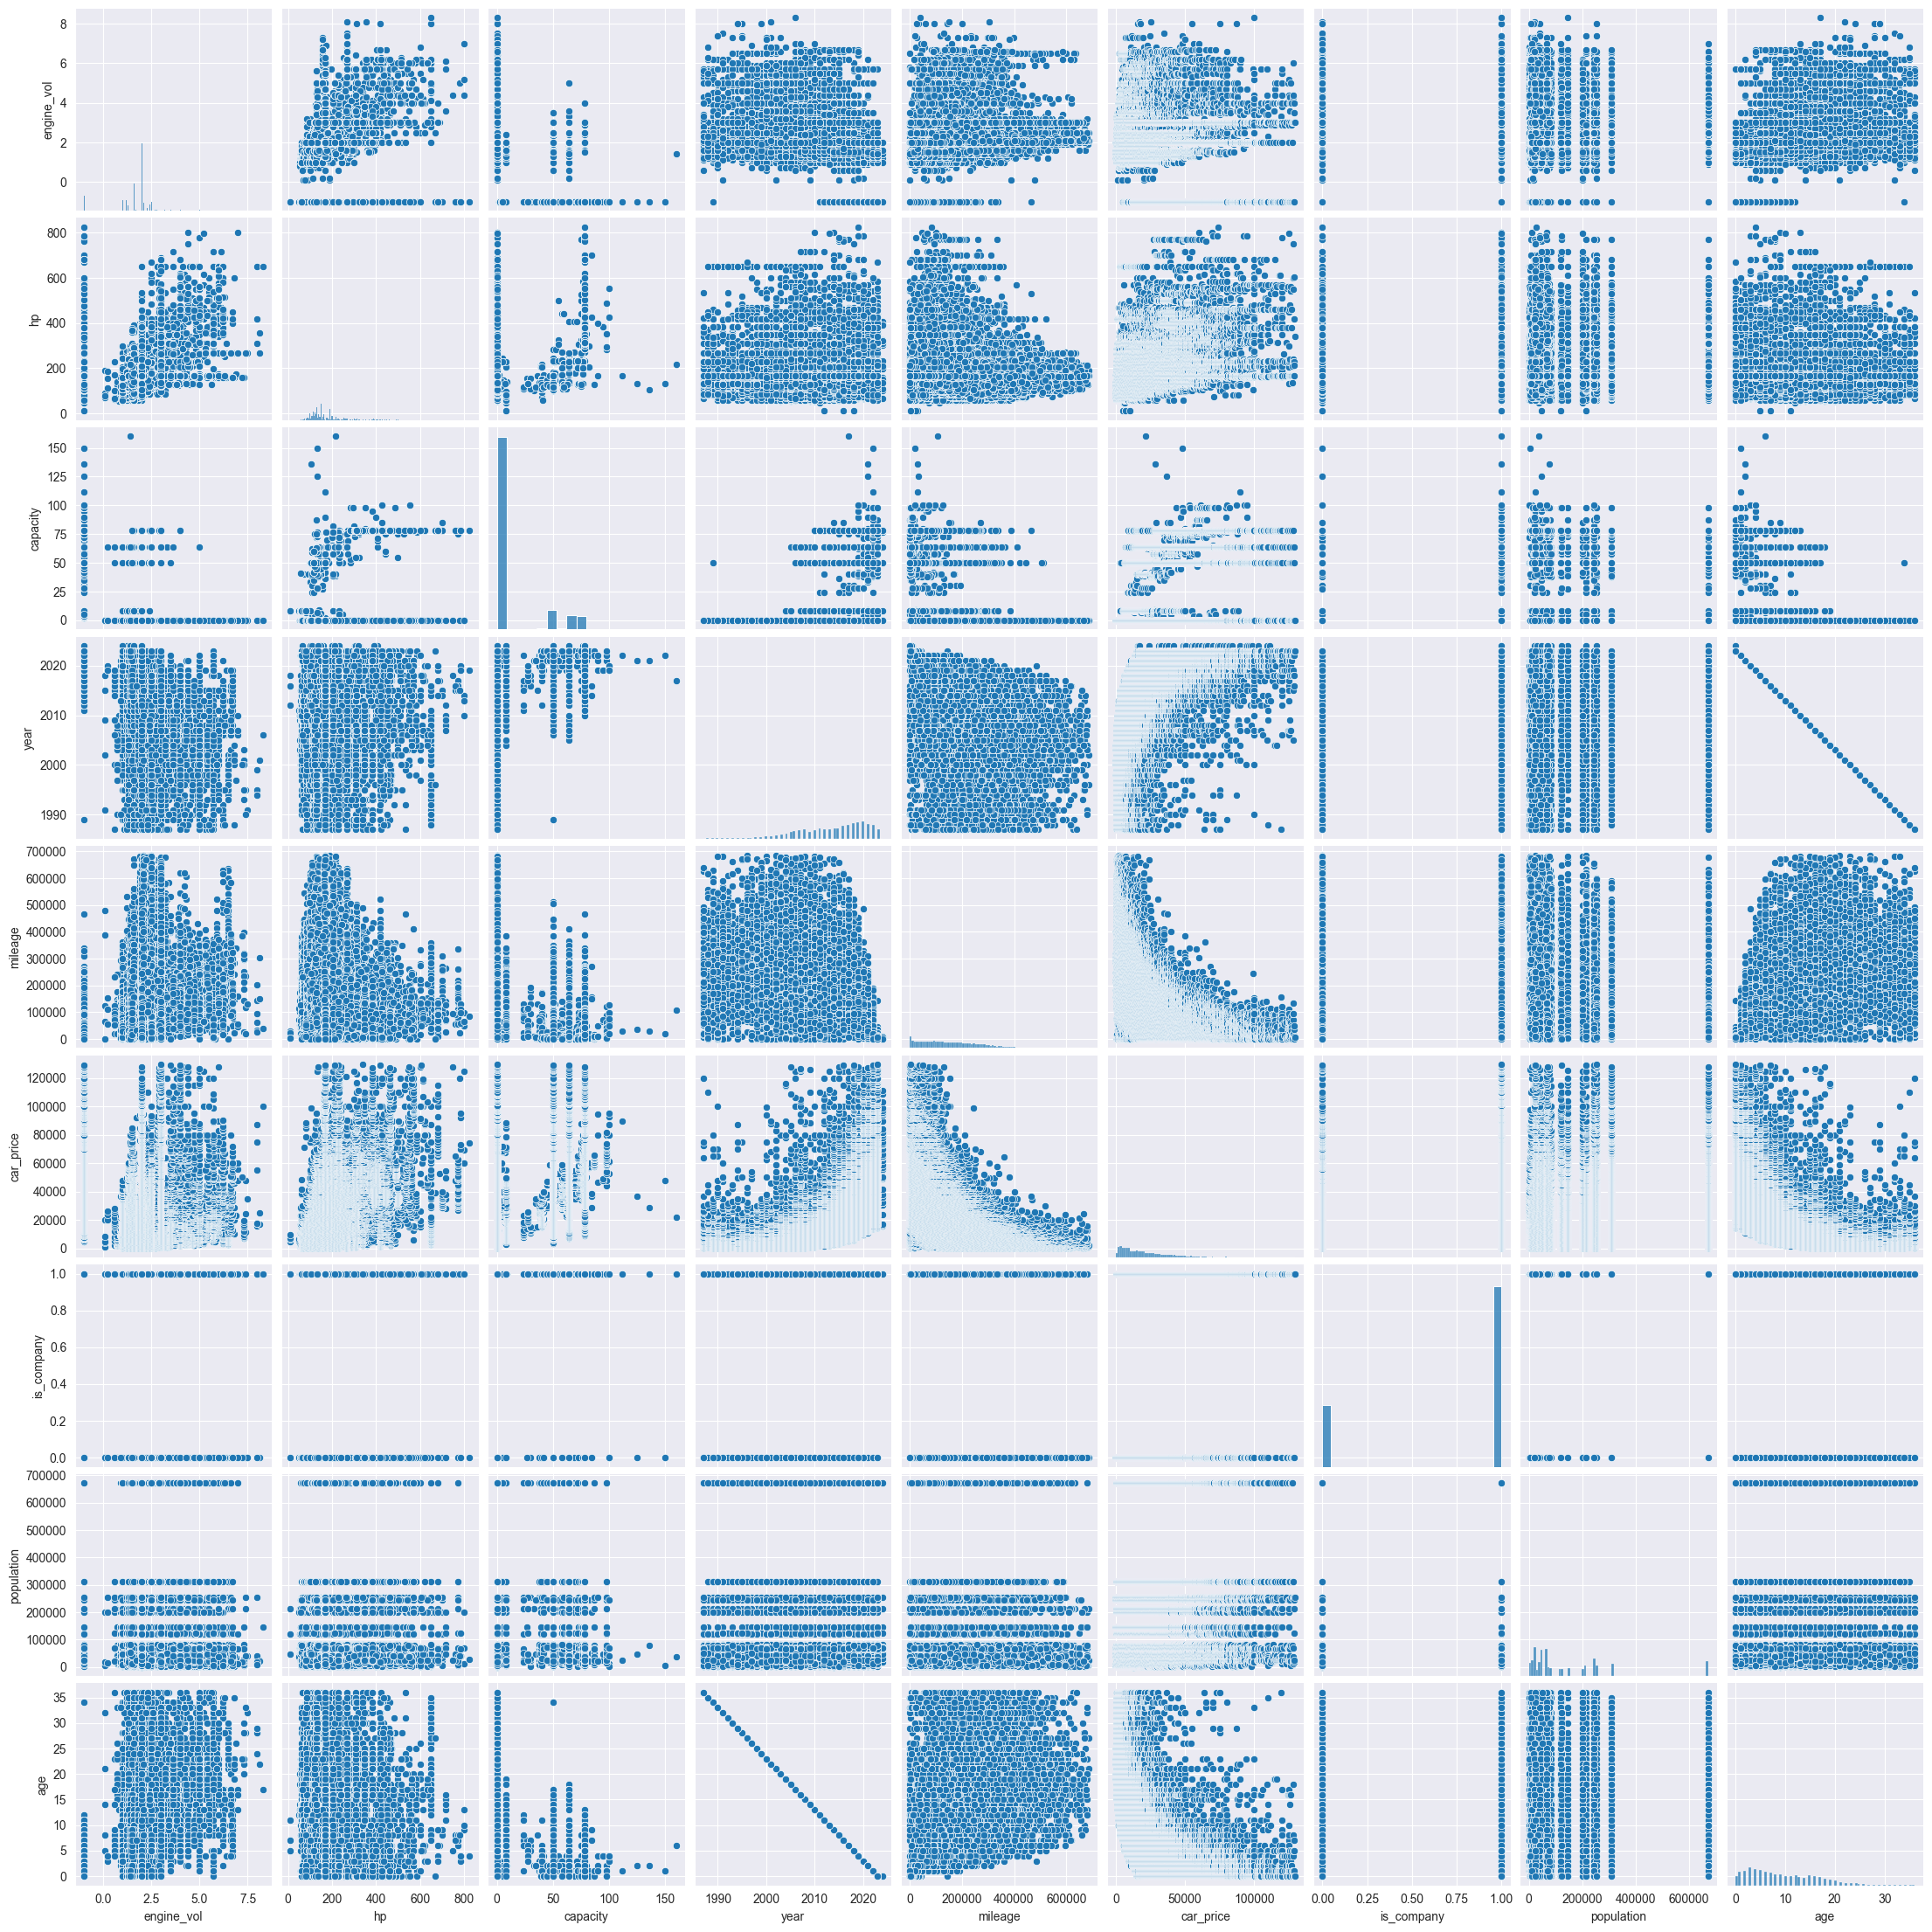

In [250]:
ax = sns.pairplot(data_num);

Inference:
- engine_vol, hp, capacity and age seems to have a positive correlation with price. 
- mileage has negative correlation with price. 

In [251]:
data['manual_gearbox'] = data['gearbox_type'].apply(lambda x: 1 if x=='Manuaali' else 0)
data = data.drop(columns=['year', 'gearbox_type'])

In [252]:
data.to_csv('/Users/egor/Documents/best_car_deals_app/data/data_final.csv')

# 8. Model building <a name="model"></a>

In [253]:
data = pd.read_csv('/Users/egor/Documents/best_car_deals_app/data/data_final.csv', index_col=0)

Here's the final list of features that we use for prediction based on visual analysis:
- engine_vol
- awd
- category
- hp
- capacity
- age
- mileage
- fuel_type
- gearbox_type
- hp_cat
- price_category
- town_category
- is_company

In [254]:
data_lr = data[[
    'engine_vol',
    'awd', 
    'category',
    'hp',
    'capacity',
    'age',
    'mileage',
    'fuel_type',
    'manual_gearbox',
    'hp_cat',
    'price_category',
    'town_category',
    'is_company',
    'car_price'
]].reset_index(drop=True)

In [255]:
data_lr.shape

(71878, 14)

Identifying numeric and categorical columns.

In [256]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_lr_num_cols = list(data_lr.select_dtypes(include=numerics).columns)
data_lr_cat_cols = list(data_lr.select_dtypes(exclude=numerics).columns)

Encoding only categorical columns:

In [257]:
ohe_lr = OneHotEncoder(handle_unknown='ignore', sparse_output = False)
ohe_lr.fit(data_lr[data_lr_cat_cols])
data_lr_ohe = ohe_lr.transform(data_lr[data_lr_cat_cols])
data_lr_ohe = pd.DataFrame(data_lr_ohe, columns = ohe_lr.get_feature_names_out(input_features = data_lr_cat_cols))
data_lr_ohe.head()

category_Cabriolet  category_Coupe  category_Goods wagon  \
0                 0.0             1.0                   0.0   
1                 0.0             0.0                   0.0   
2                 0.0             0.0                   0.0   
3                 0.0             0.0                   0.0   
4                 0.0             0.0                   0.0   

   category_Hatchback  category_Jeep  category_Limousine  category_Microbus  \
0                 0.0            0.0                 0.0                0.0   
1                 0.0            1.0                 0.0                0.0   
2                 1.0            0.0                 0.0                0.0   
3                 1.0            0.0                 0.0                0.0   
4                 1.0            0.0                 0.0                0.0   

   category_Minivan  category_Pickup  category_Sedan  ...  \
0               0.0              0.0             0.0  ...   
1               0.0              0.0             0.0  ...   
2               0.0              0.0             0.0  ...   
3               0.0              0.0             0.0  ...   
4               0.0              0.0             0.0  ...   

   hp_cat_medium (less 170)  price_category_Budget  price_category_Highend  \
0                       1.0                    0.0                     1.0   
1                       1.0                    0.0                     0.0   
2                       0.0                    1.0                     0.0   
3                       0.0                    1.0                     0.0   
4                       0.0                    0.0                     0.0   

   price_category_Luxury  price_category_Medium  town_category_Big (50-100k)  \
0                    0.0                    0.0                          0.0   
1                    0.0                    1.0                          0.0   
2                    0.0                    0.0                          1.0   
3                    0.0                    0.0                          0.0   
4                    0.0                    1.0                          1.0   

   town_category_Biggest (more 100k)  town_category_Medium (20-50k)  \
0                                1.0                            0.0   
1                                0.0                            0.0   
2                                0.0                            0.0   
3                                0.0                            1.0   
4                                0.0                            0.0   

   town_category_Small (6k-20k)  town_category_Very small (0-6k)  
0                           0.0                              0.0  
1                           1.0                              0.0  
2                           0.0                              0.0  
3                           0.0                              0.0  
4                           0.0                              0.0  

[5 rows x 31 columns]

In [258]:
data_lr = data_lr.drop(list(data_lr_cat_cols), axis=1)
data_lr = pd.concat([data_lr, data_lr_ohe], axis=1)
data_lr.shape

(71878, 40)

## 8.1 Train/test splitting and data scaling <a name="test"></a>

In [259]:
X = data_lr.drop(columns=['car_price'])
y = data_lr['car_price']

num_features = ['engine_vol', 'hp', 'capacity', 'age', 'mileage']
scaler = MinMaxScaler()
X[num_features] = scaler.fit_transform(X[num_features])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.7, 
    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, 
    train_size=0.5, 
    random_state=42)

### Correlation matrix

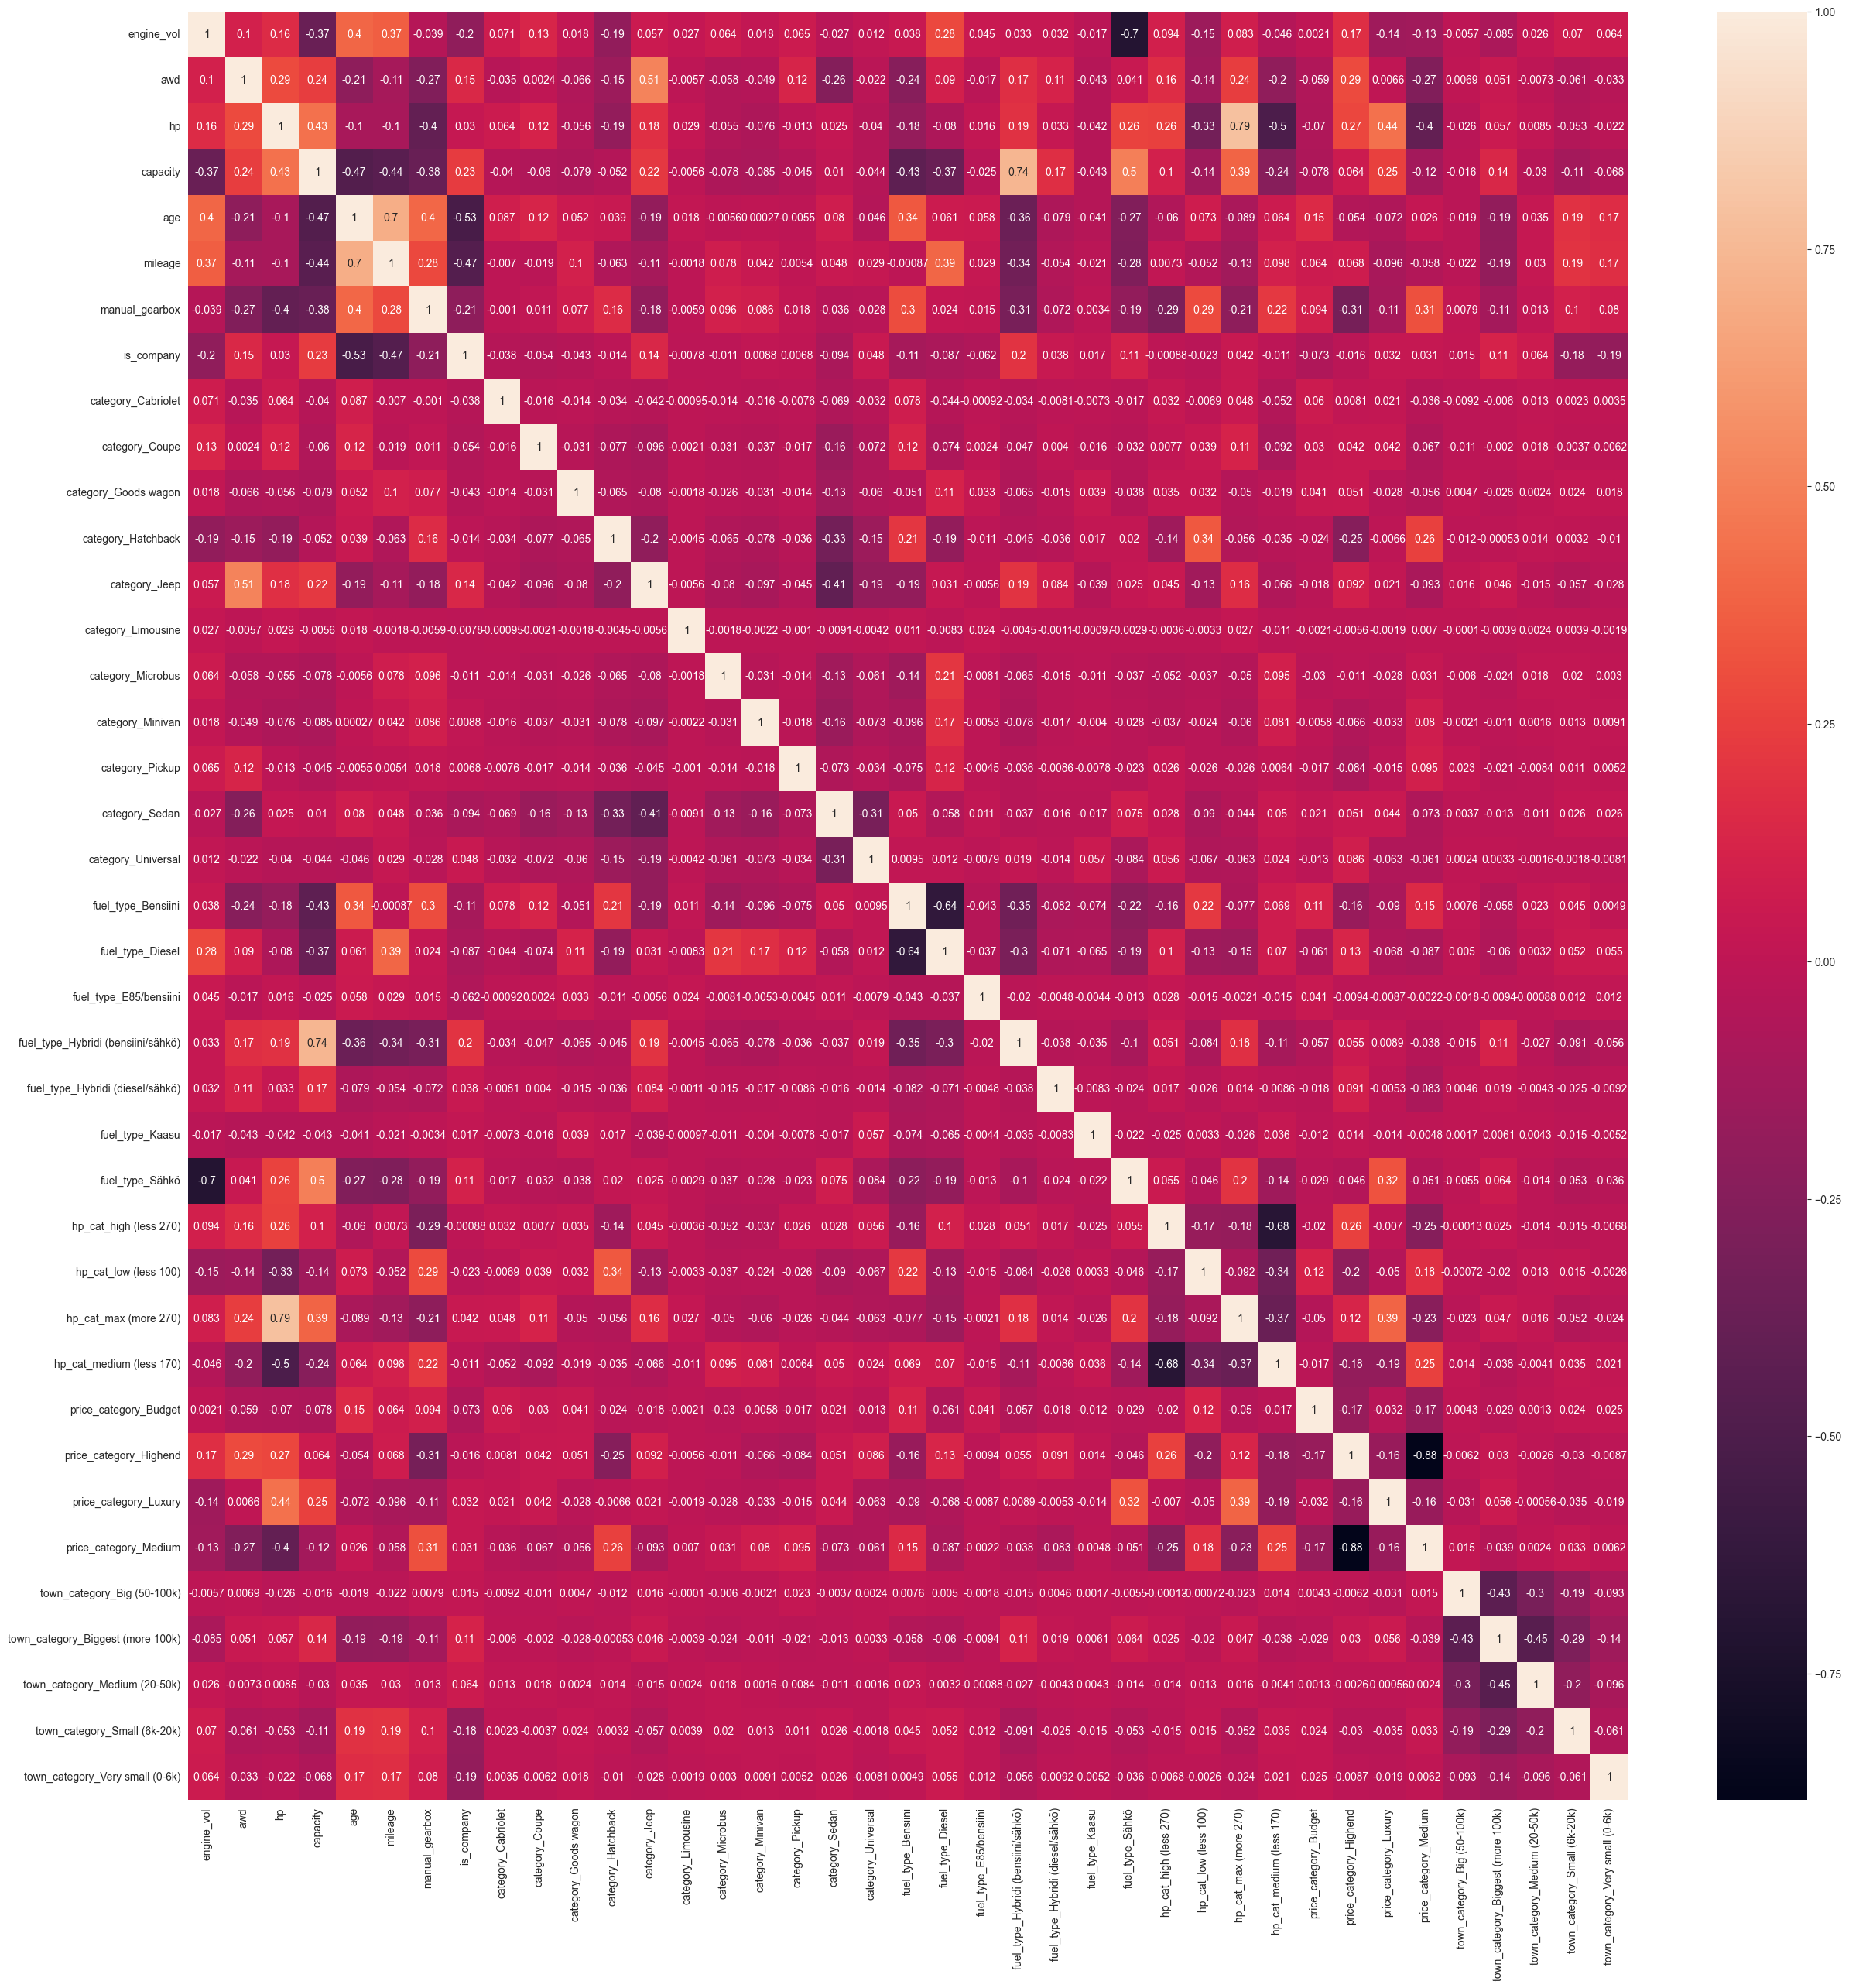

In [262]:
plt.figure(figsize = (30, 30))
sns.heatmap(X.corr(), annot = True)
plt.show()

In [263]:
corr = X.corr()
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending = False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
print('Features with highest correlation')
corr_unstack.head(20)

Features with highest correlation


level_0                             level_1  \
1242             price_category_Highend               price_category_Medium   
106                                  hp               hp_cat_max (more 270)   
139                            capacity  fuel_type_Hybridi (bensiini/sähkö)   
975                     fuel_type_Sähkö                          engine_vol   
199                             mileage                                 age   
1043             hp_cat_high (less 270)            hp_cat_medium (less 170)   
761                  fuel_type_Bensiini                    fuel_type_Diesel   
277                          is_company                                 age   
469                       category_Jeep                                 awd   
107                                  hp            hp_cat_medium (less 170)   
142                            capacity                     fuel_type_Sähkö   
121                            capacity                                 age   
202                             mileage                          is_company   
1401  town_category_Biggest (more 100k)       town_category_Medium (20-50k)   
122                            capacity                             mileage   
1250              price_category_Luxury                                  hp   
119                            capacity                                  hp   
1361        town_category_Big (50-100k)   town_category_Biggest (more 100k)   
744                  fuel_type_Bensiini                            capacity   
675                      category_Sedan                       category_Jeep   

             0  
1242  0.882778  
106   0.789597  
139   0.741221  
975   0.701984  
199   0.700368  
1043  0.680482  
761   0.637996  
277   0.528694  
469   0.511944  
107   0.503697  
142   0.498079  
121   0.473709  
202   0.468389  
1401  0.451935  
122   0.444256  
1250  0.439559  
119   0.434372  
1361  0.433706  
744   0.425448  
675   0.406887

We don't have features that have high correlation with price

## 8.2 Linear regression (Baseline) <a name="linear"></a>

In [264]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(f'Mean squared error for train:\n {mean_squared_error(y_train, y_train_pred)}')
print(f'R2 score for train:\n {r2_score(y_train, y_train_pred)}')
print()
print(f'Mean squared error for test:\n {mean_squared_error(y_test, y_test_pred)}')
print(f'R2 score for test:\n {r2_score(y_test, y_test_pred)}')

Mean squared error for train:
 93561526.6820368
R2 score for train:
 0.7385865618519314

Mean squared error for test:
 90060907.37135968
R2 score for test:
 0.7378448872256858


The baseline model showed decent score of R2 metric on test data. 

## 8.3 Random Forest <a name="forest"></a>

I've tried several data features' combinations and found out that 'make_model' feature kills Linear Regression model (R2 score becomes negative), however, it significally improves scores for ensemble models. So I proceed with it.

In [265]:
data_mdl = data[[
    'make_model',
    'engine_vol',
    'awd', 
    'category',
    'hp',
    'capacity',
    'age',
    'mileage',
    'fuel_type',
    'manual_gearbox',
    'hp_cat',
    'price_category',
    'town_category',
    'is_company',
    'car_price'
]].reset_index(drop=True)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_mdl_num_cols = list(data_mdl.select_dtypes(include=numerics).columns)
data_mdl_cat_cols = list(data_mdl.select_dtypes(exclude=numerics).columns)
ohe_mdl = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_mdl.fit(data_mdl[data_mdl_cat_cols])
data_mdl_ohe = ohe_mdl.transform(data_mdl[data_mdl_cat_cols])
data_mdl_ohe = pd.DataFrame(data_mdl_ohe, columns=ohe_mdl.get_feature_names_out(input_features=data_mdl_cat_cols))

data_mdl = data_mdl.drop(list(data_mdl_cat_cols), axis=1)
data_mdl = pd.concat([data_mdl, data_mdl_ohe], axis=1)
data_mdl.shape

(71878, 1263)

In [267]:
#Dumping/Storing the one hot encoding object into a file for later use
dump(ohe_mdl, '/Users/egor/Documents/best_car_deals_app/models/ohe_mdl.joblib')

['/Users/egor/Documents/best_car_deals_app/models/ohe_mdl.joblib']

For further hyperparamenters tuning we need to create not only train and test set, but validation set as well.

In [268]:
X = data_mdl.drop(columns=['car_price'])
y = data_mdl['car_price']

data_mdl_num_cols.remove('car_price')
scaler = MinMaxScaler()
X[data_mdl_num_cols] = scaler.fit_transform(X[data_mdl_num_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.7, 
    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, 
    train_size=0.5, 
    random_state=42)

In [269]:
#Dumping/Storing the scaler object into a file for later use
dump(scaler, '/Users/egor/Documents/best_car_deals_app/models/scaler.joblib')

['/Users/egor/Documents/best_car_deals_app/models/scaler.joblib']

Let's try to build Random Forest Regressor model with standard parameters. 

In [270]:
rf = RandomForestRegressor(
    n_estimators = 100,
    criterion='squared_error',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(f'Mean squared error for train:\n {mean_squared_error(y_train, y_train_pred)}')
print(f'R2 score for train:\n {r2_score(y_train, y_train_pred)}')
print()
print(f'Mean squared error for test:\n {mean_squared_error(y_test, y_test_pred)}')
print(f'R2 score for test:\n {r2_score(y_test, y_test_pred)}')

Mean squared error for train:
 2843024.3221351686
R2 score for train:
 0.9920565130866914

Mean squared error for test:
 18591286.334010728
R2 score for test:
 0.9458832815728208


As we see, the R2 score has raised significally. Now it has reached 0.946. MSE score also dropped to 18591286.

I've tried to tune hyperparameters of Random Forest Regressor, however, could not achieve higher R2 score. That's OK as Random Forest works excellent with standard parameters. 

Additionally we can extract feature importances with Gini score:

In [271]:
feats = {}
for feature, importance in zip(X_train.columns, rf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances

Features  Gini-Importance
0                                    age         0.538982
1                                     hp         0.144317
2                             engine_vol         0.109366
3                                mileage         0.058380
4                  price_category_Luxury         0.014489
...                                  ...              ...
1257               make_model_mazda rx-8         0.000000
1258               make_model_mazda mx-3         0.000000
1259           make_model_mazda e-series         0.000000
1260              make_model_mazda b2600         0.000000
1261  make_model_mercedes-benz ambulance         0.000000

[1262 rows x 2 columns]

## 8.4 XGBoost <a name="xgb"></a>
Let's see how XGBoost model will perform with standard parameters:

In [272]:
xgb_reg = xgb.XGBRegressor(n_jobs=-1)
xgb_reg.fit(X_train, y_train)

y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

print(f'Mean squared error for train:\n {mean_squared_error(y_train, y_train_pred)}')
print(f'R2 score for train:\n {r2_score(y_train, y_train_pred)}')
print()
print(f'Mean squared error for test:\n {mean_squared_error(y_test, y_test_pred)}')
print(f'R2 score for test:\n {r2_score(y_test, y_test_pred)}')

Mean squared error for train:
 16485139.785136651
R2 score for train:
 0.9539400732073404

Mean squared error for test:
 21745647.081149768
R2 score for test:
 0.936701364339994


It has showed great result as Random Forest, however, R2 and MSE scores a a bit lower: 
Random Forest Regressor on test data (R2=0.946, MSE=18591286)
XGBoost on test data (R2=0.937, MSE=21745647)

Let's see if hyperparameter tuning helps. It is important to perform tuning on validation data to avoid overfitting on train data.

In [273]:
params = {
    'n_estimators': [100, 200, 500, 750], #no of trees
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.25], #eta
    'min_child_weight': [1, 5, 7, 10],
    'gamma': [0.1, 0.5, 1, 1.5, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5, 10, 12]
}

folds = 5
param_comb = 100
random_search = RandomizedSearchCV(
    xgb_reg, 
    param_distributions=params,
    n_iter=param_comb,
    n_jobs=-1,
    cv=folds,
    verbose=3,
    random_state=42
)

random_search.fit(X_val, y_val)

print('We can get a score of: ', random_search.best_score_, ' using', random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.922 total time=   6.0s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0;, score=0.894 total time=   2.3s
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=100, subsample=0.6;, score=0.916 total time=   2.5s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.8;, score=0.781 total time=   1.8s


/Users/egor/Documents/best_car_deals_app/car_app/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.921 total time=   6.2s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0;, score=0.893 total time=   2.1s
[CV 1/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=100, subsample=0.6;, score=0.913 total time=   2.6s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=7, n_estimators=100, subsample=0.8;, score=0.770 total time=   2.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.913 total time=   6.2s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0;, score=0.899 total time=   2.1s
[CV 3/5] END colsampl

We can get a score of:  0.935470668269242  using {'subsample': 0.6, 'n_estimators': 750, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 1.5, 'colsample_bytree': 0.8}
Using Random Search parameters we've received a 100 variations of parameters and can visualize which value of each parameter shows better score.

In [274]:
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'split3_test_score',
            'split4_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

param_subsample param_n_estimators param_min_child_weight param_max_depth  \
0             0.6                750                      1              10   
1             1.0                750                      1              10   
2             0.6                750                      1              10   
3             0.8                750                      1               5   
4             0.6                500                      1              12   
5             1.0                750                      1               5   
6             1.0                750                      1               5   
7             0.8                500                      1              10   
8             1.0                500                      1              10   
9             0.8                200                      1              10   

  param_learning_rate param_gamma param_colsample_bytree  mean_test_score  \
0                0.05         1.5                    0.8         0.935471   
1                 0.1           5                    0.6         0.933799   
2                 0.1         0.1                    0.8         0.933555   
3                 0.1         1.5                    0.6         0.932672   
4                0.02           1                    0.8         0.932096   
5                0.25         0.1                    1.0         0.932037   
6                 0.1         0.5                    0.6         0.930802   
7                0.02         0.1                    0.6         0.930260   
8                0.25           5                    1.0         0.930179   
9                 0.1           1                    0.8         0.929752   

   rank_test_score  
0                1  
1                2  
2                3  
3                4  
4                5  
5                6  
6                7  
7                8  
8                9  
9               10

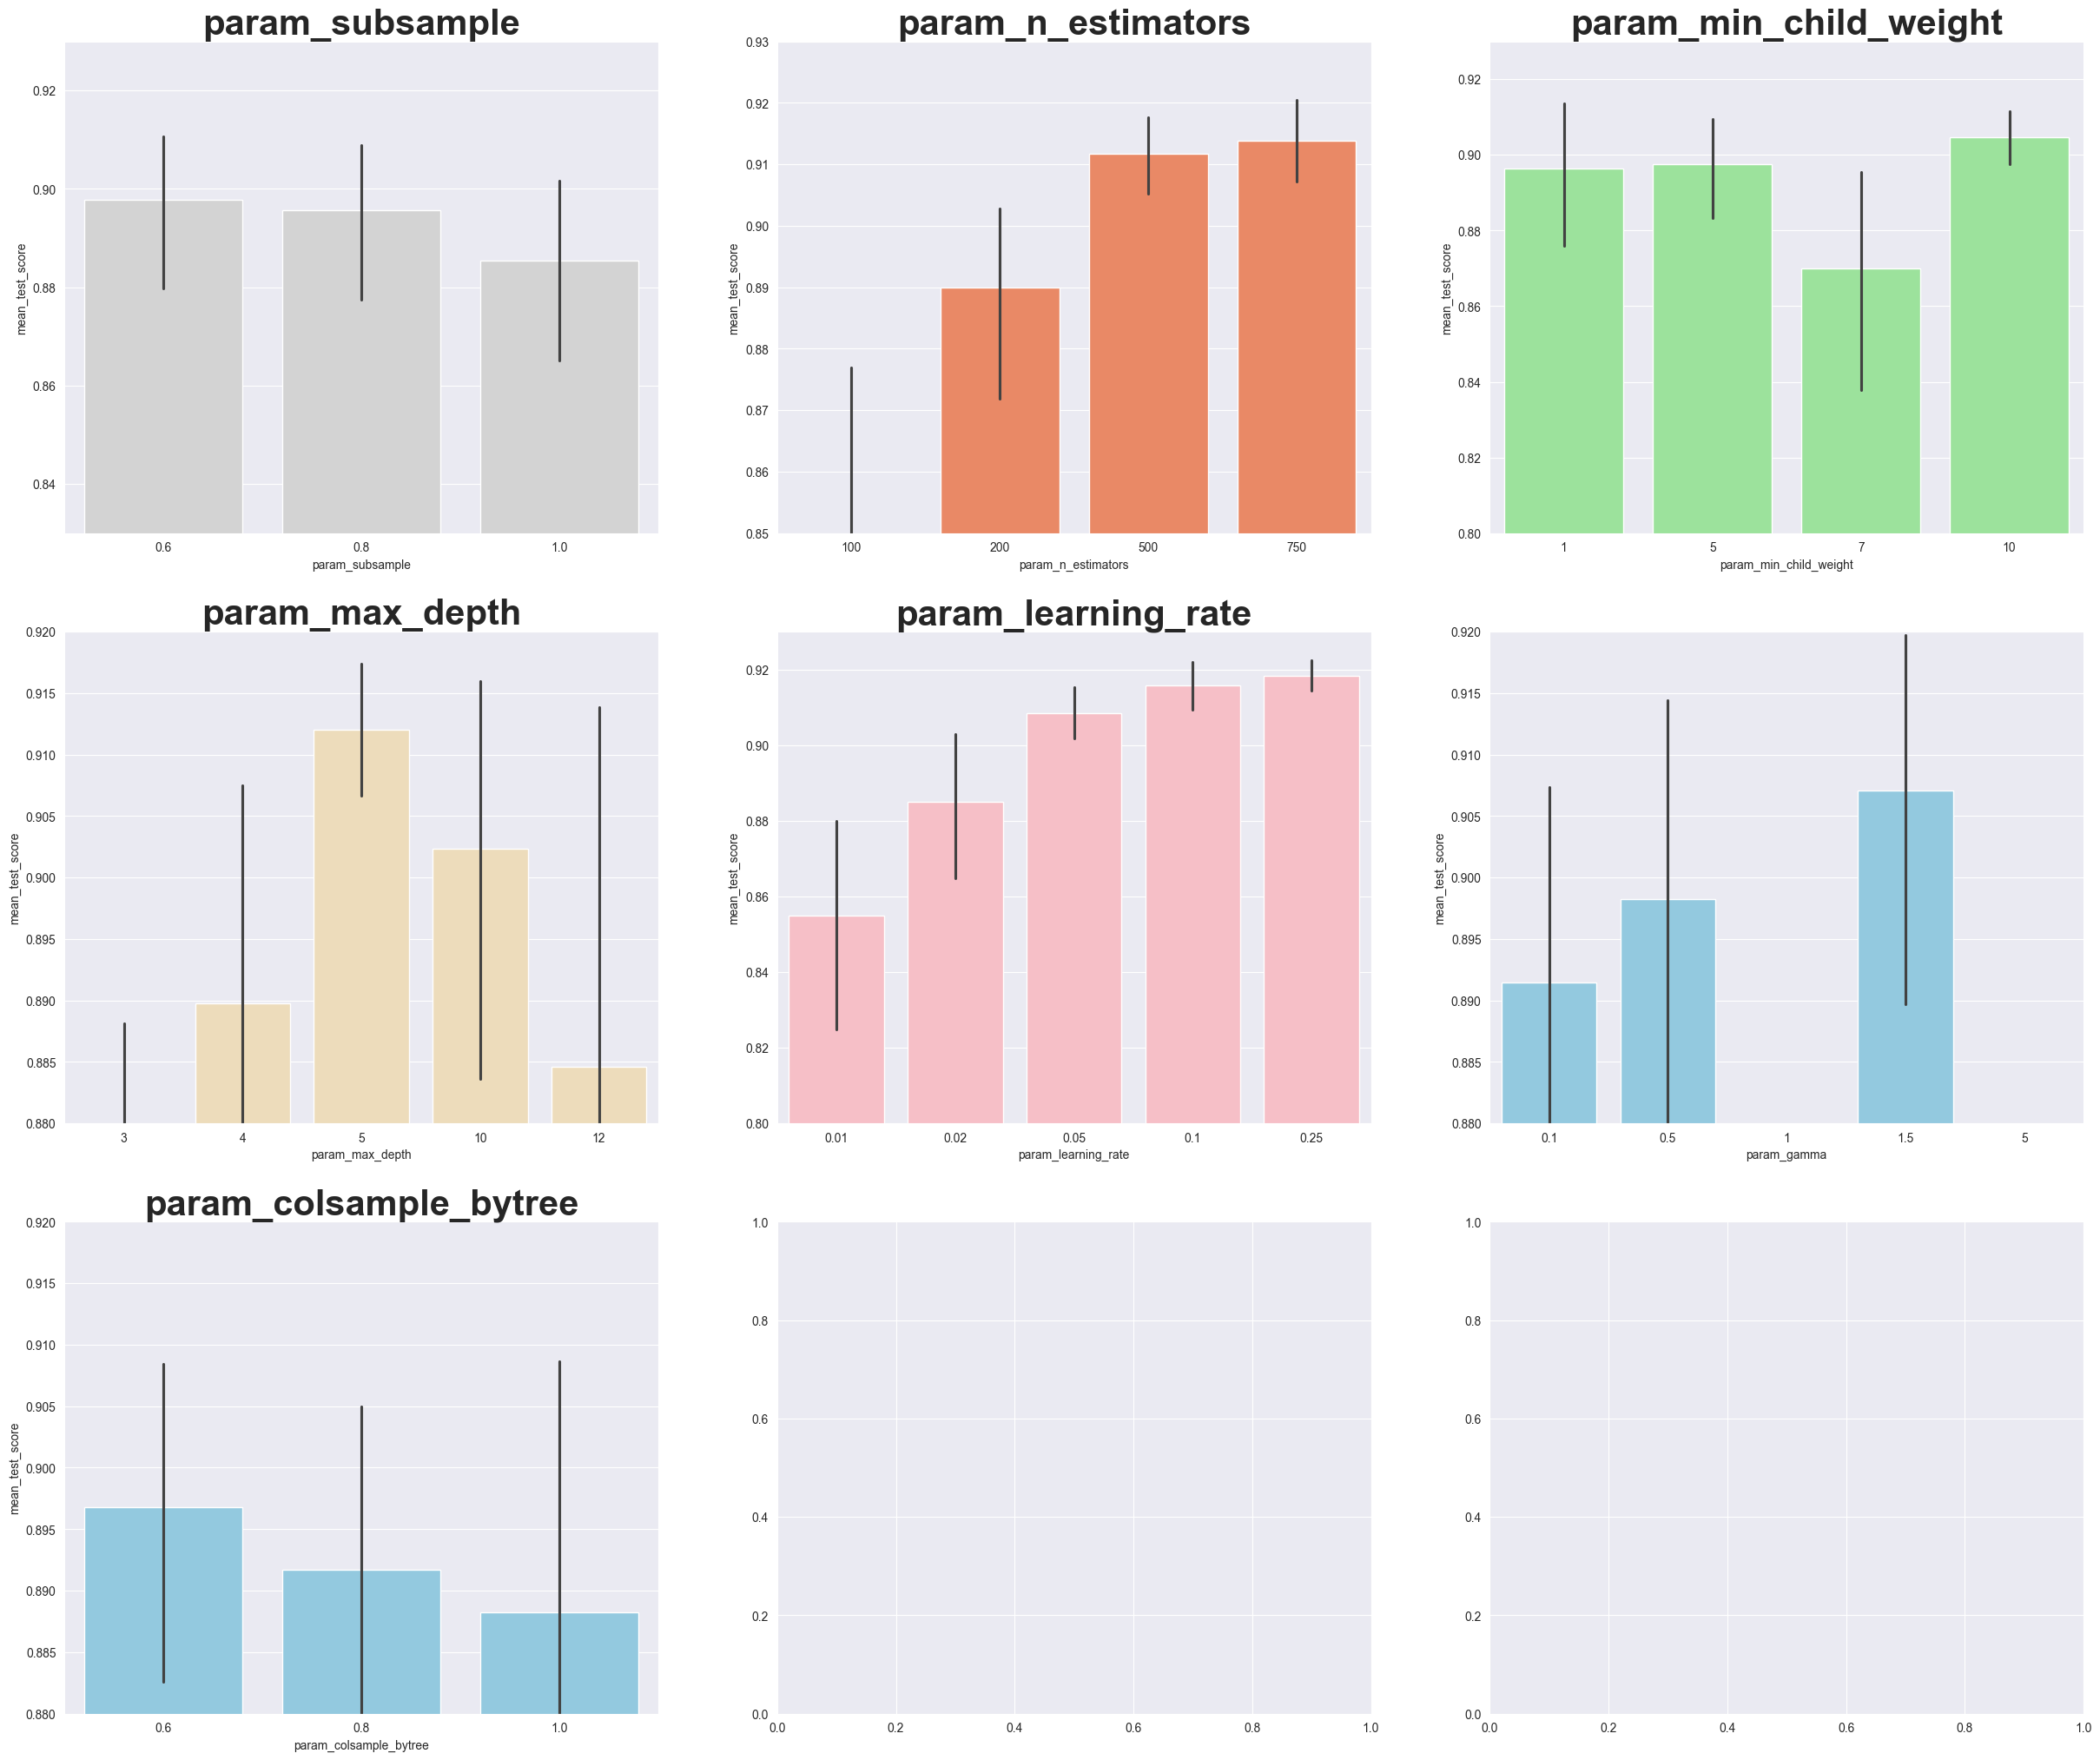

In [275]:
fig, axs = plt.subplots(ncols=3, nrows=3)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_subsample', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'param_subsample', size=30, weight='bold')
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'param_n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_child_weight', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'param_min_child_weight', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'param_max_depth', size=30, weight='bold')
sns.barplot(x='param_learning_rate', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'param_learning_rate', size=30, weight='bold')
sns.barplot(x='param_gamma',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.88,.92])
axs[2,0].set_title(label = 'param_gamma', size=30, weight='bold')
sns.barplot(x='param_colsample_bytree',y='mean_test_score', data=rs_df, ax=axs[2,0], color='skyblue')
axs[2,0].set_ylim([.88,.92])
axs[2,0].set_title(label = 'param_colsample_bytree', size=30, weight='bold')
plt.show()

For each parameter I've selected 2 values which will be further used in Grid Search.

In [276]:
param_grid = {
    'n_estimators': [500, 750], #no of trees
    'learning_rate': [0.1, 0.25], #eta
    'min_child_weight': [1, 10],
    'gamma': [0.5, 1.5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 1.0],
    'max_depth': [5, 6]
}

gs = GridSearchCV(xgb_reg, param_grid, cv=3, verbose=3, n_jobs=-1)
gs.fit(X_train, y_train)
xgb_reg_gs = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=750, subsample=0.8;, score=0.900 total time=   6.3s
[CV 2/3] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.6;, score=0.940 total time=  19.4s


/Users/egor/Documents/best_car_deals_app/car_app/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, subsample=1.0;, score=0.912 total time=   5.7s
[CV 2/5] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=10, n_estimators=750, subsample=0.6;, score=0.920 total time=   8.6s
[CV 4/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.05, max_depth=5, min_child_weight=10, n_estimators=100, subsample=0.6;, score=0.889 total time=   2.1s
[CV 2/3] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.8;, score=0.940 total time=  19.4s
[CV 3/5] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, subsample=1.0;, score=0.899 total time=   5.5s
[CV 4/5] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=10, n_estimators=750, subsample=0.6;, score=0.913 total time=   8.4s
[CV 1/3] END colsamp

{'colsample_bytree': 0.6,
 'gamma': 0.5,
 'learning_rate': 0.25,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 750,
 'subsample': 0.8}

As we identified best hyperparameters we can finally predict test results and get values of target metrics.

In [277]:
y_train_pred = xgb_reg_gs.predict(X_train)
y_test_pred = xgb_reg_gs.predict(X_test)

print(f'Mean squared error for train:\n {mean_squared_error(y_train, y_train_pred)}')
print(f'R2 score for train:\n {r2_score(y_train, y_train_pred)}')
print()
print(f'Mean squared error for test:\n {mean_squared_error(y_test, y_test_pred)}')
print(f'R2 score for test:\n {r2_score(y_test, y_test_pred)}')

Mean squared error for train:
 7213775.135330755
R2 score for train:
 0.9798445170036337

Mean squared error for test:
 14938998.38841935
R2 score for test:
 0.9565145974923098


The result is great. 
R2=0.946, MSE=18591286 - Random Forest Regressor on test data 
R2=0.937, MSE=21745647 - XGBoost on test data 
R2=0.956, MSE=14938998 - XGBoost with best hyperparameters on test data

We've managed to get higher score than XGBoost model (basic hyperparameters) and Random Forest Regressor.

In [278]:
#Dumping/Storing the model object into a file for later use
dump(xgb_reg_gs, '/Users/egor/Documents/best_car_deals_app/models/xgb_reg_gs.joblib')

['/Users/egor/Documents/best_car_deals_app/models/xgb_reg_gs.joblib']

Let's have a look which features in XGBoost model are most important:

In [280]:
# Creating a dataframe containing the features names and its corresponding coefficient values
linear_model_parameter = list(abs(xgb_reg_gs.feature_importances_))
cols = X_train.columns
lm_model_df = pd.DataFrame(list(zip(cols,linear_model_parameter)))
lm_model_df.columns = ['Feaure','Coef']

In [281]:
# Only selecting the features whose coeficient values are greater than 0
lm_model_df = lm_model_df[lm_model_df['Coef']>0]

In [282]:
# Sorted the created dataframe containing the features names and its corresponding coefficient values in descending order 
# inorder to get the top coefficients
lm_model_df.sort_values(by='Coef',ascending=False).reset_index(drop=True)

Feaure      Coef
0                       fuel_type_Sähkö  0.057097
1                 hp_cat_max (more 270)  0.055243
2              make_model_tesla model 3  0.039558
3                 price_category_Medium  0.036241
4    make_model_land rover range  sport  0.029243
..                                  ...       ...
731         make_model_maserati levante  0.000087
732                make_model_volvo 440  0.000087
733   make_model_mercedes-benz clk 63 a  0.000080
734                 make_model_fiat 500  0.000077
735   make_model_chevrolet express 3500  0.000061

[736 rows x 2 columns]

Plotting a scatter plot of the actual and predicted values of the test set

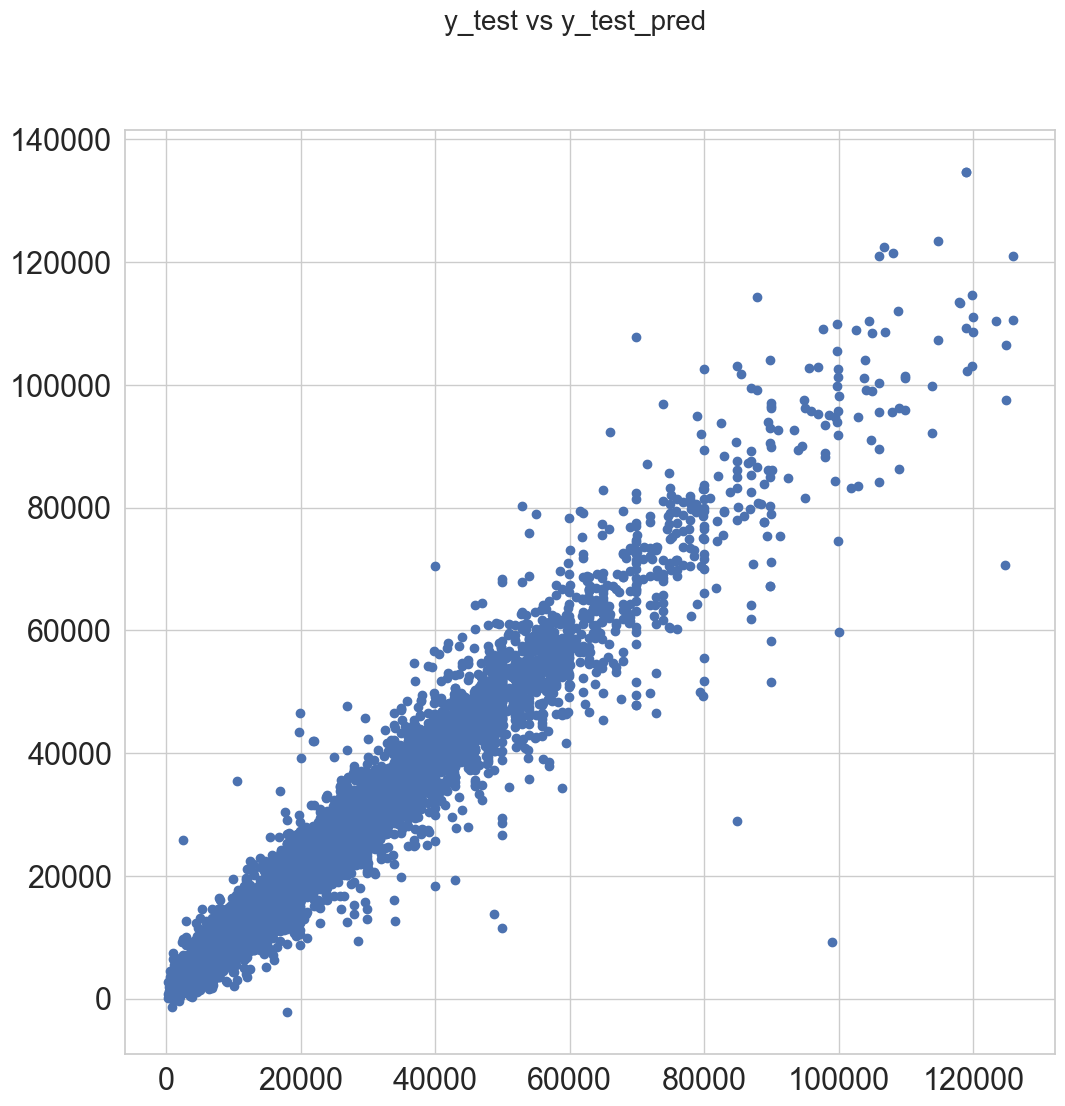

In [286]:
fig = plt.figure(figsize = (12, 12))
fig.suptitle('y_test vs y_test_pred', fontsize=20)
plt.scatter(y_test, y_test_pred)

As we see, the distribution of real and predicted price is correct. It means that the model could be used for prediction.

# 9. Results <a name="results"></a>

This section summarizes the key results and findings:

**Web Scraping**

The web scraping component of the project involved collecting car advertisements data from Nettiauto.com. Here are some notable findings:

- A total of 83,822 car advertisements were successfully scraped and collected from Nettiauto.com.
- Data quality checks and cleaning were performed to address missing values and data inconsistencies.

**Data Wrangling**

Data wrangling was a crucial step in preparing the dataset for further analysis. Key outcomes of this phase include:

- Handling missing data: Techniques such as imputation and removal of incomplete records were applied to address missing values.
- Data transformation: The dataset was transformed to ensure that it adheres to the required format for model building.

**Incorporation of Data from Other Datasets**

In addition to the data collected from Nettiauto.com, we incorporated relevant data from other datasets to enhance the richness of our features and improve model performance:

- [Kaggle](https://www.kaggle.com/datasets/ander289386/cars-germany) dataset with used German cars characteristics.
- Finland cities population information obtained from Finland’s free-of-charge statistical [database](https://stat.fi/tup/tilastotietokannat/index.html).

**Feature Engineering**

Feature engineering involved creating and selecting relevant features to improve model performance. Notable findings in this phase include:

- Generation of new features: Additional features were engineered based on domain knowledge, such as calculating the age of the car or creating aggregate statistics.
- Feature selection: Feature selection techniques were applied to identify the most important variables for predicting car prices.

**Model Building**

Model building aimed to predict car prices based on the dataset's features. Key results in this phase include:

- Several machine learning models were trained and evaluated, including regression models (Linear Regression and ensemble models (Random Forest, XGBoost).
- Evaluation metrics: Performance metrics such as Mean Squared Error (MSE), and R-squared (R2) were used to assess the model's predictive accuracy.

**Hyperparameter Tuning**

Hyperparameter tuning was performed to optimize the model's performance. Findings in this phase include:

- Grid search and random search techniques were used to find the best hyperparameters for the selected models.
- Tuned model showed improved performance in terms of predictive accuracy.


The insights gained from this project can be used to identify valuable car deals, assist potential buyers in their decision-making, and enhance the overall user experience when searching for cars.

# 10. Next steps <a name="steps"></a>

The purpose of this project was to create convenient instrument to identify valuable car deals and to assist potential buyers in their decision-making. Therefore, next steps for this project included:

- Using the developed models for the prediction of car prices for new advertisements as they are posted on Nettiauto.com.
- Implementing a real-time price prediction system to continuously evaluate and identify the best deals (released in /best_deals_collector.py script).
- Distributing the best car advertisements to users through a Telegram bot (released in /best_car_deals_bot.py script).
- Deploying the Telegram bot on the Heroku platform to ensure 24/7 availability (completed).

The integration of these next steps enhanced the project's utility, providing users with up-to-date insights on the best car deals and further streamlining the car buying process.